In [1]:
import pandas as pd
from prophet import Prophet
from datetime import datetime, timedelta
from collections import deque
import numpy as np
import math
import time
from neuralprophet import NeuralProphet

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from orbit.utils.simulation import make_trend, make_seasonality, make_regression

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 8]

%matplotlib inline

import pandas as pd
import random
random.seed()

xs = pd.date_range("00:00", "23:59", freq="1min")
xs

DatetimeIndex(['2021-07-26 00:00:00', '2021-07-26 00:01:00',
               '2021-07-26 00:02:00', '2021-07-26 00:03:00',
               '2021-07-26 00:04:00', '2021-07-26 00:05:00',
               '2021-07-26 00:06:00', '2021-07-26 00:07:00',
               '2021-07-26 00:08:00', '2021-07-26 00:09:00',
               ...
               '2021-07-26 23:50:00', '2021-07-26 23:51:00',
               '2021-07-26 23:52:00', '2021-07-26 23:53:00',
               '2021-07-26 23:54:00', '2021-07-26 23:55:00',
               '2021-07-26 23:56:00', '2021-07-26 23:57:00',
               '2021-07-26 23:58:00', '2021-07-26 23:59:00'],
              dtype='datetime64[ns]', length=1440, freq='T')

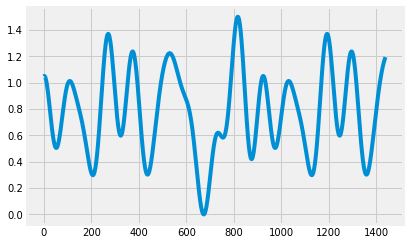

In [25]:
fs = make_seasonality(len(xs), seasonality=random.randint(100, 1000), method='fourier', order=random.randint(4, 10), seed=random.randint(1, 2000))
fs = (1.5*(fs - np.min(fs))/np.ptp(fs))
_ = plt.plot(fs)

# arma_trend =  make_trend(len(xs), method='arma', arma=[.8, -.1], seed=random.randint(1, 2000))
# # normalize [0, 1.5]
# arma_trend = (1.5*(arma_trend - np.min(arma_trend))/np.ptp(arma_trend))
# _ = plt.plot(xs, arma_trend)

# ds = make_seasonality(len(xs), seasonality=random.randint(20, 50), duration=random.randint(2, 50), method='discrete', seed=random.randint(1, 2000))
# ds = (1.5*(ds - np.min(ds))/np.ptp(ds))
# _ = plt.plot(xs, ds)

In [26]:
## Load Data
# ds, y = [], []
# ds_vals = []
# with open('clusterwide_cpu_usage_percentage.txt','r') as fin:
#     for line in fin:
#         ds1, y1 = line.rstrip().split(",")
#         ds_vals.append(float(ds1))
#         ds1 = datetime.fromtimestamp(float(ds1)).strftime("%Y-%m-%d %H:%M")
#         y1 = float(y1) / 100
#         ds.append(ds1)
#         y.append(y1)

# y = siny
# df = pd.DataFrame({"ds" : ds, "y" : y})
# df
df = pd.DataFrame({"ds" : xs, "y" : fs})
df

ds         y
0    2021-07-26 00:00:00  1.047580
1    2021-07-26 00:01:00  1.049641
2    2021-07-26 00:02:00  1.050521
3    2021-07-26 00:03:00  1.050225
4    2021-07-26 00:04:00  1.048761
...                  ...       ...
1435 2021-07-26 23:55:00  1.172503
1436 2021-07-26 23:56:00  1.178184
1437 2021-07-26 23:57:00  1.183541
1438 2021-07-26 23:58:00  1.188572
1439 2021-07-26 23:59:00  1.193274

[1440 rows x 2 columns]

In [27]:
## Facebook Prophet
max_interval = 100 # max training time interval
one_step_len = 10 
n_loops = (len(df) // one_step_len) - 1
print(n_loops)
total_forecast = None
for i1 in range(n_loops): # 39 for normal period and 59 for all
    i = i1 * one_step_len
#     df_train1, df_val1 = df[0:i+one_step_len].copy(), df[i+one_step_len: i + one_step_len*2].copy().reset_index() # no max interval
    lb = 0 if i1 == n_loops-1 else max(0, i + one_step_len - max_interval)
    df_train1, df_val1 = df[lb:i+one_step_len].copy(), df[i+one_step_len: i + one_step_len*2].copy().reset_index()
    
    df_train1['cap'], df_val1['cap'] = 1.0, 1.0
    pm = Prophet(growth="linear",# logistic or linear?  ## linear seems to be more stable
    yearly_seasonality=False, 
    weekly_seasonality=False,
    daily_seasonality=False,) # need to add min_seasonality
    pm.fit(df_train1)  
    future = pm.make_future_dataframe(periods=one_step_len,freq="1MIN",include_history=False,)
    future["cap"] = 1.0
    future_forecast = pm.predict(future)
    future_forecast = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']]
    #future_forecast['y'] = df_val1['y']
    #pm.plot(future_forecast)
    if total_forecast is None:
        total_forecast = future_forecast.copy()
    else:
        total_forecast = pd.concat([total_forecast,future_forecast.copy()])
total_forecast = total_forecast.reset_index()

INFO:prophet:n_changepoints greater than number of observations. Using 7.


143

Initial log joint probability = -1.29296
Iteration  1. Log joint probability =    25.9182. Improved by 27.2112.
Iteration  2. Log joint probability =    35.9936. Improved by 10.0754.
Iteration  3. Log joint probability =    41.8268. Improved by 5.83322.
Iteration  4. Log joint probability =    47.7113. Improved by 5.88449.
Iteration  5. Log joint probability =    49.5922. Improved by 1.88086.
Iteration  6. Log joint probability =    54.5442. Improved by 4.952.
Iteration  7. Log joint probability =    60.2371. Improved by 5.69287.
Iteration  8. Log joint probability =    65.1869. Improved by 4.94983.
Iteration  9. Log joint probability =    66.4543. Improved by 1.26744.
Iteration 10. Log joint probability =    73.5372. Improved by 7.08292.
Iteration 11. Log joint probability =    78.3156. Improved by 4.77836.
Iteration 12. Log joint probability =    82.6042. Improved by 4.28862.
Iteration 13. Log joint probability =     82.963. Improved by 0.358813.
Iteration 14. Log joint probabil

INFO:prophet:n_changepoints greater than number of observations. Using 15.



Initial log joint probability = 7.92948
Iteration  1. Log joint probability =    27.8761. Improved by 19.9467.
Iteration  2. Log joint probability =    30.5036. Improved by 2.62743.
Iteration  3. Log joint probability =    59.4557. Improved by 28.9521.
Iteration  4. Log joint probability =    70.8749. Improved by 11.4193.
Iteration  5. Log joint probability =    73.2536. Improved by 2.37868.
Iteration  6. Log joint probability =    73.2886. Improved by 0.0349365.
Iteration  7. Log joint probability =     73.415. Improved by 0.126421.
Iteration  8. Log joint probability =    84.7159. Improved by 11.3009.
Iteration  9. Log joint probability =    90.6537. Improved by 5.93782.
Iteration 10. Log joint probability =    93.8361. Improved by 3.18241.
Iteration 11. Log joint probability =    99.9828. Improved by 6.14665.
Iteration 12. Log joint probability =    105.964. Improved by 5.98133.
Iteration 13. Log joint probability =    115.393. Improved by 9.42871.
Iteration 14. Log joint probabili

INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = 17.1283
Iteration  1. Log joint probability =    36.6908. Improved by 19.5625.
Iteration  2. Log joint probability =    69.6874. Improved by 32.9966.
Iteration  3. Log joint probability =    88.7811. Improved by 19.0938.
Iteration  4. Log joint probability =    98.5942. Improved by 9.81307.
Iteration  5. Log joint probability =    103.419. Improved by 4.82477.
Iteration  6. Log joint probability =    103.446. Improved by 0.0265559.
Iteration  7. Log joint probability =    103.719. Improved by 0.273629.
Iteration  8. Log joint probability =    116.748. Improved by 13.0286.
Iteration  9. Log joint probability =    117.053. Improved by 0.305389.
Iteration 10. Log joint probability =     122.98. Improved by 5.92656.
Iteration 11. Log joint probability =    124.535. Improved by 1.55579.
Iteration 12. Log joint probability =    125.175. Improved by 0.639688.
Iteration 13. Log joint probability =    125.179. Improved by 0.00358776.
Iteration 14. Log joint prob

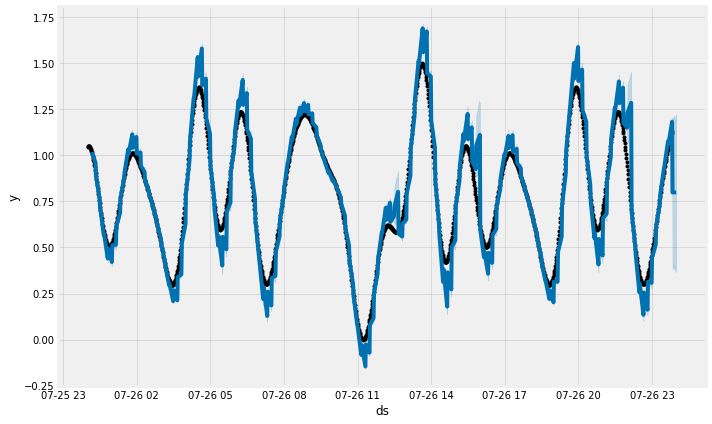

In [28]:
total_forecast
p = pm.plot(total_forecast)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 1000
INFO:nprophet.config:Auto-set epochs to 1000


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
INFO:nprophet:learning rate range test found optimal lr: 1.23E+00


143


Epoch[1000/1000]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.85it/s, SmoothL1Loss=3.13e-6, MAE=0.000204, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 800
INFO:nprophet.config:Auto-set epochs to 800


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[800/800]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:07<00:00, 100.60it/s, SmoothL1Loss=4.42e-6, MAE=0.000226, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 533
INFO:nprophet.config:Auto-set epochs to 533


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E+00
INFO:nprophet:learning rate range test found optimal lr: 1.87E+00
Epoch[533/533]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 533/533 [00:07<00:00, 71.71it/s, SmoothL1Loss=2.51e-5, MAE=0.000746, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 400
INFO:nprophet.config:Auto-set epochs to 400


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-01
INFO:nprophet:learning rate range test found optimal lr: 8.11E-01
Epoch[400/400]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 54.98it/s, SmoothL1Loss=9.63e-6, MAE=0.000831, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-04
INFO:nprophet:learning rate range test found optimal lr: 1.00E-04
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:07<00:00, 44.83it/s, SmoothL1Loss=0.0637, MAE=0.103, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 266
INFO:nprophet.config:Auto-set epochs to 266


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-02
INFO:nprophet:learning rate range test found optimal lr: 3.51E-02
Epoch[266/266]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:07<00:00, 37.96it/s, SmoothL1Loss=1.7e-5, MAE=0.000965, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 228
INFO:nprophet.config:Auto-set epochs to 228


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
INFO:nprophet:learning rate range test found optimal lr: 3.51E-01
Epoch[228/228]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:06<00:00, 32.98it/s, SmoothL1Loss=1.06e-5, MAE=0.000834, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 200
INFO:nprophet.config:Auto-set epochs to 200


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[200/200]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 29.42it/s, SmoothL1Loss=8.07e-5, MAE=0.0024, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 177
INFO:nprophet.config:Auto-set epochs to 177


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
INFO:nprophet:learning rate range test found optimal lr: 3.51E-01
Epoch[177/177]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:06<00:00, 26.33it/s, SmoothL1Loss=0.000233, MAE=0.00409, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E+00
INFO:nprophet:learning rate range test found optimal lr: 2.85E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.03it/s, SmoothL1Loss=0.000373, MAE=0.00653, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E+00
INFO:nprophet:learning rate range test found optimal lr: 1.00E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.64it/s, SmoothL1Loss=3.57e-5, MAE=0.00257, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-01
INFO:nprophet:learning rate range test found optimal lr: 1.23E-01
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.36it/s, SmoothL1Loss=0.000188, MAE=0.00367, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
INFO:nprophet:learning rate range test found optimal lr: 1.23E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.96it/s, SmoothL1Loss=0.000305, MAE=0.00576, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E+00
INFO:nprophet:learning rate range test found optimal lr: 1.87E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.68it/s, SmoothL1Loss=7.92e-5, MAE=0.00382, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.11it/s, SmoothL1Loss=0.00018, MAE=0.00536, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E+00
INFO:nprophet:learning rate range test found optimal lr: 1.87E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.35it/s, SmoothL1Loss=0.000512, MAE=0.00762, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-01
INFO:nprophet:learning rate range test found optimal lr: 1.00E-01
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.77it/s, SmoothL1Loss=0.000301, MAE=0.00455, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E+00
INFO:nprophet:learning rate range test found optimal lr: 1.00E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.98it/s, SmoothL1Loss=1.8e-5, MAE=0.00284, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-04
INFO:nprophet:learning rate range test found optimal lr: 8.11E-04
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.00it/s, SmoothL1Loss=0.00676, MAE=0.0759, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.81it/s, SmoothL1Loss=0.000201, MAE=0.0103, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E+00
INFO:nprophet:learning rate range test found optimal lr: 5.34E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.96it/s, SmoothL1Loss=0.000194, MAE=0.0117, RegLoss=0]
/Users/tybalex/.pyenv/versions/3.8.6/envs/py38/lib/python3.8/site-packages/neuralprophet/plot_forecast.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor="w", figsize=figsize)
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set 

  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
INFO:nprophet:learning rate range test found optimal lr: 6.58E-01
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.23it/s, SmoothL1Loss=1.09e-5, MAE=0.0026, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-01
INFO:nprophet:learning rate range test found optimal lr: 1.23E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.66it/s, SmoothL1Loss=4.01e-5, MAE=0.00354, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E+00
INFO:nprophet:learning rate range test found optimal lr: 2.85E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.93it/s, SmoothL1Loss=0.000176, MAE=0.0104, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
INFO:nprophet:learning rate range test found optimal lr: 5.34E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.11it/s, SmoothL1Loss=9.88e-5, MAE=0.00585, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-01
INFO:nprophet:learning rate range test found optimal lr: 1.52E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.18it/s, SmoothL1Loss=8.09e-6, MAE=0.00152, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
INFO:nprophet:learning rate range test found optimal lr: 1.23E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.10it/s, SmoothL1Loss=0.000146, MAE=0.00761, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
INFO:nprophet:learning rate range test found optimal lr: 6.58E-01
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.61it/s, SmoothL1Loss=0.000205, MAE=0.00783, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E+00
INFO:nprophet:learning rate range test found optimal lr: 1.00E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.45it/s, SmoothL1Loss=0.000103, MAE=0.0062, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-02
INFO:nprophet:learning rate range test found optimal lr: 1.00E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.59it/s, SmoothL1Loss=7.34e-5, MAE=0.00586, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.42it/s, SmoothL1Loss=0.000226, MAE=0.0112, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.36it/s, SmoothL1Loss=0.00033, MAE=0.0129, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-03
INFO:nprophet:learning rate range test found optimal lr: 8.11E-03
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.95it/s, SmoothL1Loss=0.000264, MAE=0.0089, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.99it/s, SmoothL1Loss=5.17e-5, MAE=0.00824, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
INFO:nprophet:learning rate range test found optimal lr: 1.23E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.32it/s, SmoothL1Loss=2.67e-5, MAE=0.00713, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.79it/s, SmoothL1Loss=6.42e-5, MAE=0.0123, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E+00
INFO:nprophet:learning rate range test found optimal lr: 2.85E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.66it/s, SmoothL1Loss=7.31e-5, MAE=0.0137, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-02
INFO:nprophet:learning rate range test found optimal lr: 5.34E-02
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.73it/s, SmoothL1Loss=2e-5, MAE=0.00482, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.06it/s, SmoothL1Loss=1.33e-5, MAE=0.00658, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.78it/s, SmoothL1Loss=6.08e-6, MAE=0.0036, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.95it/s, SmoothL1Loss=1.85e-5, MAE=0.00492, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E+00
INFO:nprophet:learning rate range test found optimal lr: 1.87E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.08it/s, SmoothL1Loss=0.000123, MAE=0.0108, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-02
INFO:nprophet:learning rate range test found optimal lr: 8.11E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.56it/s, SmoothL1Loss=1.74e-5, MAE=0.00344, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-02
INFO:nprophet:learning rate range test found optimal lr: 2.85E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.89it/s, SmoothL1Loss=1.14e-5, MAE=0.00239, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
INFO:nprophet:learning rate range test found optimal lr: 1.23E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.59it/s, SmoothL1Loss=1.71e-5, MAE=0.00401, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-02
INFO:nprophet:learning rate range test found optimal lr: 1.00E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.75it/s, SmoothL1Loss=3.54e-6, MAE=0.00157, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E+00
INFO:nprophet:learning rate range test found optimal lr: 3.51E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.27it/s, SmoothL1Loss=6.39e-5, MAE=0.00634, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
INFO:nprophet:learning rate range test found optimal lr: 1.23E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.89it/s, SmoothL1Loss=2.73e-5, MAE=0.00339, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.75it/s, SmoothL1Loss=4.17e-5, MAE=0.00518, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E+00
INFO:nprophet:learning rate range test found optimal lr: 1.87E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.39it/s, SmoothL1Loss=4.06e-5, MAE=0.00471, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E+00
INFO:nprophet:learning rate range test found optimal lr: 1.00E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.24it/s, SmoothL1Loss=4.38e-5, MAE=0.00419, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E+00
INFO:nprophet:learning rate range test found optimal lr: 1.00E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.70it/s, SmoothL1Loss=3.95e-5, MAE=0.00381, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-02
INFO:nprophet:learning rate range test found optimal lr: 2.85E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.40it/s, SmoothL1Loss=1.71e-5, MAE=0.00226, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-02
INFO:nprophet:learning rate range test found optimal lr: 1.87E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 71.89it/s, SmoothL1Loss=2.28e-5, MAE=0.00406, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.25it/s, SmoothL1Loss=2.48e-5, MAE=0.0047, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
INFO:nprophet:learning rate range test found optimal lr: 5.34E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.53it/s, SmoothL1Loss=4.39e-5, MAE=0.00666, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E+00
INFO:nprophet:learning rate range test found optimal lr: 1.87E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 75.02it/s, SmoothL1Loss=6.15e-5, MAE=0.00937, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
INFO:nprophet:learning rate range test found optimal lr: 5.34E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.57it/s, SmoothL1Loss=3.25e-5, MAE=0.00628, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.36it/s, SmoothL1Loss=4.68e-6, MAE=0.00253, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-02
INFO:nprophet:learning rate range test found optimal lr: 3.51E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.24it/s, SmoothL1Loss=6.73e-6, MAE=0.00366, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E+00
INFO:nprophet:learning rate range test found optimal lr: 1.00E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.39it/s, SmoothL1Loss=3e-5, MAE=0.00842, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
INFO:nprophet:learning rate range test found optimal lr: 6.58E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.71it/s, SmoothL1Loss=4.54e-5, MAE=0.00947, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.87it/s, SmoothL1Loss=4.12e-5, MAE=0.0114, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
INFO:nprophet:learning rate range test found optimal lr: 5.34E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.04it/s, SmoothL1Loss=7.04e-6, MAE=0.00453, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E+00
INFO:nprophet:learning rate range test found optimal lr: 3.51E+00
Epoch[320/320]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.77it/s, SmoothL1Loss=2.7e-5, MAE=0.0114, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
INFO:nprophet:learning rate range test found optimal lr: 3.51E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.02it/s, SmoothL1Loss=3.41e-5, MAE=0.00684, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E+00
INFO:nprophet:learning rate range test found optimal lr: 1.87E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.37it/s, SmoothL1Loss=0.000147, MAE=0.0152, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E+00
INFO:nprophet:learning rate range test found optimal lr: 2.85E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.08it/s, SmoothL1Loss=0.000197, MAE=0.0172, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
INFO:nprophet:learning rate range test found optimal lr: 6.58E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 71.87it/s, SmoothL1Loss=1.79e-5, MAE=0.00433, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
INFO:nprophet:learning rate range test found optimal lr: 6.58E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.06it/s, SmoothL1Loss=3.66e-5, MAE=0.00711, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
INFO:nprophet:learning rate range test found optimal lr: 5.34E-01
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.48it/s, SmoothL1Loss=4.6e-5, MAE=0.00697, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-03
INFO:nprophet:learning rate range test found optimal lr: 5.34E-03
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.68it/s, SmoothL1Loss=0.000104, MAE=0.0103, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-02
INFO:nprophet:learning rate range test found optimal lr: 8.11E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.90it/s, SmoothL1Loss=1.08e-5, MAE=0.00247, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.90it/s, SmoothL1Loss=6.41e-5, MAE=0.00539, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.84it/s, SmoothL1Loss=9.92e-5, MAE=0.00985, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
INFO:nprophet:learning rate range test found optimal lr: 6.58E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 73.69it/s, SmoothL1Loss=3.33e-5, MAE=0.00489, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
INFO:nprophet:learning rate range test found optimal lr: 3.51E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 74.35it/s, SmoothL1Loss=3.98e-6, MAE=0.00171, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.46it/s, SmoothL1Loss=5.34e-5, MAE=0.00705, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E+00
INFO:nprophet:learning rate range test found optimal lr: 1.87E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 71.17it/s, SmoothL1Loss=4.58e-5, MAE=0.00697, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
INFO:nprophet:learning rate range test found optimal lr: 1.87E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.41it/s, SmoothL1Loss=4.49e-6, MAE=0.00158, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.40it/s, SmoothL1Loss=8.61e-5, MAE=0.0069, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E+00
INFO:nprophet:learning rate range test found optimal lr: 1.87E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 71.41it/s, SmoothL1Loss=0.000346, MAE=0.00778, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.35it/s, SmoothL1Loss=0.000196, MAE=0.00354, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.83it/s, SmoothL1Loss=6.28e-5, MAE=0.00349, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E+00
INFO:nprophet:learning rate range test found optimal lr: 3.51E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 71.38it/s, SmoothL1Loss=0.000466, MAE=0.00856, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.07it/s, SmoothL1Loss=0.000373, MAE=0.00656, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 71.61it/s, SmoothL1Loss=0.000138, MAE=0.00482, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.93it/s, SmoothL1Loss=0.00013, MAE=0.00487, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E+00
INFO:nprophet:learning rate range test found optimal lr: 1.87E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.30it/s, SmoothL1Loss=0.000466, MAE=0.00734, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.81it/s, SmoothL1Loss=0.000389, MAE=0.0055, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E+00
INFO:nprophet:learning rate range test found optimal lr: 2.85E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 71.55it/s, SmoothL1Loss=8.57e-5, MAE=0.00609, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
INFO:nprophet:learning rate range test found optimal lr: 6.58E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 70.01it/s, SmoothL1Loss=3.81e-5, MAE=0.00395, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:05<00:00, 63.37it/s, SmoothL1Loss=0.000189, MAE=0.01, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 71.06it/s, SmoothL1Loss=0.000136, MAE=0.00781, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E+00
INFO:nprophet:learning rate range test found optimal lr: 2.85E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 70.79it/s, SmoothL1Loss=5.65e-5, MAE=0.00692, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-01
INFO:nprophet:learning rate range test found optimal lr: 8.11E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 71.87it/s, SmoothL1Loss=2.93e-5, MAE=0.00402, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
INFO:nprophet:learning rate range test found optimal lr: 1.23E+00
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.51it/s, SmoothL1Loss=0.000126, MAE=0.00766, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 72.52it/s, SmoothL1Loss=0.000104, MAE=0.00557, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-05
INFO:nprophet:learning rate range test found optimal lr: 1.23E-05
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 71.33it/s, SmoothL1Loss=0.0527, MAE=0.171, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-02
INFO:nprophet:learning rate range test found optimal lr: 5.34E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 70.80it/s, SmoothL1Loss=6.79e-5, MAE=0.00434, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-01
INFO:nprophet:learning rate range test found optimal lr: 1.52E-01
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 70.78it/s, SmoothL1Loss=0.000185, MAE=0.00684, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
INFO:nprophet:learning rate range test found optimal lr: 5.34E-01
Epoch[320/320]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 68.16it/s, SmoothL1Loss=0.000124, MAE=0.00609, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
INFO:nprophet:learning rate range test found optimal lr: 1.23E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 65.22it/s, SmoothL1Loss=3.03e-5, MAE=0.00412, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E+00
INFO:nprophet:learning rate range test found optimal lr: 2.85E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 67.17it/s, SmoothL1Loss=0.000274, MAE=0.0125, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 67.62it/s, SmoothL1Loss=0.000278, MAE=0.0108, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-02
INFO:nprophet:learning rate range test found optimal lr: 3.51E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 67.29it/s, SmoothL1Loss=0.00021, MAE=0.00796, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
INFO:nprophet:learning rate range test found optimal lr: 5.34E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 69.22it/s, SmoothL1Loss=2.92e-5, MAE=0.00482, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-02
INFO:nprophet:learning rate range test found optimal lr: 1.00E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 69.32it/s, SmoothL1Loss=3.66e-5, MAE=0.00806, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 68.53it/s, SmoothL1Loss=5.82e-5, MAE=0.0118, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.57it/s, SmoothL1Loss=5.18e-5, MAE=0.0081, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E+00
INFO:nprophet:learning rate range test found optimal lr: 1.00E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.96it/s, SmoothL1Loss=3.35e-5, MAE=0.00861, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-02
INFO:nprophet:learning rate range test found optimal lr: 1.87E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 67.80it/s, SmoothL1Loss=1.03e-5, MAE=0.00438, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
INFO:nprophet:learning rate range test found optimal lr: 1.23E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 67.43it/s, SmoothL1Loss=9.19e-6, MAE=0.00559, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 67.48it/s, SmoothL1Loss=3.98e-5, MAE=0.00994, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
INFO:nprophet:learning rate range test found optimal lr: 6.58E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 68.66it/s, SmoothL1Loss=6.41e-5, MAE=0.00776, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.24it/s, SmoothL1Loss=0.00017, MAE=0.0117, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E+00
INFO:nprophet:learning rate range test found optimal lr: 1.00E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.91it/s, SmoothL1Loss=3.94e-5, MAE=0.00523, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E+00
INFO:nprophet:learning rate range test found optimal lr: 5.34E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.90it/s, SmoothL1Loss=9.81e-5, MAE=0.0103, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 67.20it/s, SmoothL1Loss=4.98e-6, MAE=0.00269, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E+00
INFO:nprophet:learning rate range test found optimal lr: 1.00E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.80it/s, SmoothL1Loss=5.82e-6, MAE=0.00184, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-01
INFO:nprophet:learning rate range test found optimal lr: 8.11E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.57it/s, SmoothL1Loss=2.08e-5, MAE=0.00275, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.71it/s, SmoothL1Loss=4.32e-5, MAE=0.00517, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 67.53it/s, SmoothL1Loss=4.26e-5, MAE=0.00519, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-01
INFO:nprophet:learning rate range test found optimal lr: 8.11E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.99it/s, SmoothL1Loss=4.27e-5, MAE=0.00406, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.83it/s, SmoothL1Loss=5.3e-5, MAE=0.00489, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-02
INFO:nprophet:learning rate range test found optimal lr: 1.23E-02
Epoch[320/320]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.67it/s, SmoothL1Loss=7.21e-5, MAE=0.005, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 66.17it/s, SmoothL1Loss=2.99e-5, MAE=0.00403, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:05<00:00, 63.79it/s, SmoothL1Loss=3.33e-5, MAE=0.00619, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 64.08it/s, SmoothL1Loss=3.76e-5, MAE=0.00564, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-02
INFO:nprophet:learning rate range test found optimal lr: 4.33E-02
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:05<00:00, 63.47it/s, SmoothL1Loss=6.51e-5, MAE=0.00955, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:05<00:00, 63.83it/s, SmoothL1Loss=5.41e-5, MAE=0.00986, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 65.14it/s, SmoothL1Loss=1.24e-5, MAE=0.00512, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
INFO:nprophet:learning rate range test found optimal lr: 1.23E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 64.68it/s, SmoothL1Loss=5.13e-6, MAE=0.0039, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 64.94it/s, SmoothL1Loss=2.69e-5, MAE=0.0087, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E+00
INFO:nprophet:learning rate range test found optimal lr: 1.00E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 65.63it/s, SmoothL1Loss=4.75e-5, MAE=0.0106, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 64.37it/s, SmoothL1Loss=4.42e-5, MAE=0.0112, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E+00
INFO:nprophet:learning rate range test found optimal lr: 2.85E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 64.97it/s, SmoothL1Loss=2.57e-5, MAE=0.0112, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E+00
INFO:nprophet:learning rate range test found optimal lr: 2.85E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 64.27it/s, SmoothL1Loss=1.65e-5, MAE=0.00918, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-06
INFO:nprophet:learning rate range test found optimal lr: 2.31E-06
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 64.15it/s, SmoothL1Loss=0.13, MAE=0.566, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E+00
INFO:nprophet:learning rate range test found optimal lr: 1.52E+00
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 64.00it/s, SmoothL1Loss=0.000103, MAE=0.0123, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-01
INFO:nprophet:learning rate range test found optimal lr: 1.52E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:05<00:00, 63.81it/s, SmoothL1Loss=3.56e-5, MAE=0.00581, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
INFO:nprophet:learning rate range test found optimal lr: 1.87E-01
Epoch[320/320]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:04<00:00, 64.12it/s, SmoothL1Loss=1.35e-5, MAE=0.00328, RegLoss=0]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E+00
INFO:nprophet:learning rate range test found optimal lr: 2.31E+00
Epoch[320/320]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:05<00:00, 63.66it/s, SmoothL1Loss=6.73e-5, MAE=0.0114, RegLoss=0]


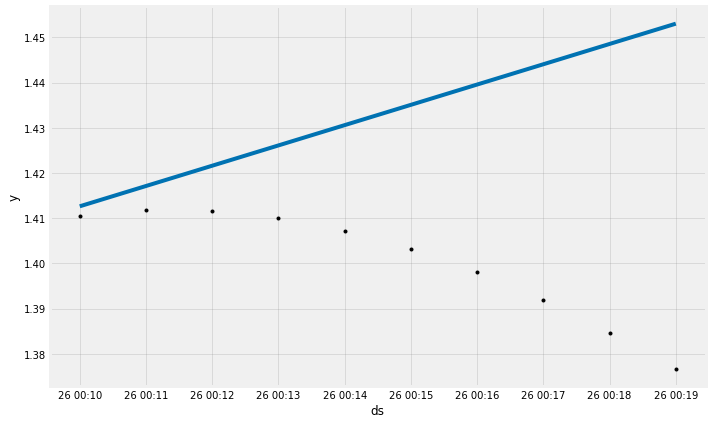

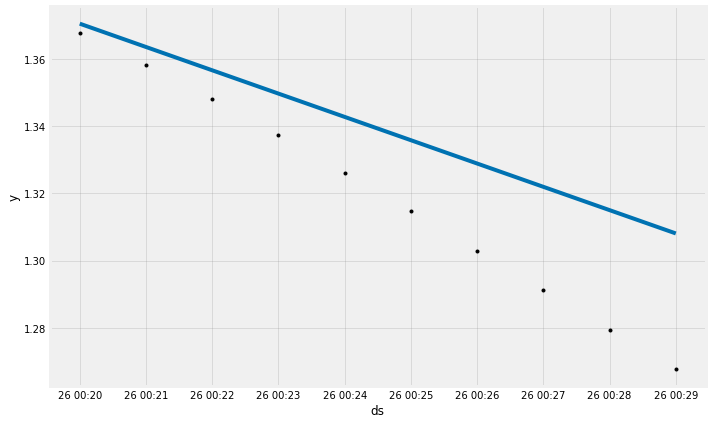

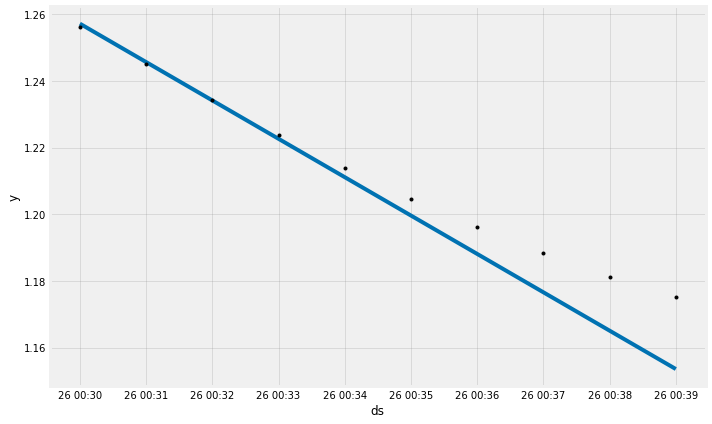

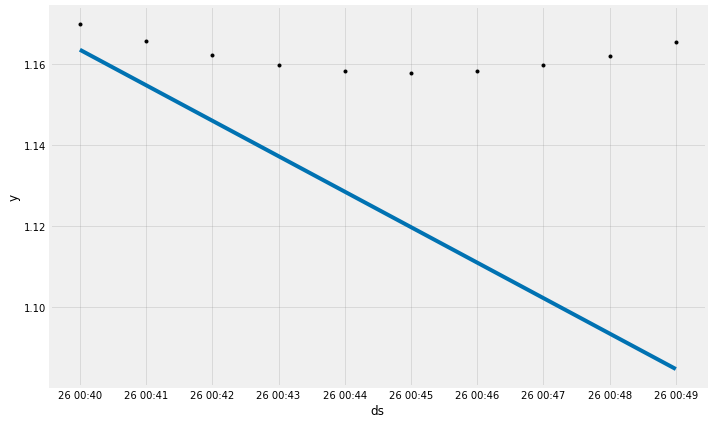

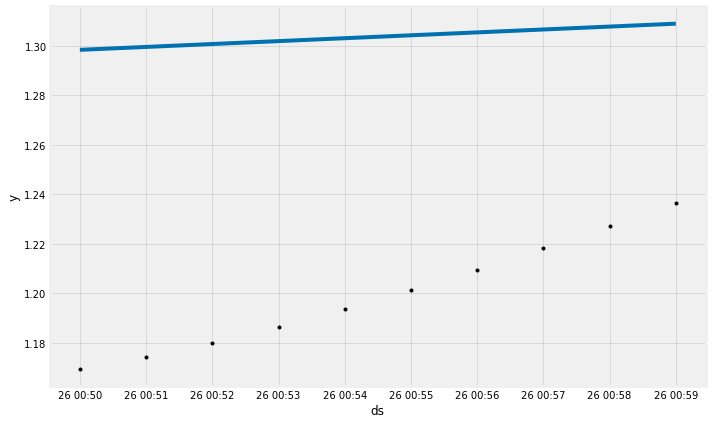

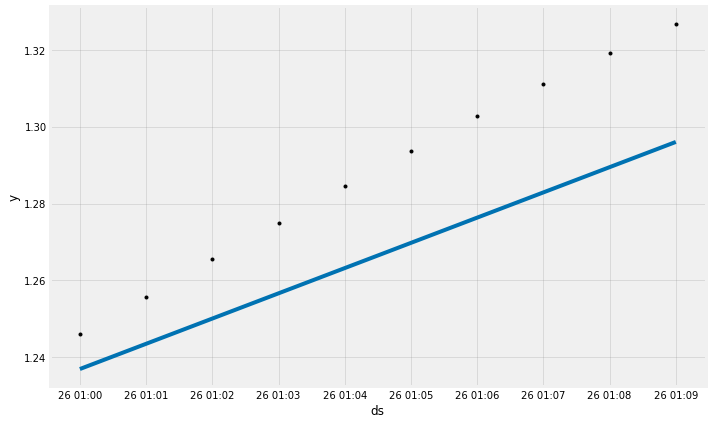

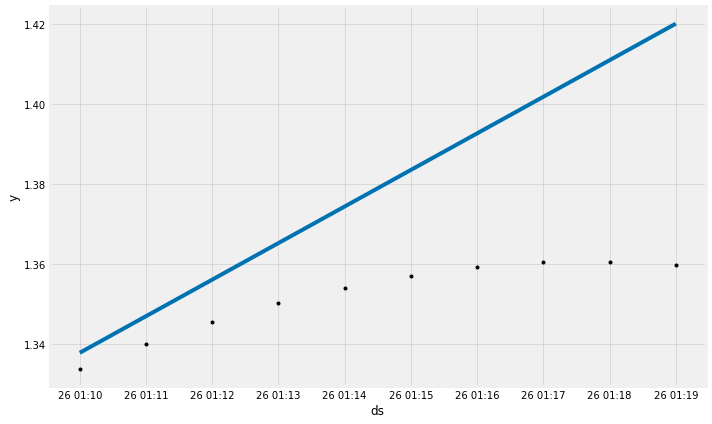

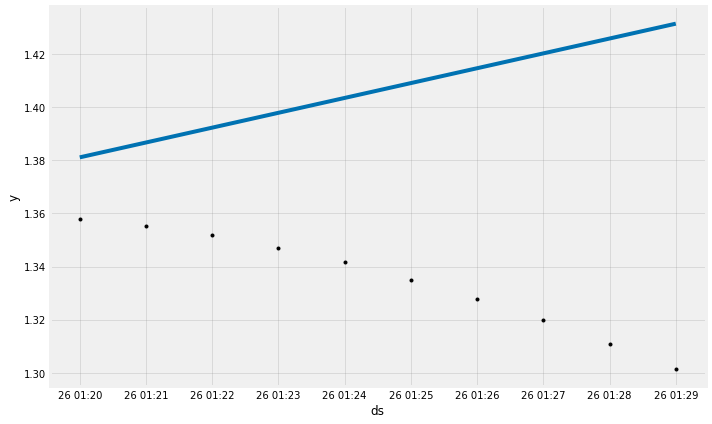

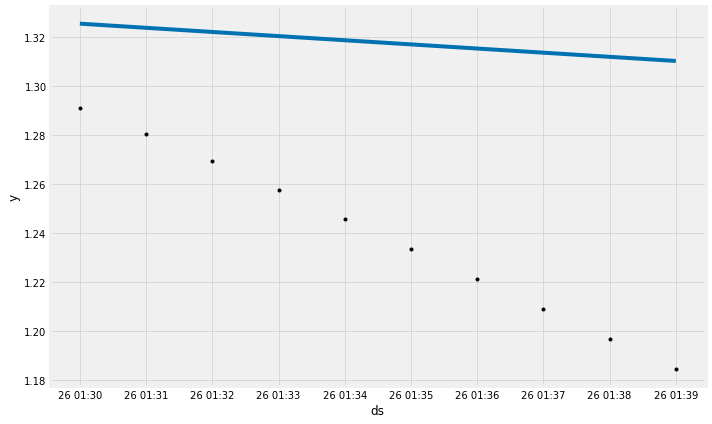

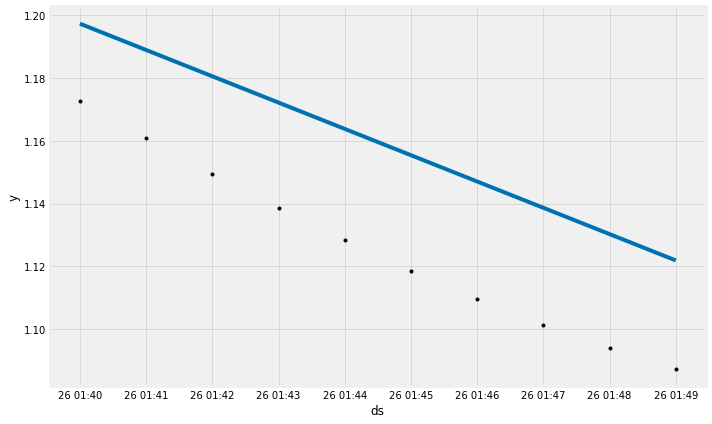

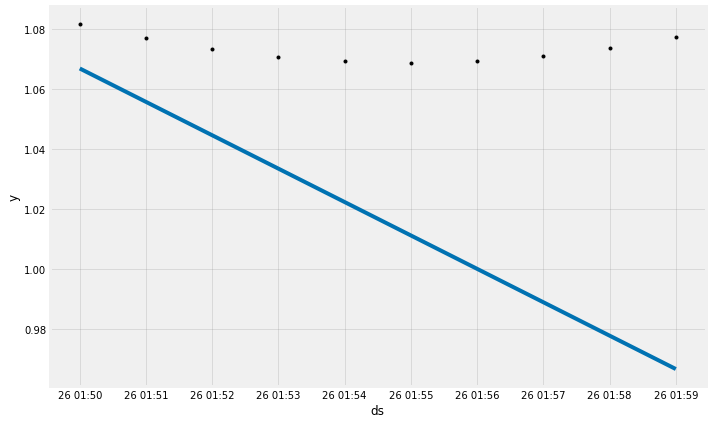

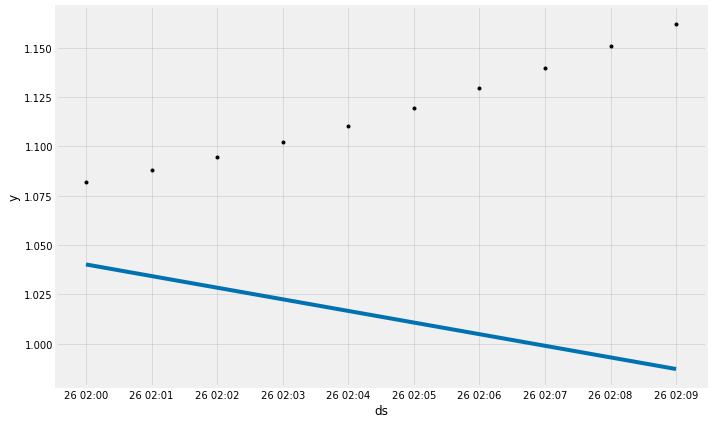

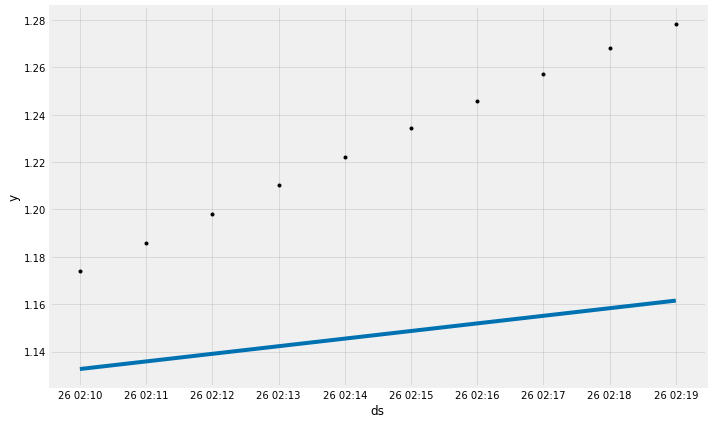

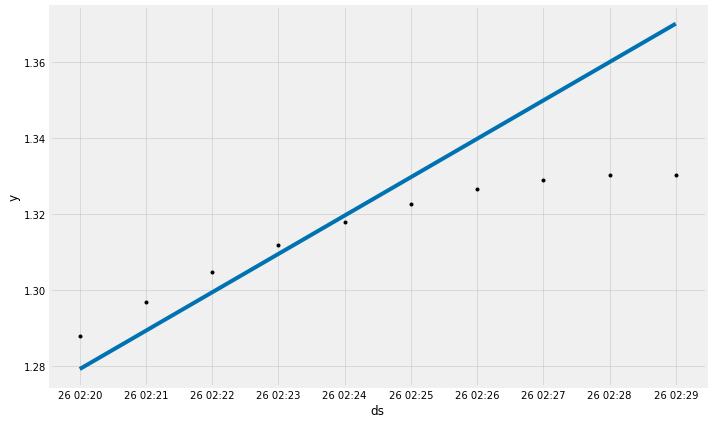

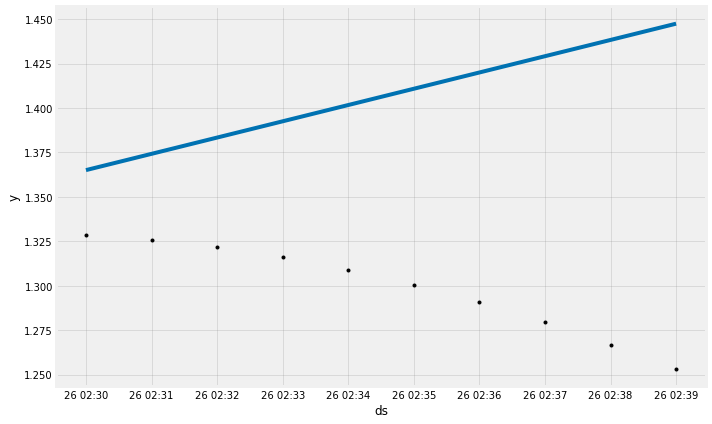

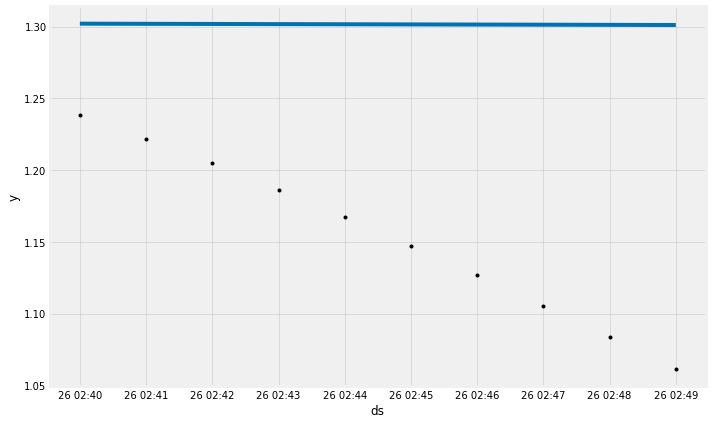

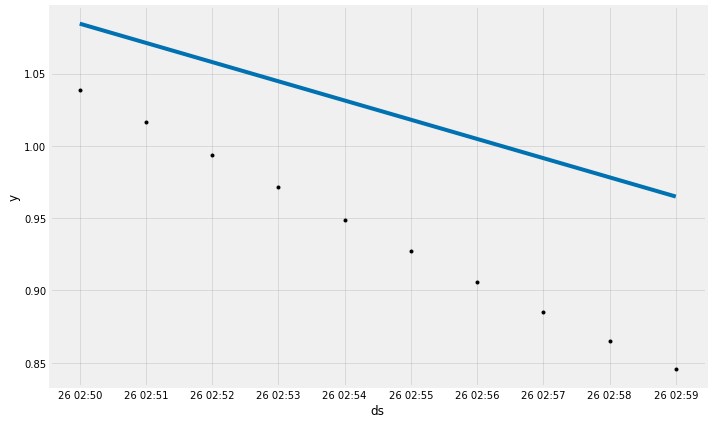

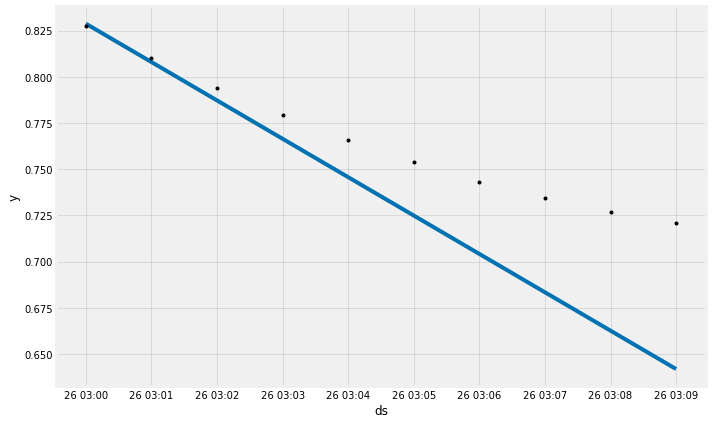

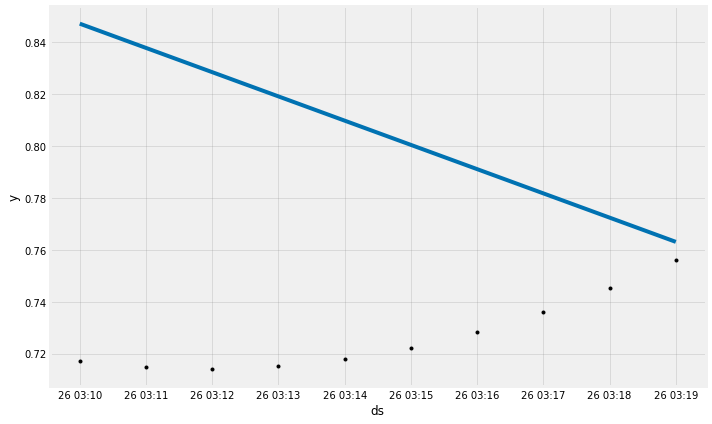

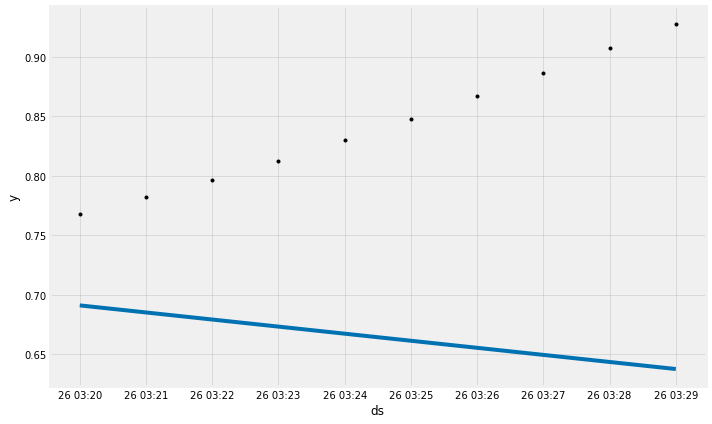

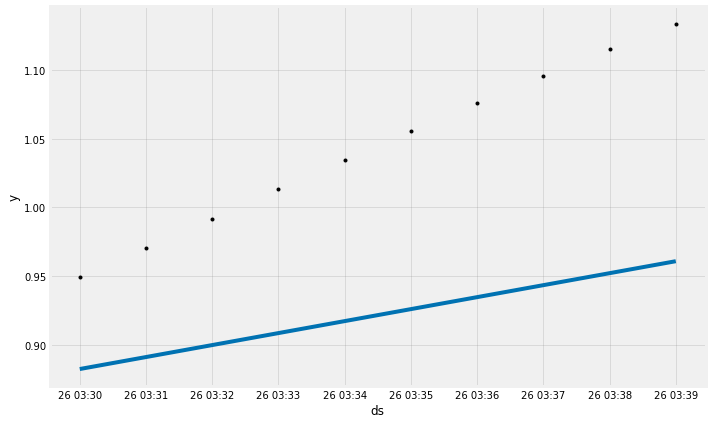

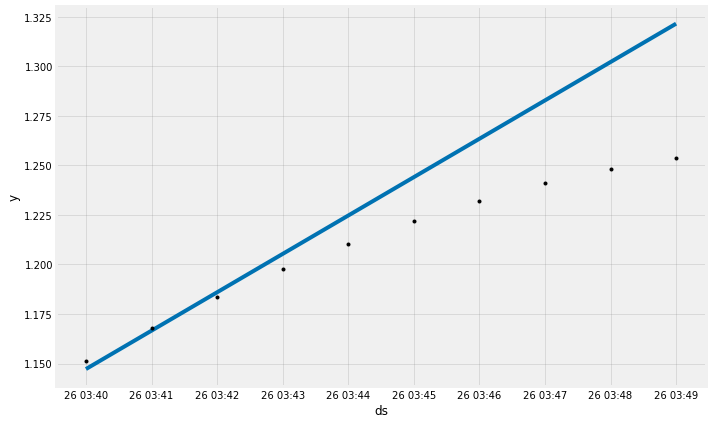

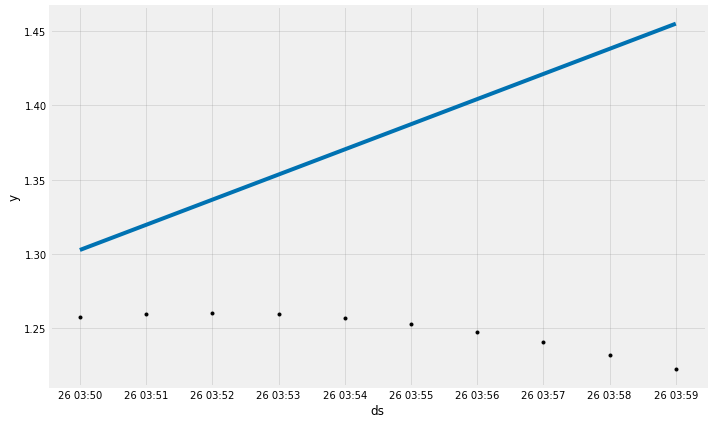

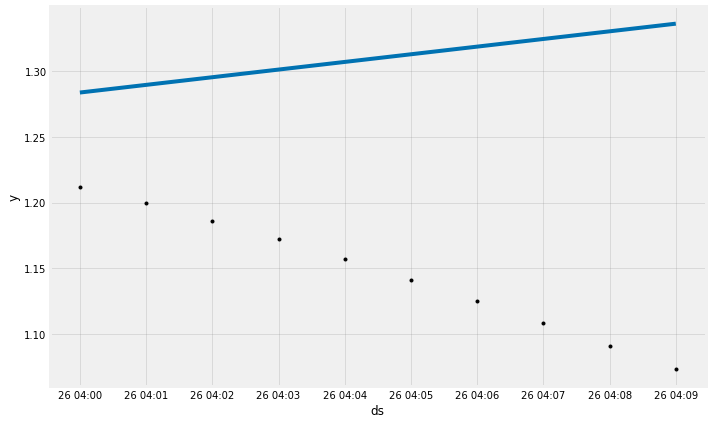

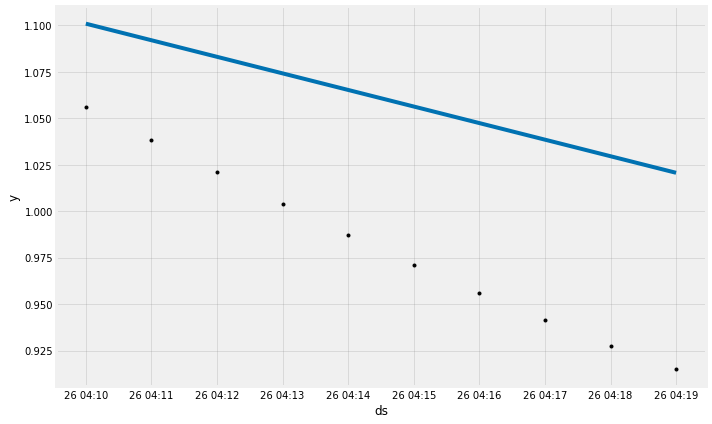

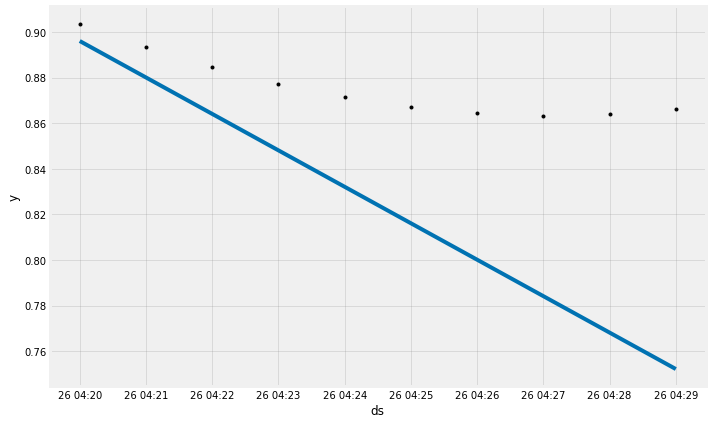

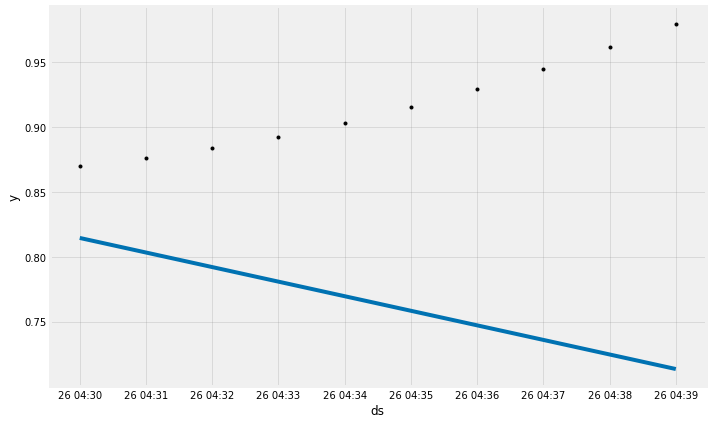

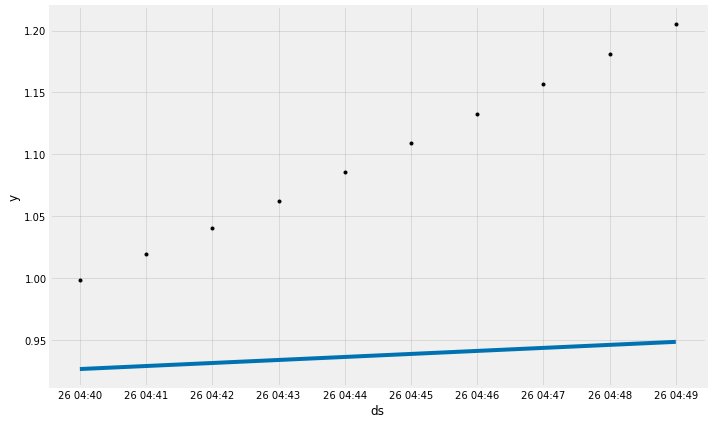

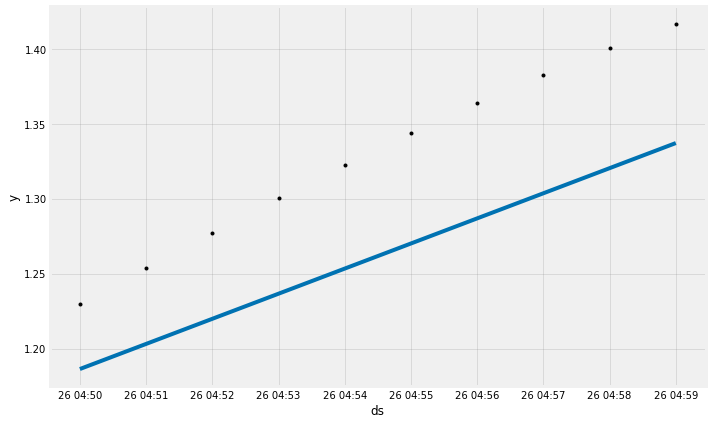

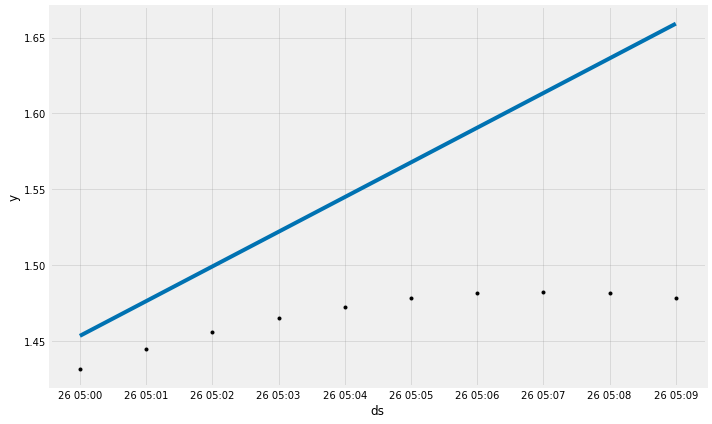

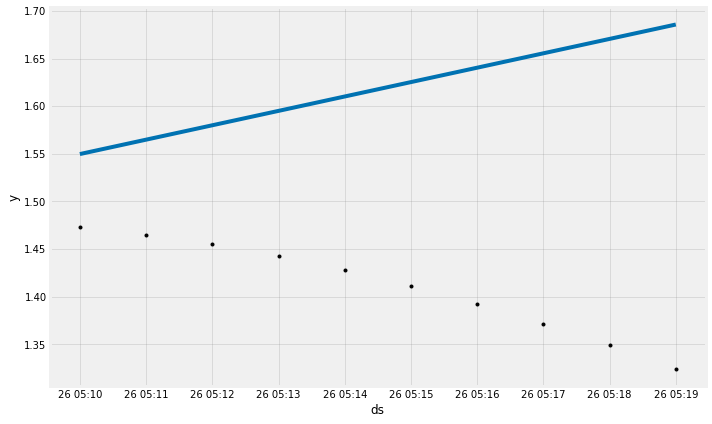

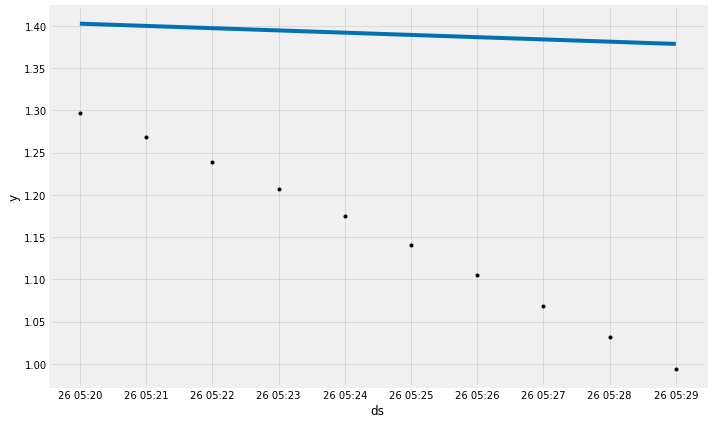

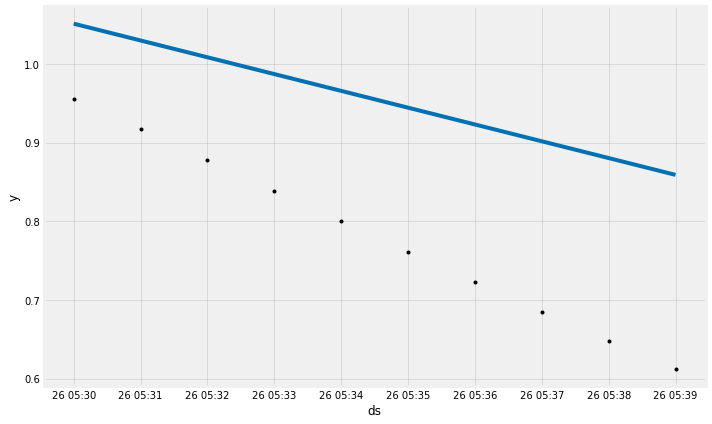

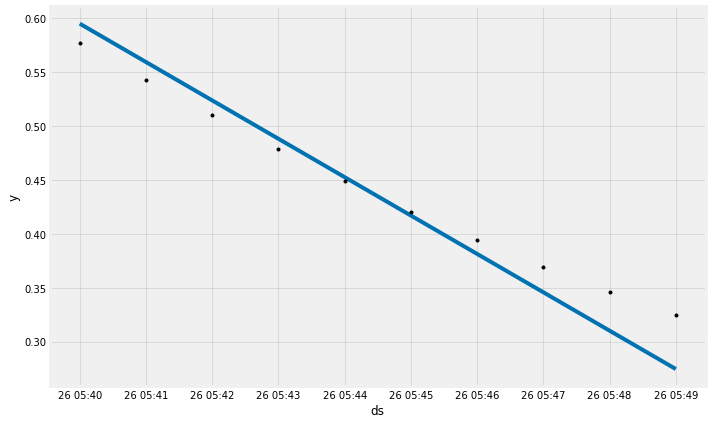

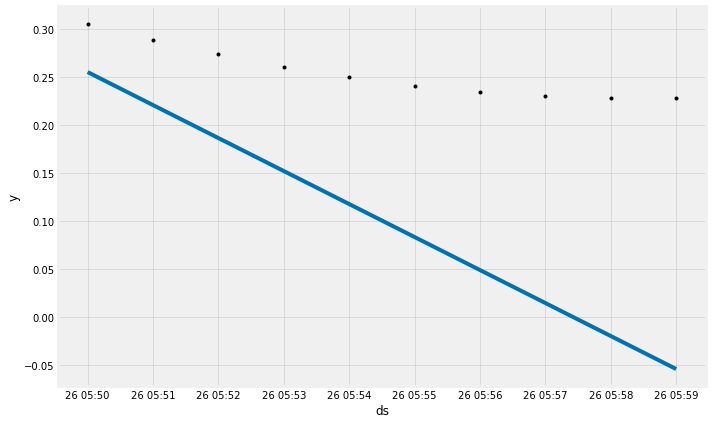

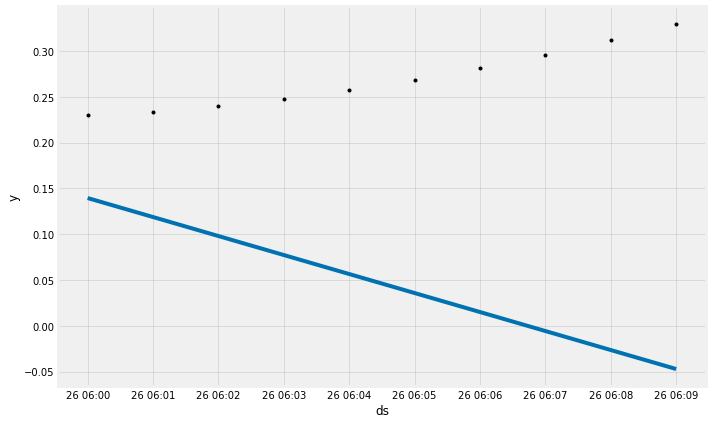

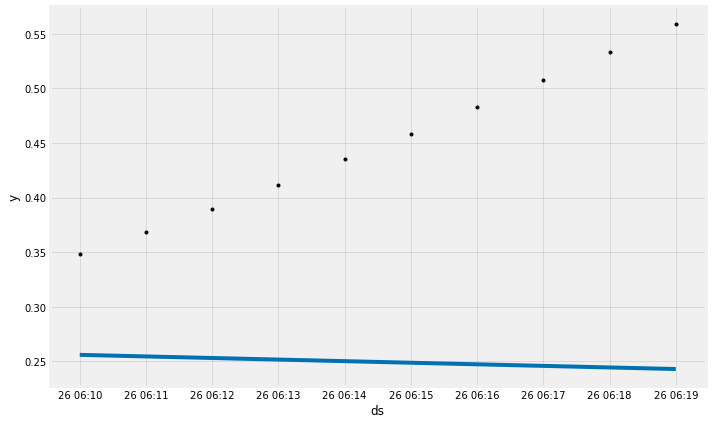

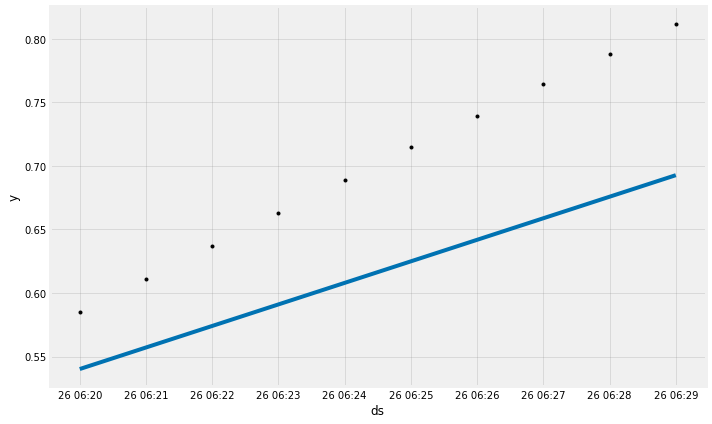

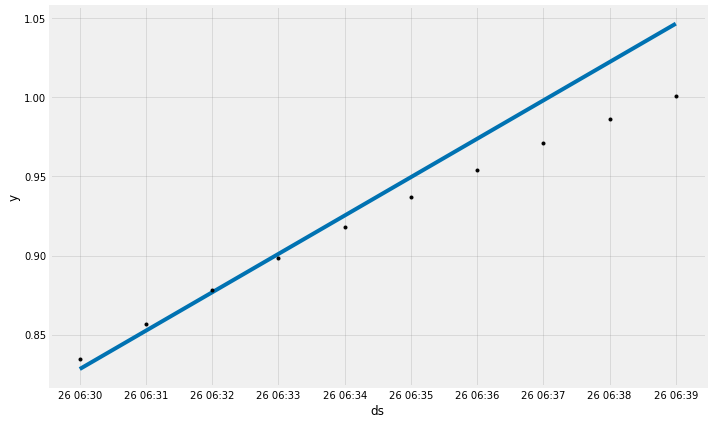

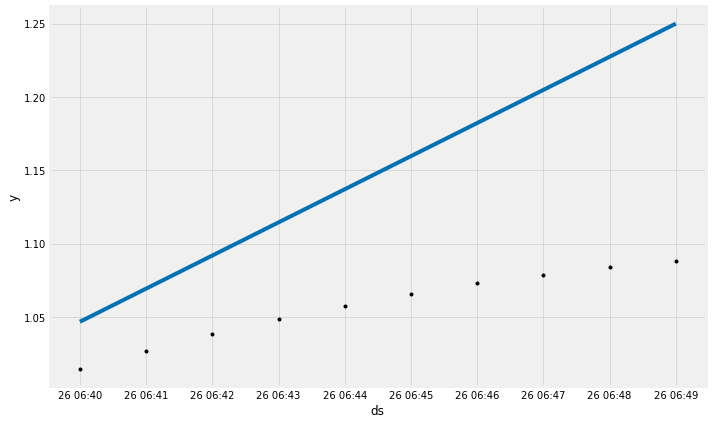

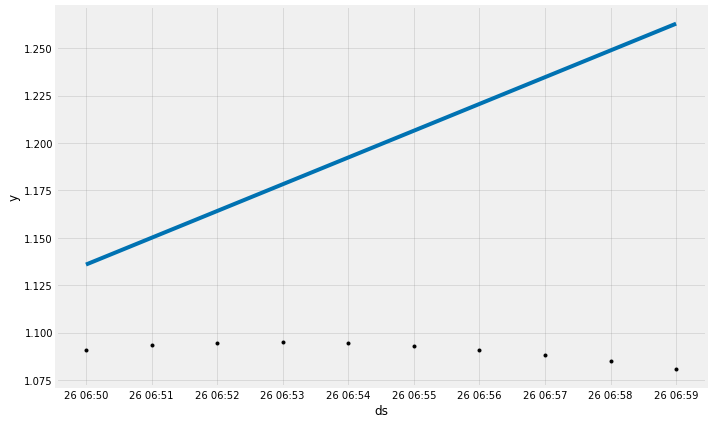

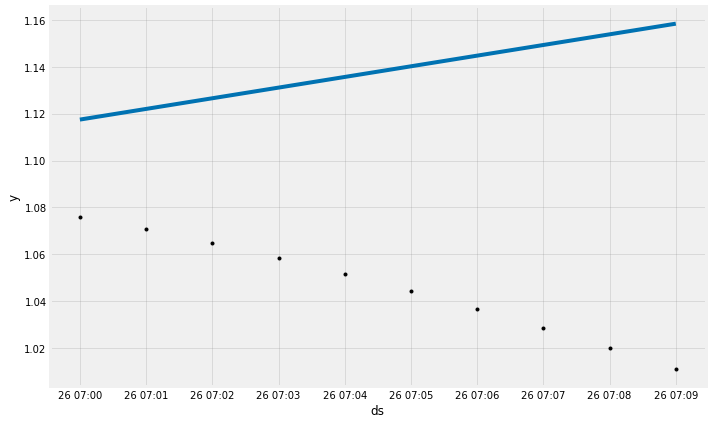

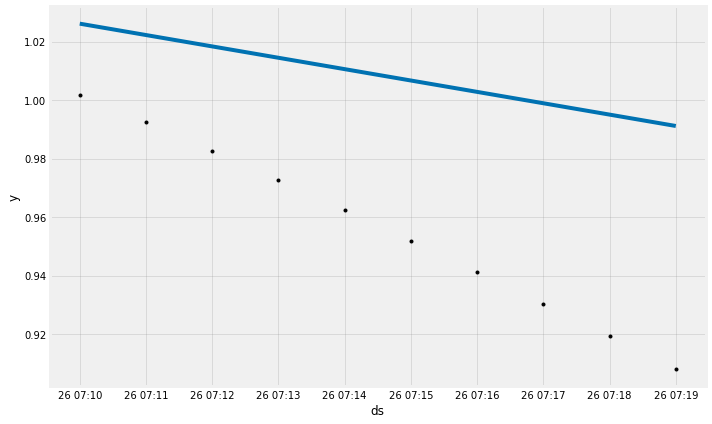

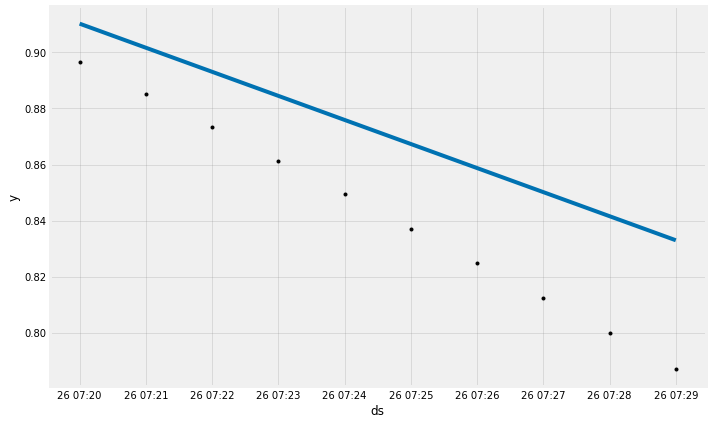

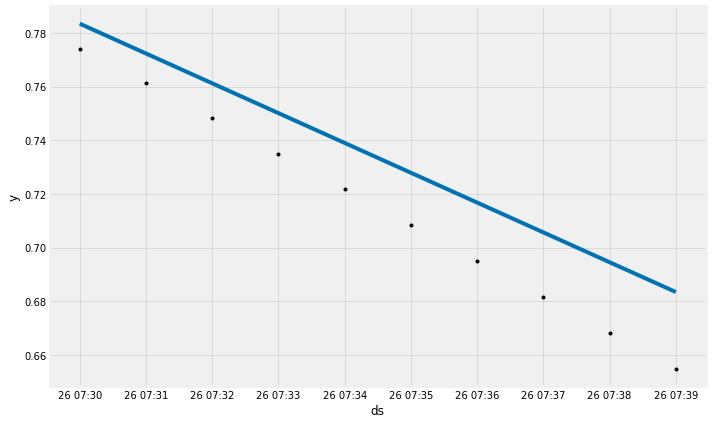

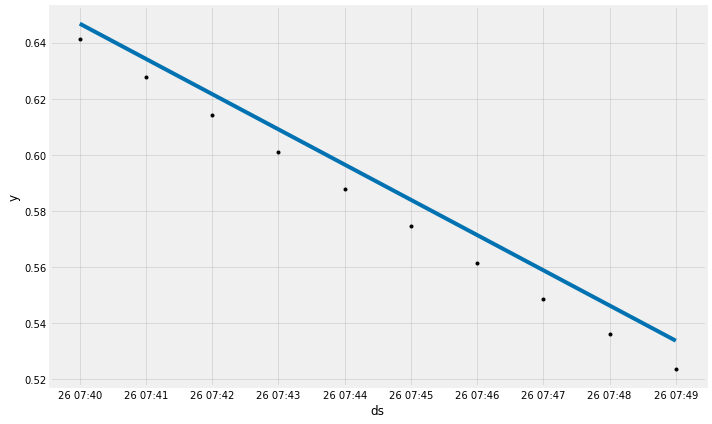

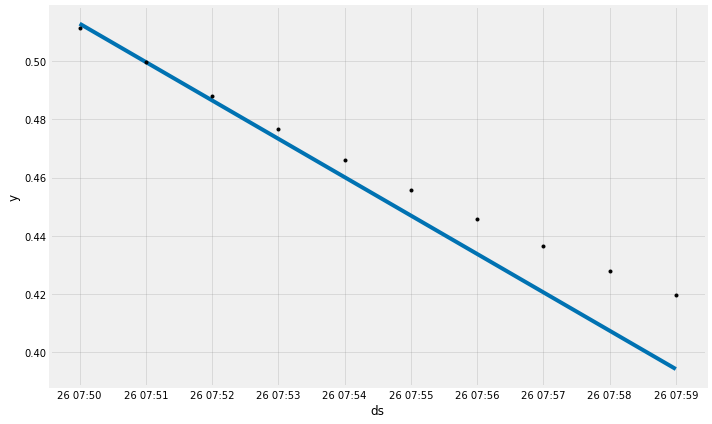

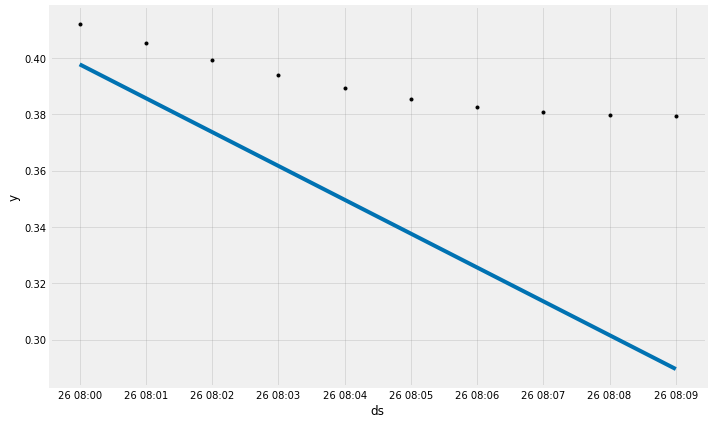

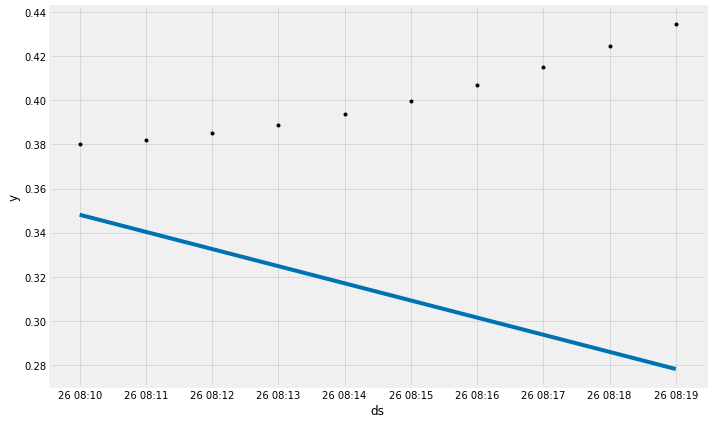

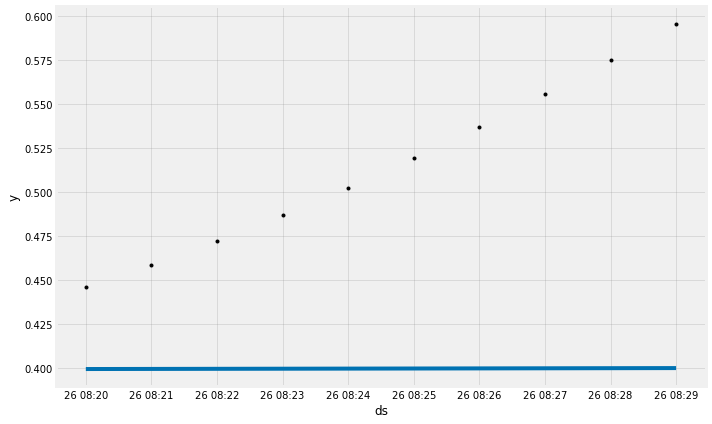

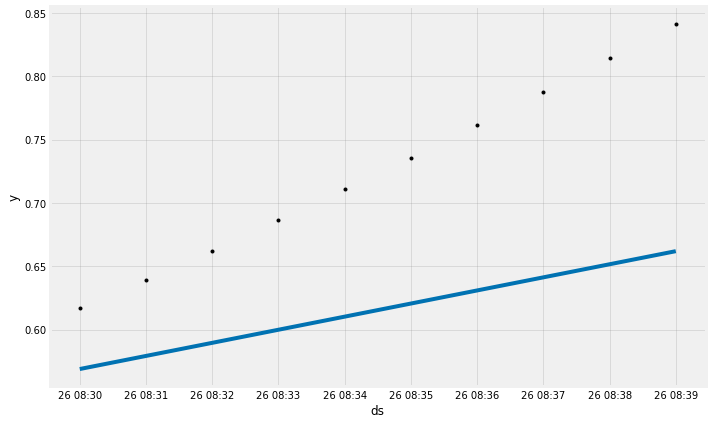

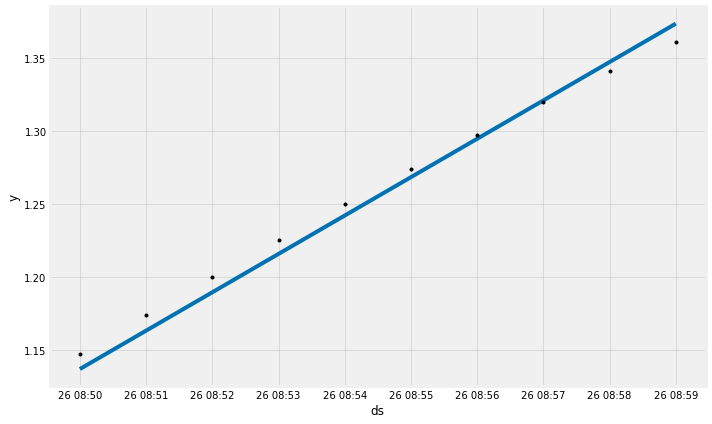

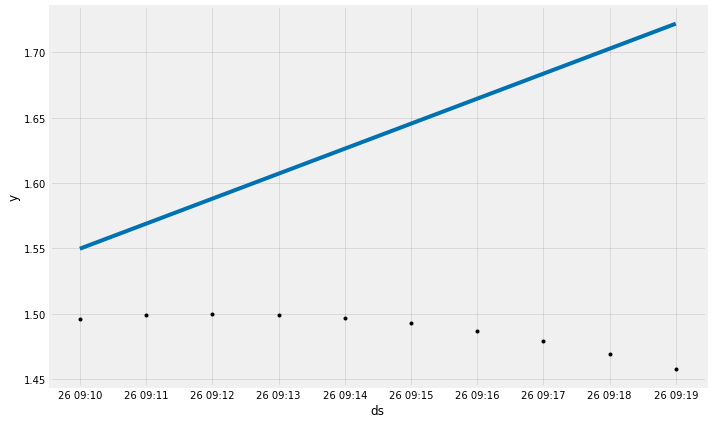

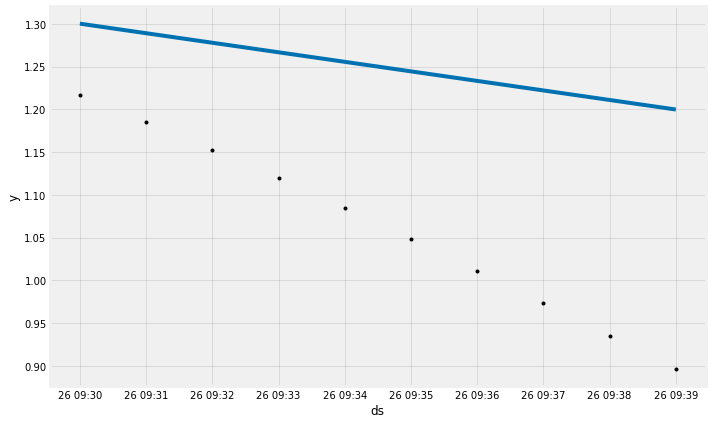

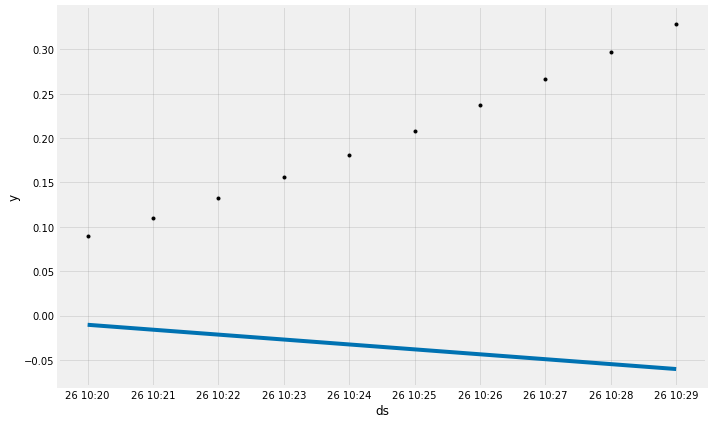

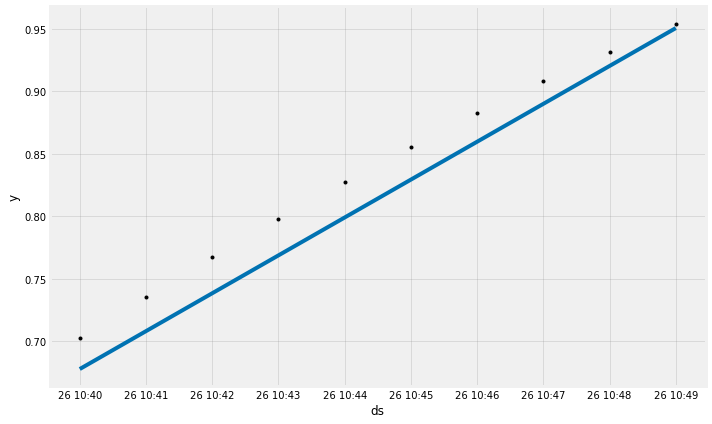

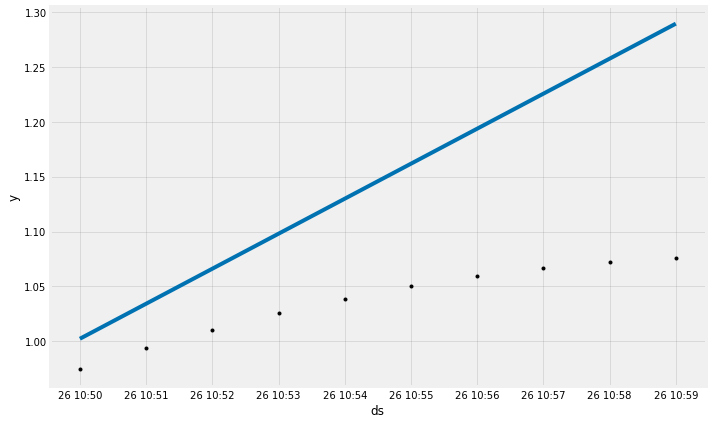

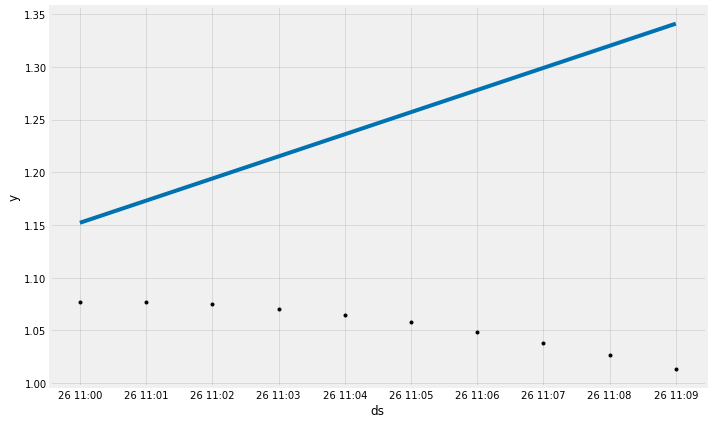

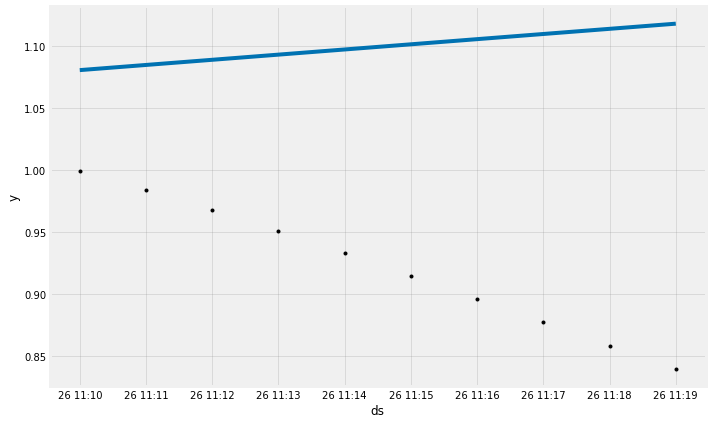

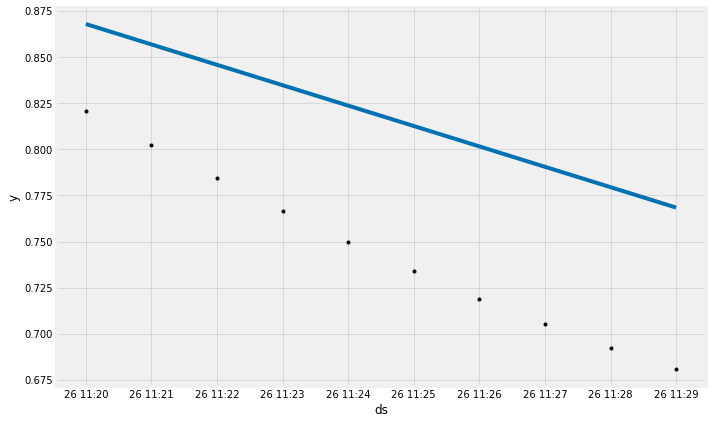

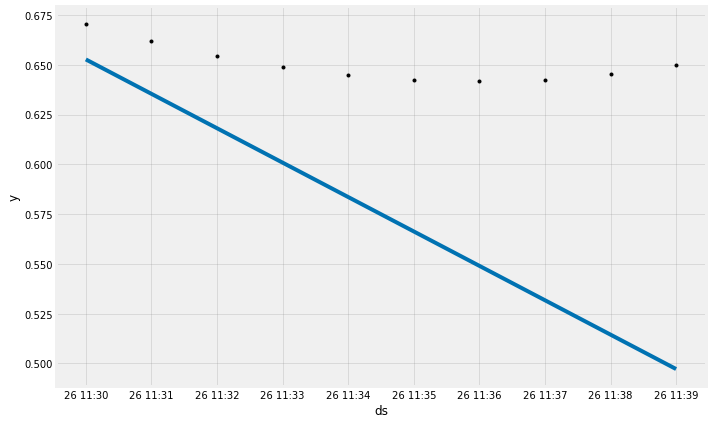

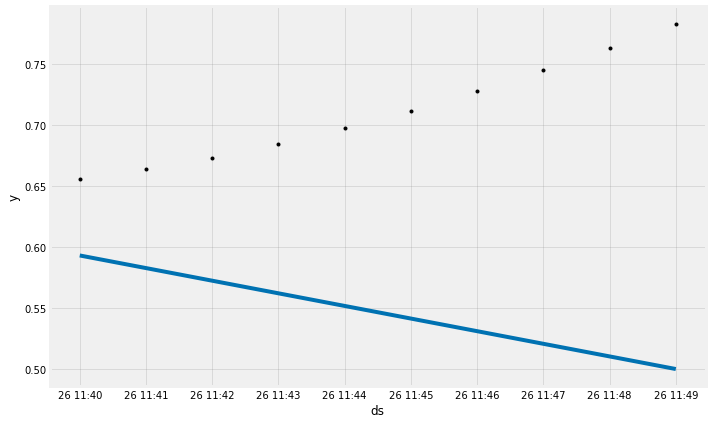

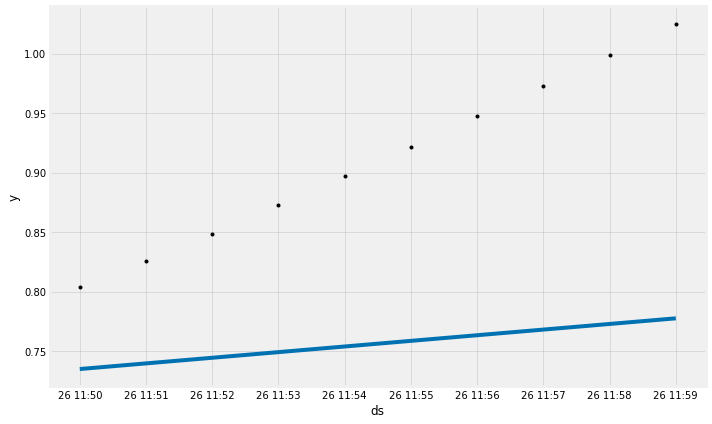

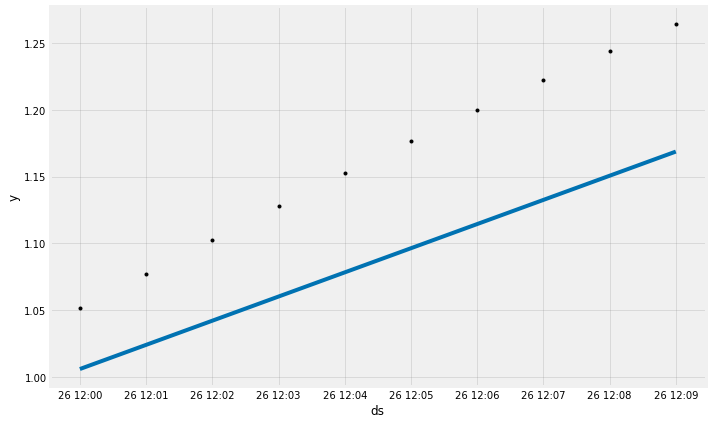

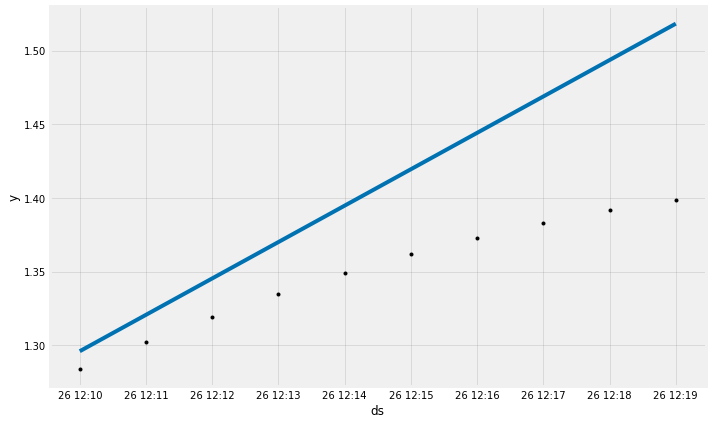

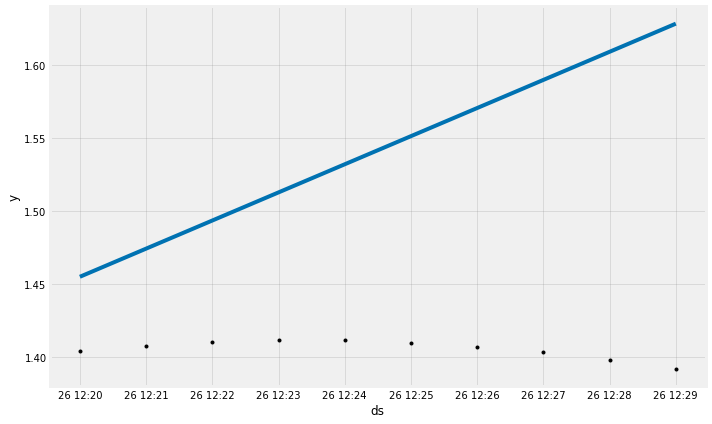

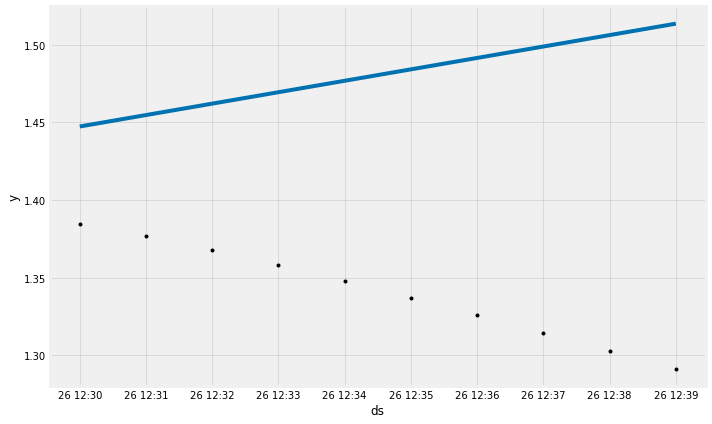

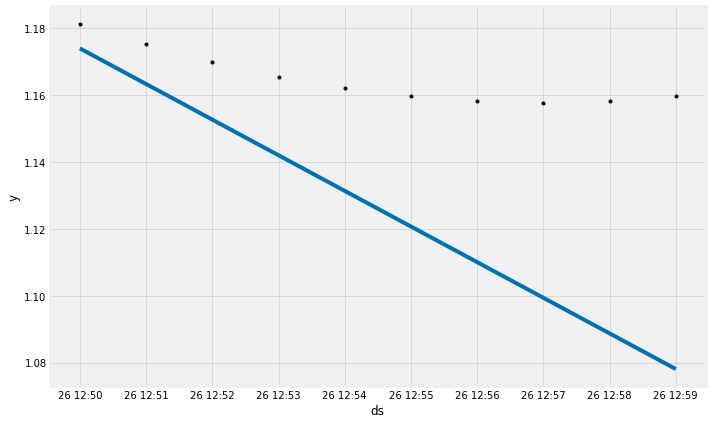

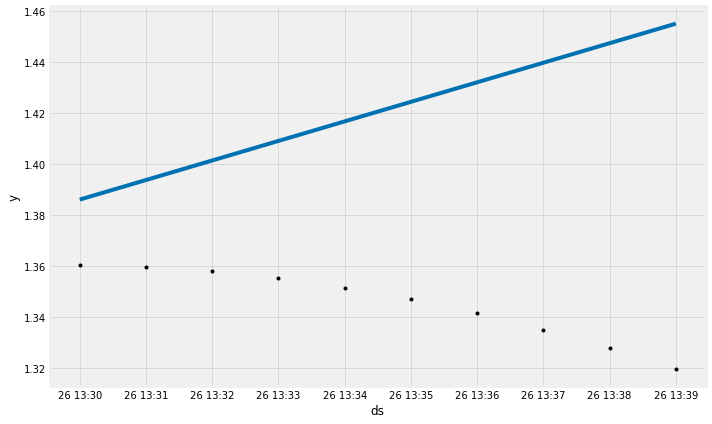

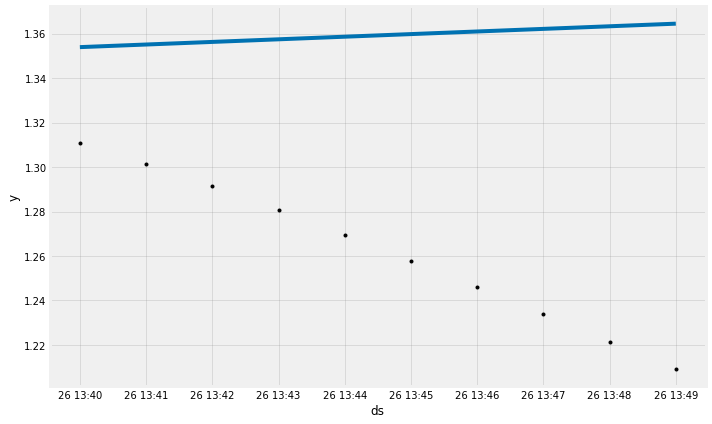

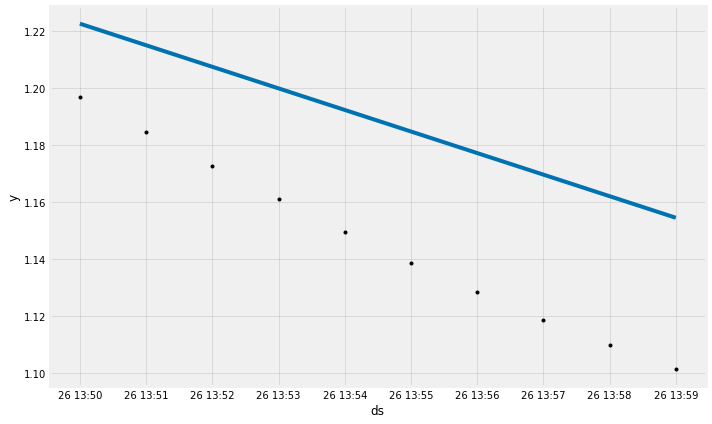

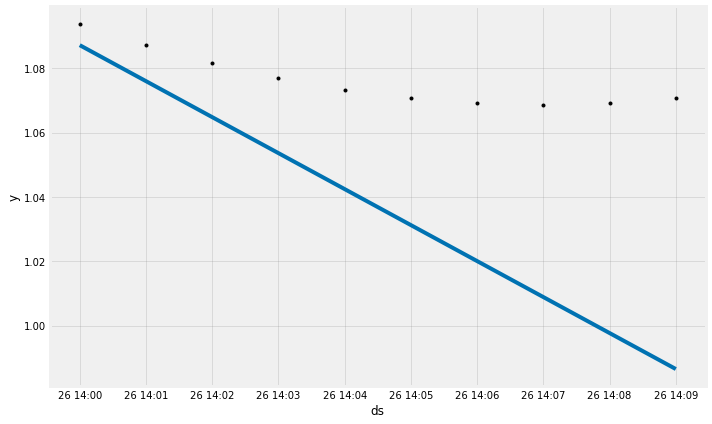

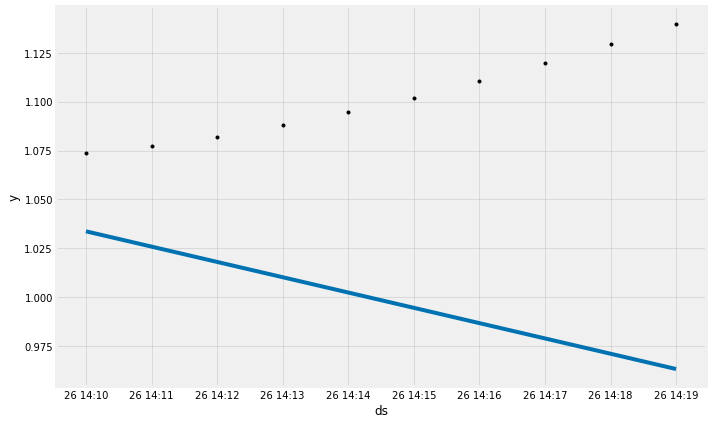

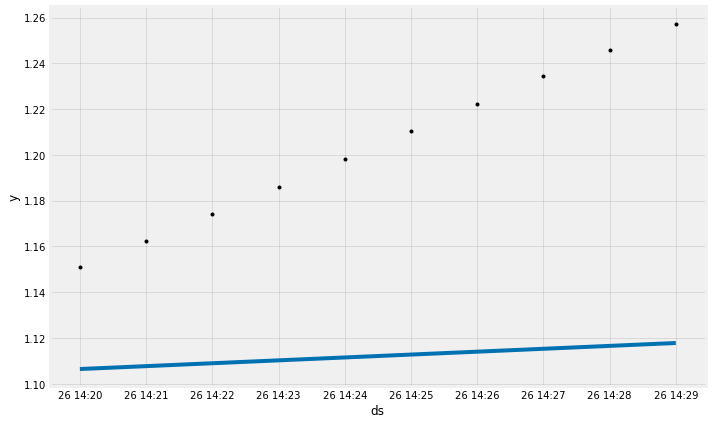

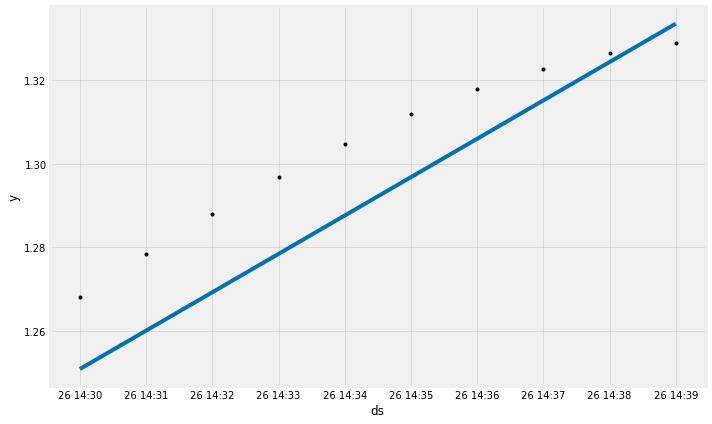

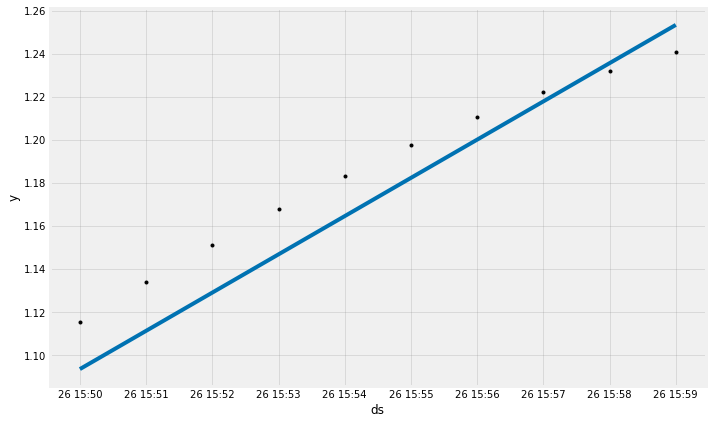

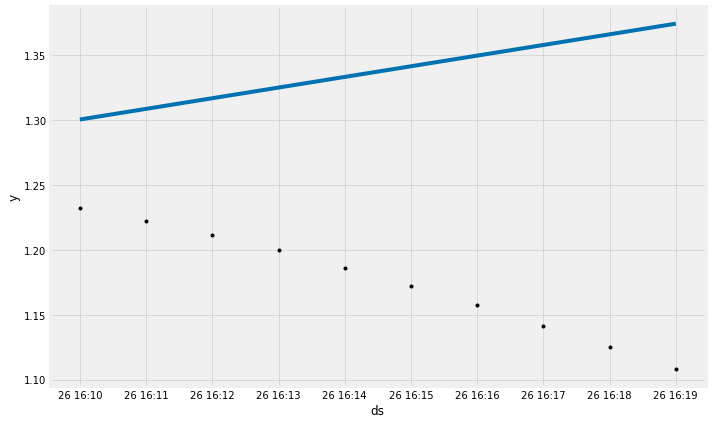

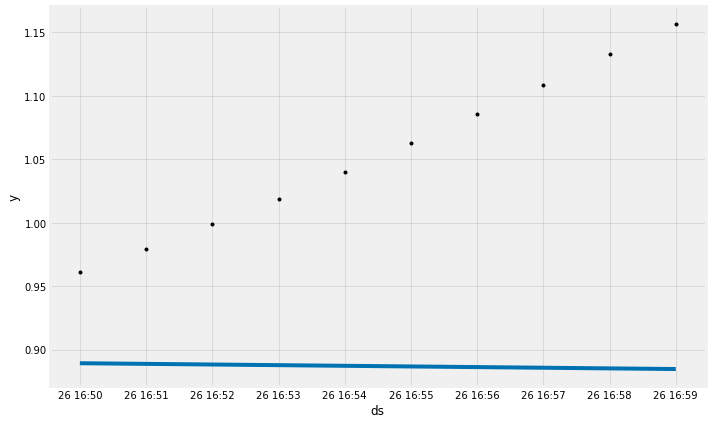

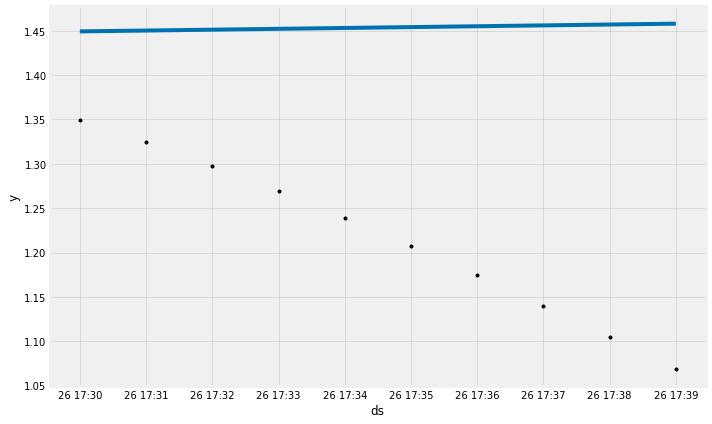

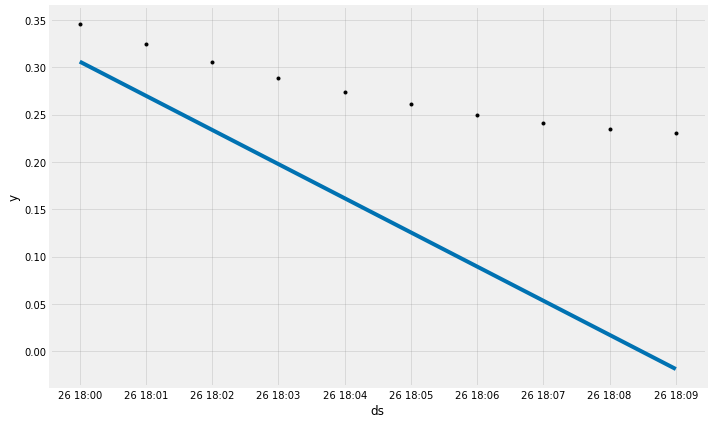

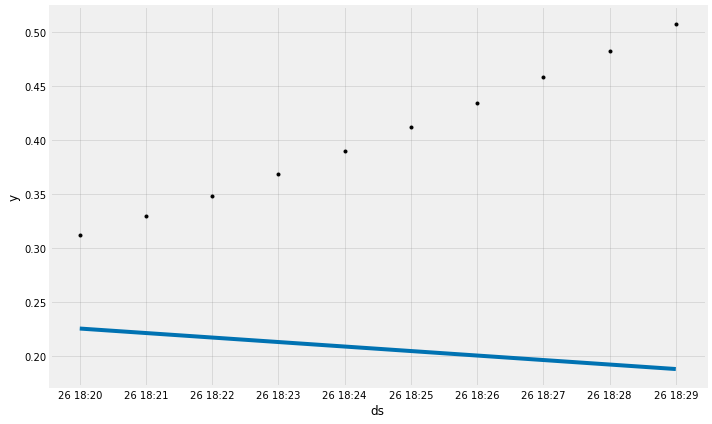

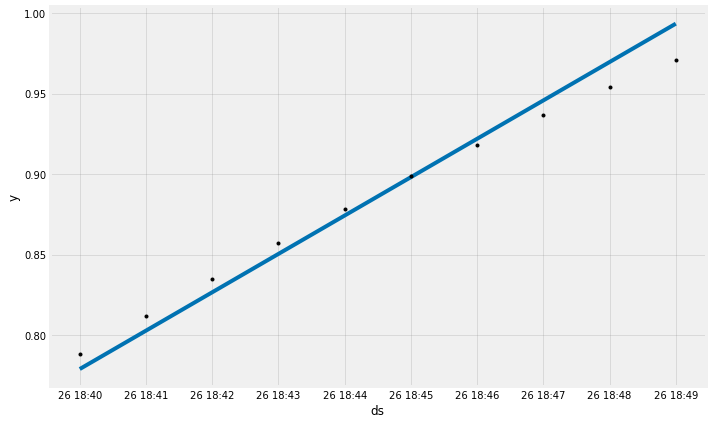

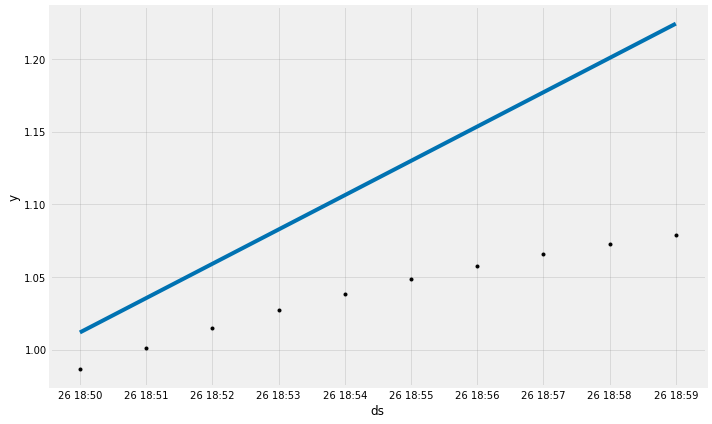

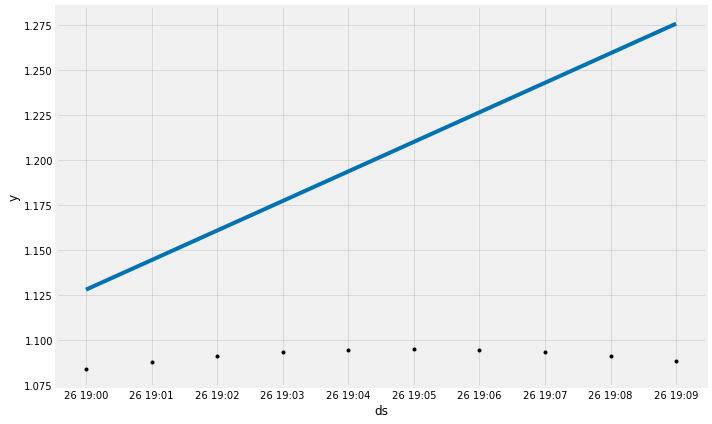

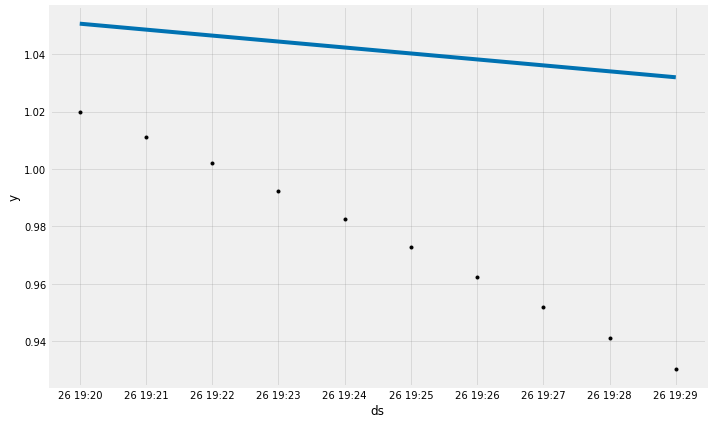

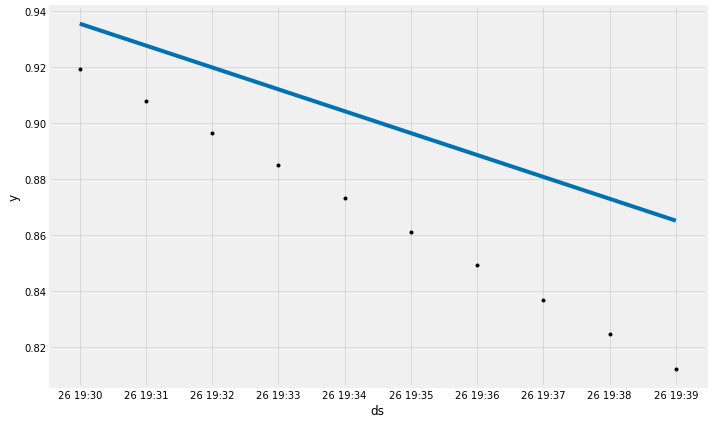

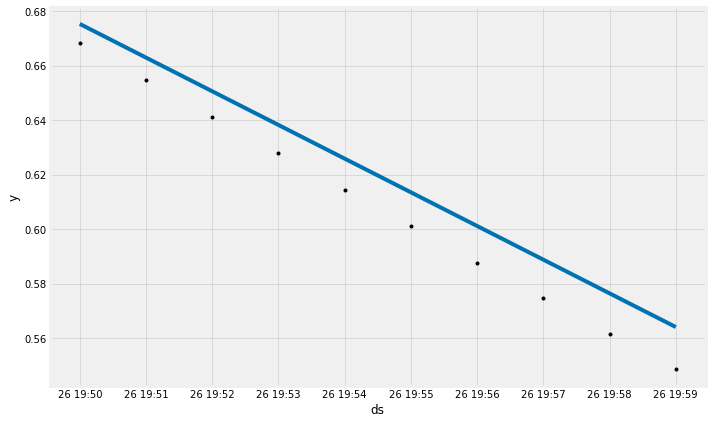

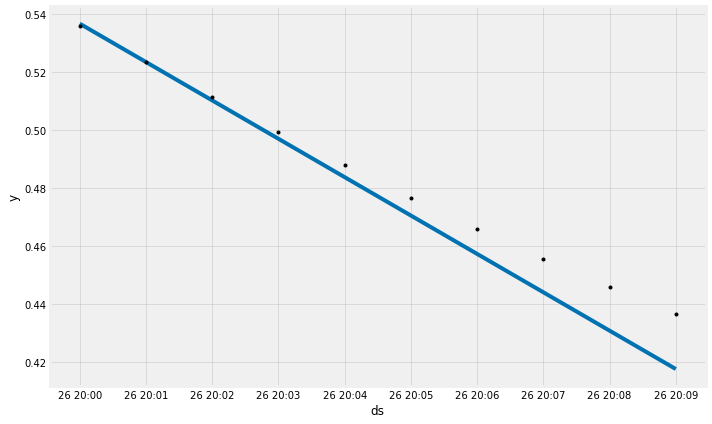

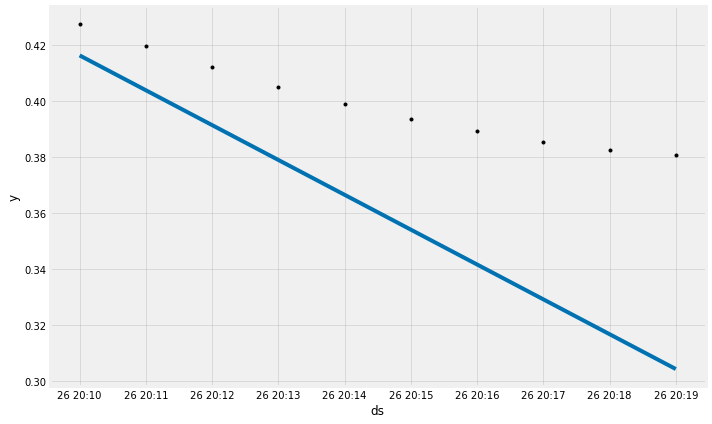

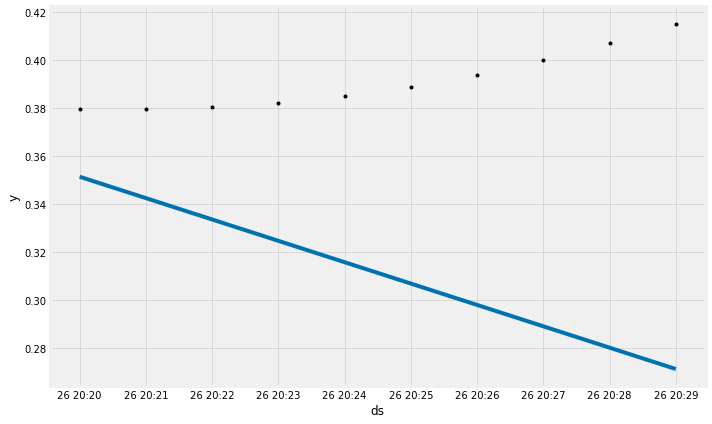

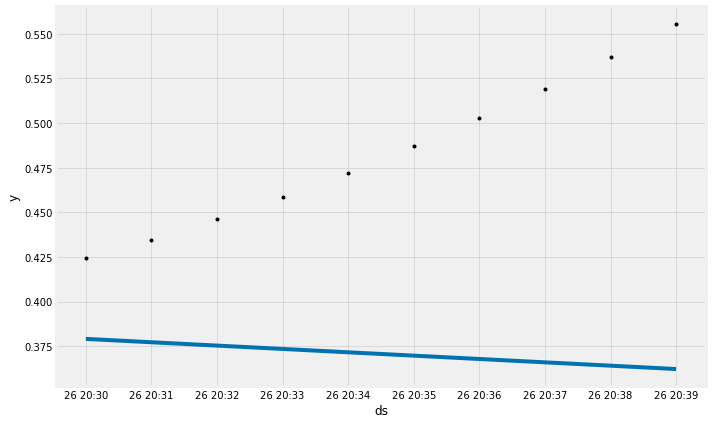

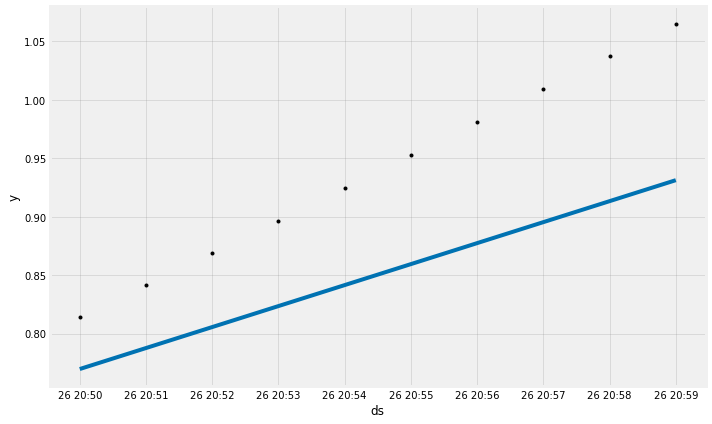

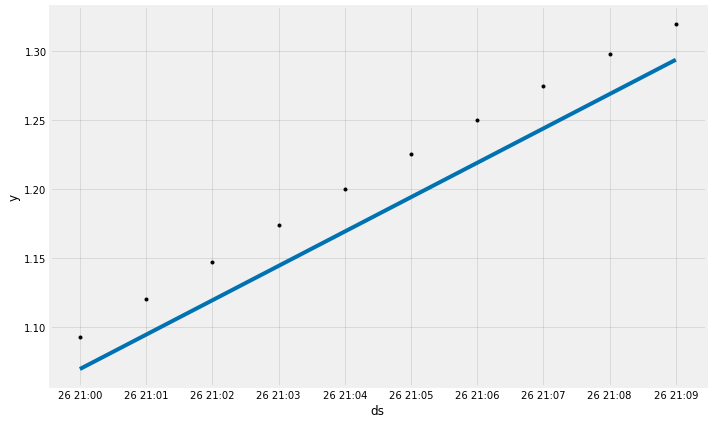

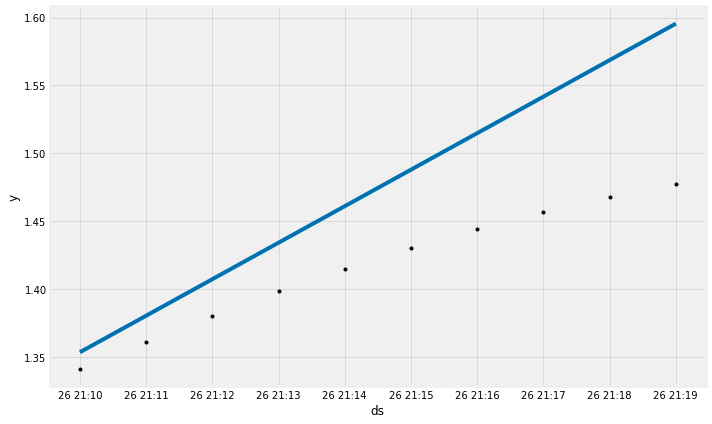

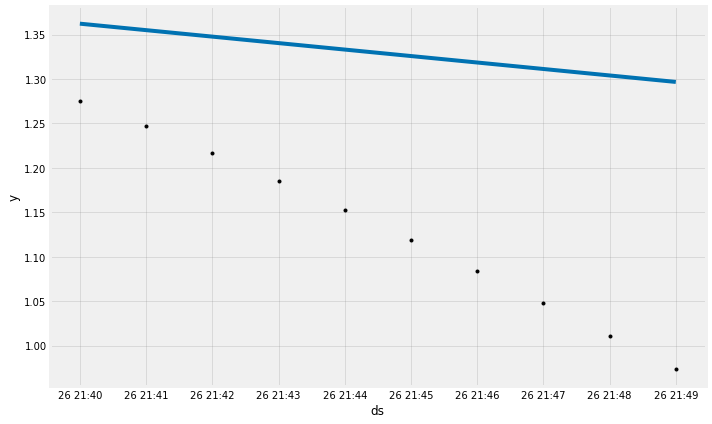

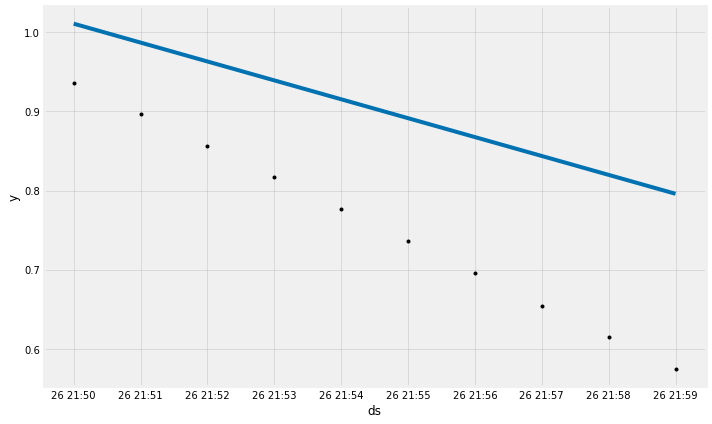

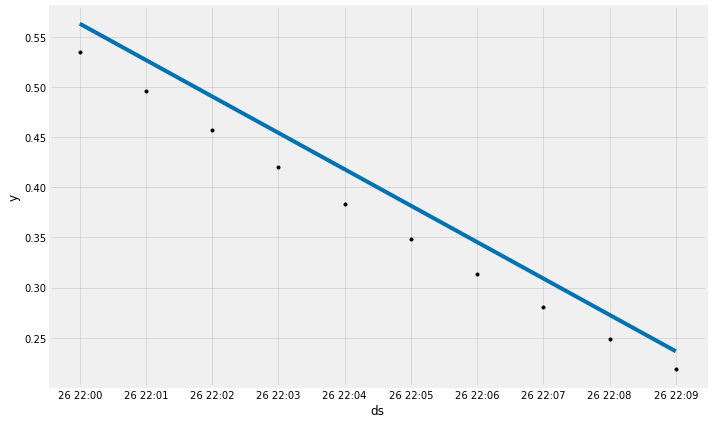

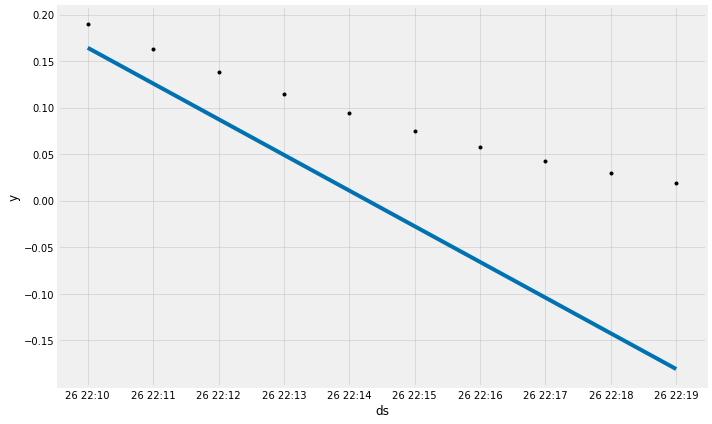

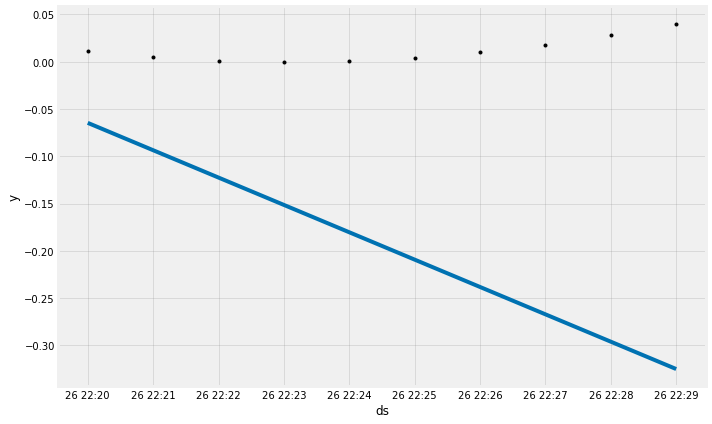

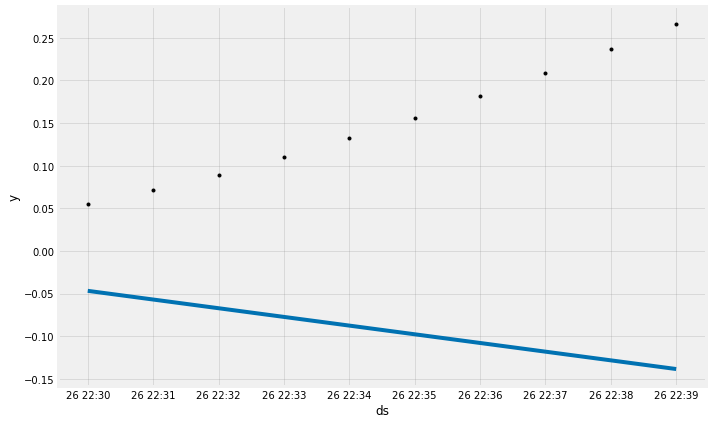

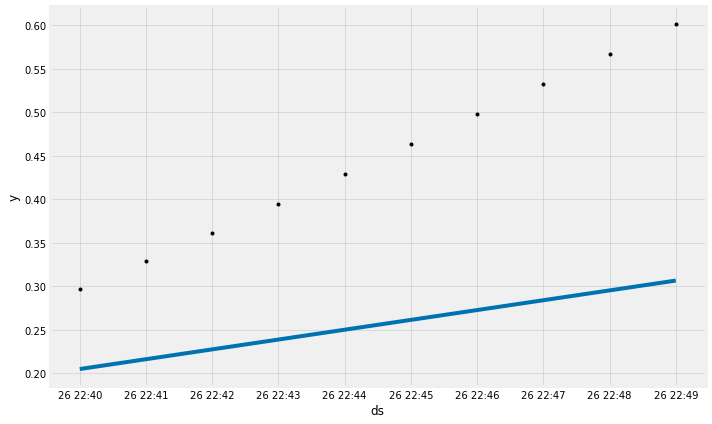

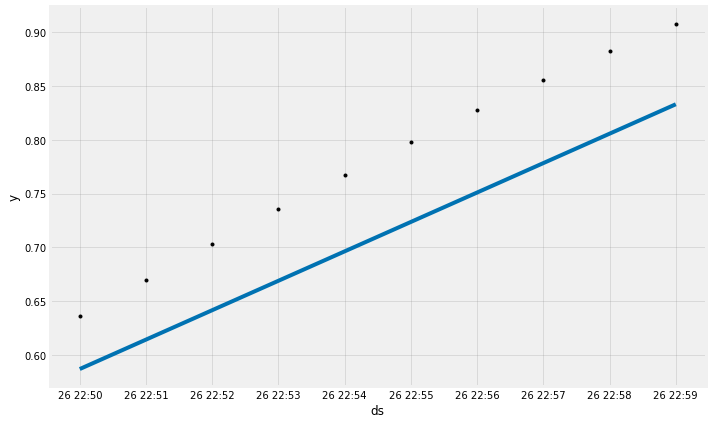

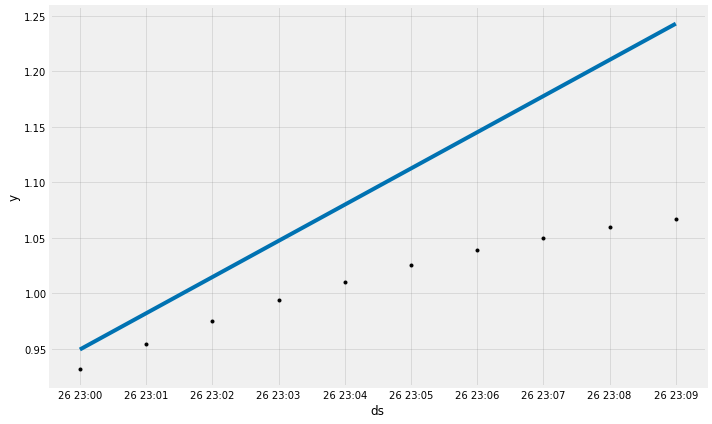

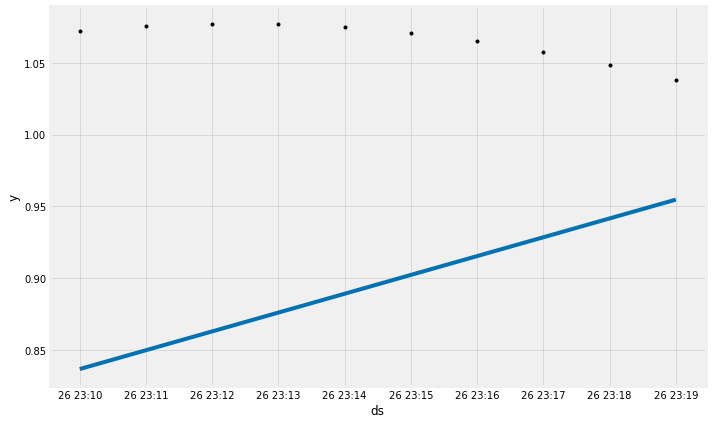

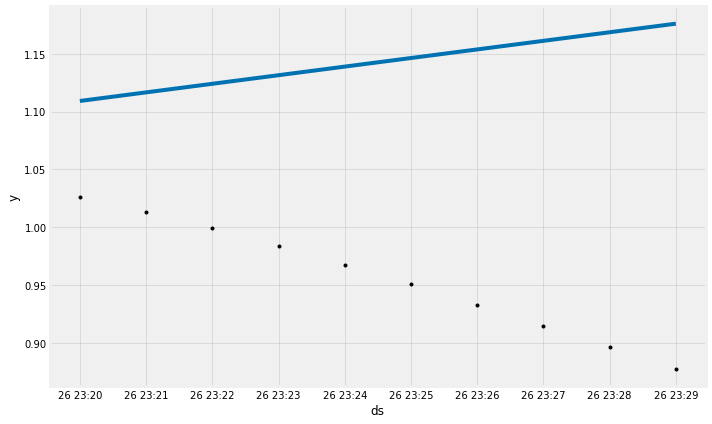

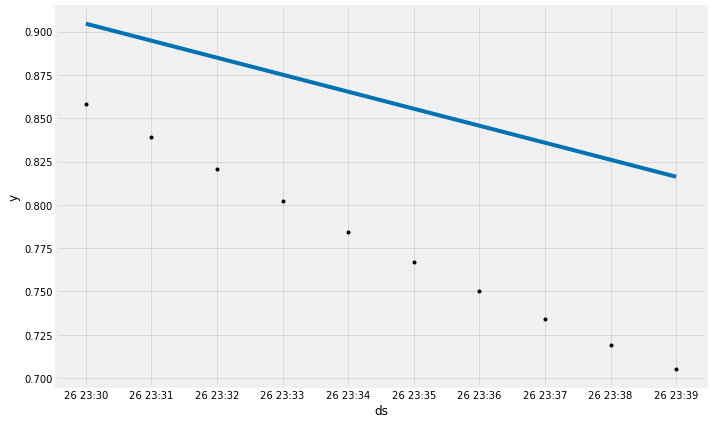

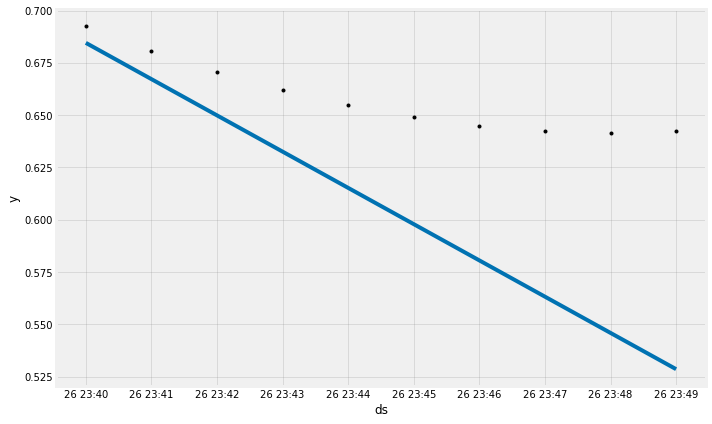

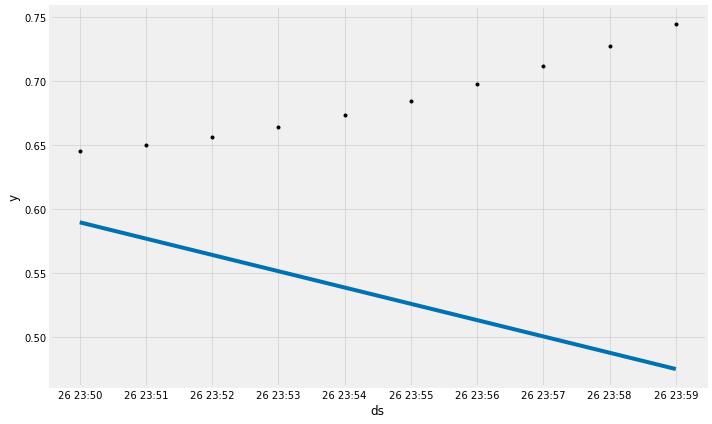

In [11]:
## Neural Prophet Trend
max_interval = 100
total_forecast1 = None
one_step_len = 10
n_loops = (len(df) // one_step_len) - 1
print(n_loops)
for i1 in range(n_loops): # 39 for normal period and 59 for all
    i = i1 * one_step_len
    #df_train1, df_val1 = df[0:i+one_step_len].copy(), df[i+one_step_len: i + one_step_len*2].copy().reset_index()
    df_train1, df_val1 = df[max(0, i + one_step_len - max_interval):i+one_step_len].copy(), df[i+one_step_len: i + one_step_len*2].copy().reset_index()
    m = NeuralProphet(
        n_changepoints=600,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
    )
    train_metrics = m.fit(df_train1, freq="1MIN", )
    future1 = m.make_future_dataframe(df_train1, periods=one_step_len,n_historic_predictions=0)
    future_forecast1 = m.predict(future1)
    future_forecast1['y'] = df_val1['y']
    m.plot(future_forecast1)
    if total_forecast1 is None:
        total_forecast1 = future_forecast1.copy()
    else:
        total_forecast1 = pd.concat([total_forecast1,future_forecast1.copy()])
total_forecast1 = total_forecast1.reset_index()

In [12]:
p = m.plot(total_forecast1)

In [13]:
total_forecast1

index                  ds         y     yhat1 residual1     trend
0         0 2021-07-26 00:10:00  1.410571  1.412647       NaN  1.412647
1         1 2021-07-26 00:11:00  1.411748  1.417136       NaN  1.417136
2         2 2021-07-26 00:12:00  1.411552  1.421625       NaN  1.421625
3         3 2021-07-26 00:13:00  1.410031  1.426115       NaN  1.426115
4         4 2021-07-26 00:14:00  1.407241  1.430604       NaN  1.430604
...     ...                 ...       ...       ...       ...       ...
1425      5 2021-07-26 23:55:00  0.684520  0.526006       NaN  0.526006
1426      6 2021-07-26 23:56:00  0.697308  0.513282       NaN  0.513282
1427      7 2021-07-26 23:57:00  0.711640  0.500557       NaN  0.500557
1428      8 2021-07-26 23:58:00  0.727450  0.487833       NaN  0.487833
1429      9 2021-07-26 23:59:00  0.744666  0.475108       NaN  0.475108

[1430 rows x 6 columns]

In [18]:
## Neural Prophet AR-Net
max_interval =500
total_forecast2 = None
one_step_len = 10
n_loops = (len(df) // one_step_len) - 1
print(n_loops)

for i1 in range(5, n_loops): # 39 for normal period and 59 for all
    i = i1 * one_step_len
    df_train1, df_val1 = df[0:i+one_step_len].copy(), df[i+one_step_len: i + one_step_len*2].copy()
    n_lags = min(max_interval ,len(df_train1)-one_step_len)
    m = NeuralProphet(
        n_forecasts=one_step_len,
        n_lags = n_lags,
        num_hidden_layers=2,
        ar_sparsity=0.05,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    train_metrics = m.fit(df_train1, freq="1MIN", )
    future2 = m.make_future_dataframe(df_train1, periods=one_step_len,n_historic_predictions=0)
    future_forecast2 = m.predict(future2)
    future_forecast2 = future_forecast2[n_lags: n_lags + one_step_len].copy()
    future_forecast2['y'] = list(df_val1['y'])
    print(future_forecast2)
    if total_forecast2 is None:
        total_forecast2 = future_forecast2.copy()
    else:
        total_forecast2 = pd.concat([total_forecast2,future_forecast2.copy()])
total_forecast2 = total_forecast2.reset_index()

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 266
INFO:nprophet.config:Auto-set epochs to 266


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-02
INFO:nprophet:learning rate range test found optimal lr: 2.85E-02


143


Epoch[266/266]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:01<00:00, 203.99it/s, SmoothL1Loss=2.76e-6, MAE=0.000596, RegLoss=0.182]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 228
INFO:nprophet.config:Auto-set epochs to 228


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-02
INFO:nprophet:learning rate range test found optimal lr: 2.85E-02


                    ds         y     yhat1 residual1     yhat2 residual2  \
50 2021-07-26 01:00:00  1.246153  1.141326       NaN      None       NaN   
51 2021-07-26 01:01:00  1.255786      None       NaN  1.093481       NaN   
52 2021-07-26 01:02:00  1.265448      None       NaN      None       NaN   
53 2021-07-26 01:03:00  1.275053      None       NaN      None       NaN   
54 2021-07-26 01:04:00  1.284515      None       NaN      None       NaN   
55 2021-07-26 01:05:00  1.293751      None       NaN      None       NaN   
56 2021-07-26 01:06:00  1.302677      None       NaN      None       NaN   
57 2021-07-26 01:07:00  1.311213      None       NaN      None       NaN   
58 2021-07-26 01:08:00  1.319281      None       NaN      None       NaN   
59 2021-07-26 01:09:00  1.326809      None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2      ar3       ar4  \
50      None       NaN      None       NaN  ...      None     None      None   
51 

Epoch[228/228]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 229.80it/s, SmoothL1Loss=3.79e-6, MAE=0.000728, RegLoss=0.182]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 200
INFO:nprophet.config:Auto-set epochs to 200


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-02
INFO:nprophet:learning rate range test found optimal lr: 1.23E-02


                    ds         y     yhat1 residual1     yhat2 residual2  \
60 2021-07-26 01:10:00  1.333727  1.198304       NaN      None       NaN   
61 2021-07-26 01:11:00  1.339971      None       NaN  1.148787       NaN   
62 2021-07-26 01:12:00  1.345481      None       NaN      None       NaN   
63 2021-07-26 01:13:00  1.350203      None       NaN      None       NaN   
64 2021-07-26 01:14:00  1.354090      None       NaN      None       NaN   
65 2021-07-26 01:15:00  1.357101      None       NaN      None       NaN   
66 2021-07-26 01:16:00  1.359201      None       NaN      None       NaN   
67 2021-07-26 01:17:00  1.360364      None       NaN      None       NaN   
68 2021-07-26 01:18:00  1.360569      None       NaN      None       NaN   
69 2021-07-26 01:19:00  1.359804      None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2       ar3       ar4  \
60      None       NaN      None       NaN  ...      None      None      None   
6

Epoch[200/200]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 203.15it/s, SmoothL1Loss=2.19e-6, MAE=0.000572, RegLoss=0.162]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 177
INFO:nprophet.config:Auto-set epochs to 177


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-02
INFO:nprophet:learning rate range test found optimal lr: 1.23E-02


                    ds         y     yhat1 residual1    yhat2 residual2  \
70 2021-07-26 01:20:00  1.358064  1.391448       NaN     None       NaN   
71 2021-07-26 01:21:00  1.355352      None       NaN  1.29856       NaN   
72 2021-07-26 01:22:00  1.351678      None       NaN     None       NaN   
73 2021-07-26 01:23:00  1.347060      None       NaN     None       NaN   
74 2021-07-26 01:24:00  1.341523      None       NaN     None       NaN   
75 2021-07-26 01:25:00  1.335099      None       NaN     None       NaN   
76 2021-07-26 01:26:00  1.327828      None       NaN     None       NaN   
77 2021-07-26 01:27:00  1.319757      None       NaN     None       NaN   
78 2021-07-26 01:28:00  1.310938      None       NaN     None       NaN   
79 2021-07-26 01:29:00  1.301428      None       NaN     None       NaN   

       yhat3 residual3    yhat4 residual4  ...      ar2      ar3       ar4  \
70      None       NaN     None       NaN  ...     None     None      None   
71      None      

Epoch[177/177]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 195.22it/s, SmoothL1Loss=1.49e-6, MAE=0.000462, RegLoss=0.158]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 320
INFO:nprophet.config:Auto-set epochs to 320


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-02
INFO:nprophet:learning rate range test found optimal lr: 1.23E-02


                    ds         y     yhat1 residual1     yhat2 residual2  \
80 2021-07-26 01:30:00  1.291294  1.301142       NaN      None       NaN   
81 2021-07-26 01:31:00  1.280604      None       NaN  1.353435       NaN   
82 2021-07-26 01:32:00  1.269431      None       NaN      None       NaN   
83 2021-07-26 01:33:00  1.257854      None       NaN      None       NaN   
84 2021-07-26 01:34:00  1.245954      None       NaN      None       NaN   
85 2021-07-26 01:35:00  1.233816      None       NaN      None       NaN   
86 2021-07-26 01:36:00  1.221526      None       NaN      None       NaN   
87 2021-07-26 01:37:00  1.209173      None       NaN      None       NaN   
88 2021-07-26 01:38:00  1.196844      None       NaN      None       NaN   
89 2021-07-26 01:39:00  1.184631      None       NaN      None       NaN   

      yhat3 residual3     yhat4 residual4  ...       ar2       ar3       ar4  \
80     None       NaN      None       NaN  ...      None      None      None   
81 

Epoch[320/320]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:01<00:00, 189.81it/s, SmoothL1Loss=3.22e-7, MAE=0.000211, RegLoss=0.156]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 290
INFO:nprophet.config:Auto-set epochs to 290


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-02
INFO:nprophet:learning rate range test found optimal lr: 1.00E-02


                    ds         y     yhat1 residual1     yhat2 residual2  \
90 2021-07-26 01:40:00  1.172621  1.307789       NaN      None       NaN   
91 2021-07-26 01:41:00  1.160902      None       NaN  1.262515       NaN   
92 2021-07-26 01:42:00  1.149562      None       NaN      None       NaN   
93 2021-07-26 01:43:00  1.138682      None       NaN      None       NaN   
94 2021-07-26 01:44:00  1.128345      None       NaN      None       NaN   
95 2021-07-26 01:45:00  1.118626      None       NaN      None       NaN   
96 2021-07-26 01:46:00  1.109599      None       NaN      None       NaN   
97 2021-07-26 01:47:00  1.101331      None       NaN      None       NaN   
98 2021-07-26 01:48:00  1.093885      None       NaN      None       NaN   
99 2021-07-26 01:49:00  1.087317      None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2       ar3       ar4  \
90      None       NaN      None       NaN  ...      None      None      None   
9

Epoch[290/290]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:01<00:00, 147.47it/s, SmoothL1Loss=6.7e-7, MAE=0.000366, RegLoss=0.157]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 266
INFO:nprophet.config:Auto-set epochs to 266


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-02
INFO:nprophet:learning rate range test found optimal lr: 1.87E-02


                     ds         y     yhat1 residual1     yhat2 residual2  \
100 2021-07-26 01:50:00  1.081678  1.318301       NaN      None       NaN   
101 2021-07-26 01:51:00  1.077010      None       NaN  1.218625       NaN   
102 2021-07-26 01:52:00  1.073349      None       NaN      None       NaN   
103 2021-07-26 01:53:00  1.070726      None       NaN      None       NaN   
104 2021-07-26 01:54:00  1.069160      None       NaN      None       NaN   
105 2021-07-26 01:55:00  1.068664      None       NaN      None       NaN   
106 2021-07-26 01:56:00  1.069244      None       NaN      None       NaN   
107 2021-07-26 01:57:00  1.070895      None       NaN      None       NaN   
108 2021-07-26 01:58:00  1.073607      None       NaN      None       NaN   
109 2021-07-26 01:59:00  1.077360      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3      ar4  \
100      None       NaN      None       NaN  ...      None      None   

Epoch[266/266]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:02<00:00, 127.49it/s, SmoothL1Loss=4.59e-7, MAE=0.000332, RegLoss=0.172]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 246
INFO:nprophet.config:Auto-set epochs to 246


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
110 2021-07-26 02:00:00  1.082126  1.197317       NaN      None       NaN   
111 2021-07-26 02:01:00  1.087868      None       NaN  1.152141       NaN   
112 2021-07-26 02:02:00  1.094543      None       NaN      None       NaN   
113 2021-07-26 02:03:00  1.102100      None       NaN      None       NaN   
114 2021-07-26 02:04:00  1.110481      None       NaN      None       NaN   
115 2021-07-26 02:05:00  1.119618      None       NaN      None       NaN   
116 2021-07-26 02:06:00  1.129442      None       NaN      None       NaN   
117 2021-07-26 02:07:00  1.139873      None       NaN      None       NaN   
118 2021-07-26 02:08:00  1.150829      None       NaN      None       NaN   
119 2021-07-26 02:09:00  1.162221      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
110      None       NaN      None       NaN  ...      None      None   
111     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-02
INFO:nprophet:learning rate range test found optimal lr: 1.52E-02
Epoch[246/246]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:02<00:00, 117.96it/s, SmoothL1Loss=8.41e-7, MAE=0.000449, RegLoss=0.167]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 228
INFO:nprophet.config:Auto-set epochs to 228


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
120 2021-07-26 02:10:00  1.173956  1.222479       NaN      None       NaN   
121 2021-07-26 02:11:00  1.185938      None       NaN  1.280495       NaN   
122 2021-07-26 02:12:00  1.198068      None       NaN      None       NaN   
123 2021-07-26 02:13:00  1.210244      None       NaN      None       NaN   
124 2021-07-26 02:14:00  1.222362      None       NaN      None       NaN   
125 2021-07-26 02:15:00  1.234318      None       NaN      None       NaN   
126 2021-07-26 02:16:00  1.246008      None       NaN      None       NaN   
127 2021-07-26 02:17:00  1.257326      None       NaN      None       NaN   
128 2021-07-26 02:18:00  1.268171      None       NaN      None       NaN   
129 2021-07-26 02:19:00  1.278442      None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2      ar3       ar4  \
120      None       NaN     None       NaN  ...      None     None      

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-03
INFO:nprophet:learning rate range test found optimal lr: 8.11E-03
Epoch[228/228]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:01<00:00, 122.89it/s, SmoothL1Loss=2.62e-7, MAE=0.000229, RegLoss=0.154]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 213
INFO:nprophet.config:Auto-set epochs to 213


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
130 2021-07-26 02:20:00  1.288040  1.183333       NaN      None       NaN   
131 2021-07-26 02:21:00  1.296871      None       NaN  1.180674       NaN   
132 2021-07-26 02:22:00  1.304844      None       NaN      None       NaN   
133 2021-07-26 02:23:00  1.311874      None       NaN      None       NaN   
134 2021-07-26 02:24:00  1.317880      None       NaN      None       NaN   
135 2021-07-26 02:25:00  1.322788      None       NaN      None       NaN   
136 2021-07-26 02:26:00  1.326532      None       NaN      None       NaN   
137 2021-07-26 02:27:00  1.329049      None       NaN      None       NaN   
138 2021-07-26 02:28:00  1.330288      None       NaN      None       NaN   
139 2021-07-26 02:29:00  1.330203      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
130      None       NaN      None       NaN  ...      None      None   
131     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-02
INFO:nprophet:learning rate range test found optimal lr: 1.23E-02
Epoch[213/213]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [00:01<00:00, 121.56it/s, SmoothL1Loss=5.42e-7, MAE=0.000336, RegLoss=0.16]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 200
INFO:nprophet.config:Auto-set epochs to 200


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
140 2021-07-26 02:30:00  1.328760  1.253188       NaN      None       NaN   
141 2021-07-26 02:31:00  1.325929      None       NaN  1.344743       NaN   
142 2021-07-26 02:32:00  1.321693      None       NaN      None       NaN   
143 2021-07-26 02:33:00  1.316042      None       NaN      None       NaN   
144 2021-07-26 02:34:00  1.308977      None       NaN      None       NaN   
145 2021-07-26 02:35:00  1.300508      None       NaN      None       NaN   
146 2021-07-26 02:36:00  1.290653      None       NaN      None       NaN   
147 2021-07-26 02:37:00  1.279440      None       NaN      None       NaN   
148 2021-07-26 02:38:00  1.266909      None       NaN      None       NaN   
149 2021-07-26 02:39:00  1.253106      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
140      None       NaN      None       NaN  ...      None      None   
141     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-02
INFO:nprophet:learning rate range test found optimal lr: 1.52E-02
Epoch[200/200]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 120.96it/s, SmoothL1Loss=5.53e-7, MAE=0.000303, RegLoss=0.164]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 188
INFO:nprophet.config:Auto-set epochs to 188


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
150 2021-07-26 02:40:00  1.238086  1.273119       NaN      None       NaN   
151 2021-07-26 02:41:00  1.221915      None       NaN  1.297037       NaN   
152 2021-07-26 02:42:00  1.204665      None       NaN      None       NaN   
153 2021-07-26 02:43:00  1.186417      None       NaN      None       NaN   
154 2021-07-26 02:44:00  1.167258      None       NaN      None       NaN   
155 2021-07-26 02:45:00  1.147284      None       NaN      None       NaN   
156 2021-07-26 02:46:00  1.126595      None       NaN      None       NaN   
157 2021-07-26 02:47:00  1.105299      None       NaN      None       NaN   
158 2021-07-26 02:48:00  1.083505      None       NaN      None       NaN   
159 2021-07-26 02:49:00  1.061332      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2      ar3       ar4  \
150      None       NaN      None       NaN  ...      None     None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-02
INFO:nprophet:learning rate range test found optimal lr: 1.87E-02
Epoch[188/188]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 121.24it/s, SmoothL1Loss=5.5e-7, MAE=0.00029, RegLoss=0.173]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 177
INFO:nprophet.config:Auto-set epochs to 177


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-02
INFO:nprophet:learning rate range test found optimal lr: 1.23E-02


                     ds         y     yhat1 residual1     yhat2 residual2  \
160 2021-07-26 02:50:00  1.038897  1.179864       NaN      None       NaN   
161 2021-07-26 02:51:00  1.016323      None       NaN  1.066721       NaN   
162 2021-07-26 02:52:00  0.993735      None       NaN      None       NaN   
163 2021-07-26 02:53:00  0.971257      None       NaN      None       NaN   
164 2021-07-26 02:54:00  0.949015      None       NaN      None       NaN   
165 2021-07-26 02:55:00  0.927134      None       NaN      None       NaN   
166 2021-07-26 02:56:00  0.905740      None       NaN      None       NaN   
167 2021-07-26 02:57:00  0.884952      None       NaN      None       NaN   
168 2021-07-26 02:58:00  0.864892      None       NaN      None       NaN   
169 2021-07-26 02:59:00  0.845674      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
160      None       NaN      None       NaN  ...      None      None   
161     

Epoch[177/177]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:01<00:00, 129.23it/s, SmoothL1Loss=3.69e-6, MAE=0.00132, RegLoss=0.167]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 168
INFO:nprophet.config:Auto-set epochs to 168


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-03
INFO:nprophet:learning rate range test found optimal lr: 8.11E-03


                     ds         y     yhat1 residual1     yhat2 residual2  \
170 2021-07-26 03:00:00  0.827409  1.193869       NaN      None       NaN   
171 2021-07-26 03:01:00  0.810203      None       NaN  1.207155       NaN   
172 2021-07-26 03:02:00  0.794156      None       NaN      None       NaN   
173 2021-07-26 03:03:00  0.779362      None       NaN      None       NaN   
174 2021-07-26 03:04:00  0.765908      None       NaN      None       NaN   
175 2021-07-26 03:05:00  0.753871      None       NaN      None       NaN   
176 2021-07-26 03:06:00  0.743321      None       NaN      None       NaN   
177 2021-07-26 03:07:00  0.734321      None       NaN      None       NaN   
178 2021-07-26 03:08:00  0.726923      None       NaN      None       NaN   
179 2021-07-26 03:09:00  0.721169      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
170      None       NaN      None       NaN  ...      None      None   
171     

Epoch[168/168]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:01<00:00, 126.37it/s, SmoothL1Loss=1.96e-7, MAE=0.000446, RegLoss=0.155]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 160
INFO:nprophet.config:Auto-set epochs to 160


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-03
INFO:nprophet:learning rate range test found optimal lr: 8.11E-03


                     ds         y     yhat1 residual1     yhat2 residual2  \
180 2021-07-26 03:10:00  0.717092  0.789157       NaN      None       NaN   
181 2021-07-26 03:11:00  0.714715      None       NaN  0.736122       NaN   
182 2021-07-26 03:12:00  0.714050      None       NaN      None       NaN   
183 2021-07-26 03:13:00  0.715098      None       NaN      None       NaN   
184 2021-07-26 03:14:00  0.717852      None       NaN      None       NaN   
185 2021-07-26 03:15:00  0.722291      None       NaN      None       NaN   
186 2021-07-26 03:16:00  0.728387      None       NaN      None       NaN   
187 2021-07-26 03:17:00  0.736100      None       NaN      None       NaN   
188 2021-07-26 03:18:00  0.745380      None       NaN      None       NaN   
189 2021-07-26 03:19:00  0.756167      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
180      None       NaN      None       NaN  ...      None      None   
181     

Epoch[160/160]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:01<00:00, 132.44it/s, SmoothL1Loss=1.65e-6, MAE=0.0012, RegLoss=0.163]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 152
INFO:nprophet.config:Auto-set epochs to 152


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-03
INFO:nprophet:learning rate range test found optimal lr: 4.33E-03


                     ds         y     yhat1 residual1     yhat2 residual2  \
190 2021-07-26 03:20:00  0.768394  0.489971       NaN      None       NaN   
191 2021-07-26 03:21:00  0.781982      None       NaN  0.629736       NaN   
192 2021-07-26 03:22:00  0.796846      None       NaN      None       NaN   
193 2021-07-26 03:23:00  0.812892      None       NaN      None       NaN   
194 2021-07-26 03:24:00  0.830018      None       NaN      None       NaN   
195 2021-07-26 03:25:00  0.848116      None       NaN      None       NaN   
196 2021-07-26 03:26:00  0.867073      None       NaN      None       NaN   
197 2021-07-26 03:27:00  0.886770      None       NaN      None       NaN   
198 2021-07-26 03:28:00  0.907083      None       NaN      None       NaN   
199 2021-07-26 03:29:00  0.927885      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
190      None       NaN      None       NaN  ...      None      None   
191     

Epoch[152/152]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:01<00:00, 134.87it/s, SmoothL1Loss=2.29e-7, MAE=0.000473, RegLoss=0.149]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 145
INFO:nprophet.config:Auto-set epochs to 145


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-03
INFO:nprophet:learning rate range test found optimal lr: 8.11E-03


                     ds         y     yhat1 residual1     yhat2 residual2  \
200 2021-07-26 03:30:00  0.949046  0.849816       NaN      None       NaN   
201 2021-07-26 03:31:00  0.970434      None       NaN  0.899071       NaN   
202 2021-07-26 03:32:00  0.991914      None       NaN      None       NaN   
203 2021-07-26 03:33:00  1.013355      None       NaN      None       NaN   
204 2021-07-26 03:34:00  1.034622      None       NaN      None       NaN   
205 2021-07-26 03:35:00  1.055584      None       NaN      None       NaN   
206 2021-07-26 03:36:00  1.076111      None       NaN      None       NaN   
207 2021-07-26 03:37:00  1.096078      None       NaN      None       NaN   
208 2021-07-26 03:38:00  1.115361      None       NaN      None       NaN   
209 2021-07-26 03:39:00  1.133844      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
200      None       NaN      None       NaN  ...      None      None   
201     

Epoch[145/145]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:01<00:00, 131.24it/s, SmoothL1Loss=2.3e-7, MAE=0.00047, RegLoss=0.162]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 139
INFO:nprophet.config:Auto-set epochs to 139


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-03
INFO:nprophet:learning rate range test found optimal lr: 8.11E-03


                     ds         y     yhat1 residual1     yhat2 residual2  \
210 2021-07-26 03:40:00  1.151413  0.736748       NaN      None       NaN   
211 2021-07-26 03:41:00  1.167964      None       NaN  0.855468       NaN   
212 2021-07-26 03:42:00  1.183397      None       NaN      None       NaN   
213 2021-07-26 03:43:00  1.197620      None       NaN      None       NaN   
214 2021-07-26 03:44:00  1.210552      None       NaN      None       NaN   
215 2021-07-26 03:45:00  1.222116      None       NaN      None       NaN   
216 2021-07-26 03:46:00  1.232249      None       NaN      None       NaN   
217 2021-07-26 03:47:00  1.240894      None       NaN      None       NaN   
218 2021-07-26 03:48:00  1.248006      None       NaN      None       NaN   
219 2021-07-26 03:49:00  1.253550      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
210      None       NaN      None       NaN  ...      None      None   
211     

Epoch[139/139]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 126.65it/s, SmoothL1Loss=9.59e-7, MAE=0.000926, RegLoss=0.16]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 133
INFO:nprophet.config:Auto-set epochs to 133


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-03
INFO:nprophet:learning rate range test found optimal lr: 5.34E-03


                     ds         y     yhat1 residual1     yhat2 residual2  \
220 2021-07-26 03:50:00  1.257502  0.941599       NaN      None       NaN   
221 2021-07-26 03:51:00  1.259847      None       NaN  1.018311       NaN   
222 2021-07-26 03:52:00  1.260583      None       NaN      None       NaN   
223 2021-07-26 03:53:00  1.259717      None       NaN      None       NaN   
224 2021-07-26 03:54:00  1.257269      None       NaN      None       NaN   
225 2021-07-26 03:55:00  1.253267      None       NaN      None       NaN   
226 2021-07-26 03:56:00  1.247753      None       NaN      None       NaN   
227 2021-07-26 03:57:00  1.240776      None       NaN      None       NaN   
228 2021-07-26 03:58:00  1.232396      None       NaN      None       NaN   
229 2021-07-26 03:59:00  1.222684      None       NaN      None       NaN   

        yhat3 residual3   yhat4 residual4  ...       ar2       ar3       ar4  \
220      None       NaN    None       NaN  ...      None      None      

Epoch[133/133]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:01<00:00, 127.67it/s, SmoothL1Loss=5.57e-7, MAE=0.000685, RegLoss=0.152]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 128
INFO:nprophet.config:Auto-set epochs to 128


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03


                     ds         y     yhat1 residual1     yhat2 residual2  \
230 2021-07-26 04:00:00  1.211718  1.030562       NaN      None       NaN   
231 2021-07-26 04:01:00  1.199586      None       NaN  1.190274       NaN   
232 2021-07-26 04:02:00  1.186383      None       NaN      None       NaN   
233 2021-07-26 04:03:00  1.172214      None       NaN      None       NaN   
234 2021-07-26 04:04:00  1.157187      None       NaN      None       NaN   
235 2021-07-26 04:05:00  1.141418      None       NaN      None       NaN   
236 2021-07-26 04:06:00  1.125028      None       NaN      None       NaN   
237 2021-07-26 04:07:00  1.108144      None       NaN      None       NaN   
238 2021-07-26 04:08:00  1.090894      None       NaN      None       NaN   
239 2021-07-26 04:09:00  1.073411      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
230      None       NaN      None       NaN  ...      None      None   
231     

Epoch[128/128]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 123.38it/s, SmoothL1Loss=1.81e-6, MAE=0.00123, RegLoss=0.135]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 123
INFO:nprophet.config:Auto-set epochs to 123


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
240 2021-07-26 04:10:00  1.055828  1.283915       NaN      None       NaN   
241 2021-07-26 04:11:00  1.038281      None       NaN  1.053284       NaN   
242 2021-07-26 04:12:00  1.020904      None       NaN      None       NaN   
243 2021-07-26 04:13:00  1.003833      None       NaN      None       NaN   
244 2021-07-26 04:14:00  0.987201      None       NaN      None       NaN   
245 2021-07-26 04:15:00  0.971137      None       NaN      None       NaN   
246 2021-07-26 04:16:00  0.955769      None       NaN      None       NaN   
247 2021-07-26 04:17:00  0.941220      None       NaN      None       NaN   
248 2021-07-26 04:18:00  0.927607      None       NaN      None       NaN   
249 2021-07-26 04:19:00  0.915043      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...      ar2       ar3       ar4  \
240      None       NaN      None       NaN  ...     None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-03
INFO:nprophet:learning rate range test found optimal lr: 6.58E-03
Epoch[123/123]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 121.40it/s, SmoothL1Loss=1.28e-6, MAE=0.00101, RegLoss=0.159]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 118
INFO:nprophet.config:Auto-set epochs to 118


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-03
INFO:nprophet:learning rate range test found optimal lr: 6.58E-03


                     ds         y     yhat1 residual1     yhat2 residual2  \
250 2021-07-26 04:20:00  0.903633  0.991605       NaN      None       NaN   
251 2021-07-26 04:21:00  0.893476      None       NaN  1.003613       NaN   
252 2021-07-26 04:22:00  0.884660      None       NaN      None       NaN   
253 2021-07-26 04:23:00  0.877269      None       NaN      None       NaN   
254 2021-07-26 04:24:00  0.871373      None       NaN      None       NaN   
255 2021-07-26 04:25:00  0.867037      None       NaN      None       NaN   
256 2021-07-26 04:26:00  0.864313      None       NaN      None       NaN   
257 2021-07-26 04:27:00  0.863242      None       NaN      None       NaN   
258 2021-07-26 04:28:00  0.863857      None       NaN      None       NaN   
259 2021-07-26 04:29:00  0.866177      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
250      None       NaN      None       NaN  ...      None      None   
251     

Epoch[118/118]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:01<00:00, 116.97it/s, SmoothL1Loss=5.75e-6, MAE=0.00218, RegLoss=0.161]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 114
INFO:nprophet.config:Auto-set epochs to 114


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-03
INFO:nprophet:learning rate range test found optimal lr: 4.33E-03


                     ds         y    yhat1 residual1     yhat2 residual2  \
260 2021-07-26 04:30:00  0.870211  0.71722       NaN      None       NaN   
261 2021-07-26 04:31:00  0.875958     None       NaN  0.651549       NaN   
262 2021-07-26 04:32:00  0.883403     None       NaN      None       NaN   
263 2021-07-26 04:33:00  0.892522     None       NaN      None       NaN   
264 2021-07-26 04:34:00  0.903277     None       NaN      None       NaN   
265 2021-07-26 04:35:00  0.915622     None       NaN      None       NaN   
266 2021-07-26 04:36:00  0.929498     None       NaN      None       NaN   
267 2021-07-26 04:37:00  0.944837     None       NaN      None       NaN   
268 2021-07-26 04:38:00  0.961558     None       NaN      None       NaN   
269 2021-07-26 04:39:00  0.979575     None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
260      None       NaN      None       NaN  ...      None      None   
261      None      

Epoch[114/114]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 116.14it/s, SmoothL1Loss=2.84e-6, MAE=0.00163, RegLoss=0.144]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 110
INFO:nprophet.config:Auto-set epochs to 110


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
270 2021-07-26 04:40:00  0.998788  0.813962       NaN      None       NaN   
271 2021-07-26 04:41:00  1.019090      None       NaN  0.831453       NaN   
272 2021-07-26 04:42:00  1.040369      None       NaN      None       NaN   
273 2021-07-26 04:43:00  1.062500      None       NaN      None       NaN   
274 2021-07-26 04:44:00  1.085357      None       NaN      None       NaN   
275 2021-07-26 04:45:00  1.108803      None       NaN      None       NaN   
276 2021-07-26 04:46:00  1.132700      None       NaN      None       NaN   
277 2021-07-26 04:47:00  1.156904      None       NaN      None       NaN   
278 2021-07-26 04:48:00  1.181266      None       NaN      None       NaN   
279 2021-07-26 04:49:00  1.205637      None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
270      None       NaN     None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-03
INFO:nprophet:learning rate range test found optimal lr: 5.34E-03
Epoch[110/110]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 112.30it/s, SmoothL1Loss=7.28e-6, MAE=0.00242, RegLoss=0.154]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 106
INFO:nprophet.config:Auto-set epochs to 106


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-03
INFO:nprophet:learning rate range test found optimal lr: 5.34E-03


                     ds         y    yhat1 residual1    yhat2 residual2  \
280 2021-07-26 04:50:00  1.229865  1.12479       NaN     None       NaN   
281 2021-07-26 04:51:00  1.253799     None       NaN  1.17662       NaN   
282 2021-07-26 04:52:00  1.277284     None       NaN     None       NaN   
283 2021-07-26 04:53:00  1.300170     None       NaN     None       NaN   
284 2021-07-26 04:54:00  1.322307     None       NaN     None       NaN   
285 2021-07-26 04:55:00  1.343549     None       NaN     None       NaN   
286 2021-07-26 04:56:00  1.363753     None       NaN     None       NaN   
287 2021-07-26 04:57:00  1.382779     None       NaN     None       NaN   
288 2021-07-26 04:58:00  1.400496     None       NaN     None       NaN   
289 2021-07-26 04:59:00  1.416775     None       NaN     None       NaN   

        yhat3 residual3     yhat4 residual4  ...      ar2       ar3       ar4  \
280      None       NaN      None       NaN  ...     None      None      None   
281      Non

Epoch[106/106]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 111.79it/s, SmoothL1Loss=5.86e-6, MAE=0.00233, RegLoss=0.152]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 103
INFO:nprophet.config:Auto-set epochs to 103


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
290 2021-07-26 05:00:00  1.431496  1.222534       NaN      None       NaN   
291 2021-07-26 05:01:00  1.444547      None       NaN  1.212157       NaN   
292 2021-07-26 05:02:00  1.455823      None       NaN      None       NaN   
293 2021-07-26 05:03:00  1.465229      None       NaN      None       NaN   
294 2021-07-26 05:04:00  1.472678      None       NaN      None       NaN   
295 2021-07-26 05:05:00  1.478094      None       NaN      None       NaN   
296 2021-07-26 05:06:00  1.481412      None       NaN      None       NaN   
297 2021-07-26 05:07:00  1.482576      None       NaN      None       NaN   
298 2021-07-26 05:08:00  1.481542      None       NaN      None       NaN   
299 2021-07-26 05:09:00  1.478277      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
290      None       NaN      None       NaN  ...      None      None   
291     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-03
INFO:nprophet:learning rate range test found optimal lr: 8.11E-03
Epoch[103/103]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:01<00:00, 101.85it/s, SmoothL1Loss=5.57e-6, MAE=0.00207, RegLoss=0.164]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 100
INFO:nprophet.config:Auto-set epochs to 100


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y    yhat1 residual1     yhat2 residual2  \
300 2021-07-26 05:10:00  1.472761  1.38878       NaN      None       NaN   
301 2021-07-26 05:11:00  1.464983     None       NaN  1.407888       NaN   
302 2021-07-26 05:12:00  1.454946     None       NaN      None       NaN   
303 2021-07-26 05:13:00  1.442663     None       NaN      None       NaN   
304 2021-07-26 05:14:00  1.428160     None       NaN      None       NaN   
305 2021-07-26 05:15:00  1.411474     None       NaN      None       NaN   
306 2021-07-26 05:16:00  1.392653     None       NaN      None       NaN   
307 2021-07-26 05:17:00  1.371756     None       NaN      None       NaN   
308 2021-07-26 05:18:00  1.348854     None       NaN      None       NaN   
309 2021-07-26 05:19:00  1.324025     None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2       ar3       ar4  \
300     None       NaN      None       NaN  ...      None      None      None   
3

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-03
INFO:nprophet:learning rate range test found optimal lr: 4.33E-03
Epoch[100/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 101.17it/s, SmoothL1Loss=7.49e-6, MAE=0.00219, RegLoss=0.146]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 96
INFO:nprophet.config:Auto-set epochs to 96


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
310 2021-07-26 05:20:00  1.297361  1.486967       NaN      None       NaN   
311 2021-07-26 05:21:00  1.268959      None       NaN  1.483967       NaN   
312 2021-07-26 05:22:00  1.238929      None       NaN      None       NaN   
313 2021-07-26 05:23:00  1.207386      None       NaN      None       NaN   
314 2021-07-26 05:24:00  1.174453      None       NaN      None       NaN   
315 2021-07-26 05:25:00  1.140262      None       NaN      None       NaN   
316 2021-07-26 05:26:00  1.104948      None       NaN      None       NaN   
317 2021-07-26 05:27:00  1.068654      None       NaN      None       NaN   
318 2021-07-26 05:28:00  1.031525      None       NaN      None       NaN   
319 2021-07-26 05:29:00  0.993713      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
310      None       NaN      None       NaN  ...      None      None   
311     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[96/96]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 98.28it/s, SmoothL1Loss=7.93e-6, MAE=0.00256, RegLoss=0.141]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 94
INFO:nprophet.config:Auto-set epochs to 94


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
320 2021-07-26 05:30:00  0.955371  1.360265       NaN      None       NaN   
321 2021-07-26 05:31:00  0.916653      None       NaN  1.098187       NaN   
322 2021-07-26 05:32:00  0.877717      None       NaN      None       NaN   
323 2021-07-26 05:33:00  0.838720      None       NaN      None       NaN   
324 2021-07-26 05:34:00  0.799819      None       NaN      None       NaN   
325 2021-07-26 05:35:00  0.761169      None       NaN      None       NaN   
326 2021-07-26 05:36:00  0.722926      None       NaN      None       NaN   
327 2021-07-26 05:37:00  0.685240      None       NaN      None       NaN   
328 2021-07-26 05:38:00  0.648259      None       NaN      None       NaN   
329 2021-07-26 05:39:00  0.612127      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
320      None       NaN      None       NaN  ...      None      None   
321     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-03
INFO:nprophet:learning rate range test found optimal lr: 5.34E-03
Epoch[94/94]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 93.81it/s, SmoothL1Loss=1.16e-5, MAE=0.00306, RegLoss=0.153]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 91
INFO:nprophet.config:Auto-set epochs to 91


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
330 2021-07-26 05:40:00  0.576982  0.840779       NaN      None       NaN   
331 2021-07-26 05:41:00  0.542959      None       NaN  0.527776       NaN   
332 2021-07-26 05:42:00  0.510183      None       NaN      None       NaN   
333 2021-07-26 05:43:00  0.478776      None       NaN      None       NaN   
334 2021-07-26 05:44:00  0.448851      None       NaN      None       NaN   
335 2021-07-26 05:45:00  0.420513      None       NaN      None       NaN   
336 2021-07-26 05:46:00  0.393859      None       NaN      None       NaN   
337 2021-07-26 05:47:00  0.368978      None       NaN      None       NaN   
338 2021-07-26 05:48:00  0.345948      None       NaN      None       NaN   
339 2021-07-26 05:49:00  0.324841      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
330      None       NaN      None       NaN  ...      None      None   
331     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[91/91]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 92.20it/s, SmoothL1Loss=2.57e-6, MAE=0.0024, RegLoss=0.132]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 88
INFO:nprophet.config:Auto-set epochs to 88


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
340 2021-07-26 05:50:00  0.305717  0.452148       NaN      None       NaN   
341 2021-07-26 05:51:00  0.288626      None       NaN  0.413679       NaN   
342 2021-07-26 05:52:00  0.273611      None       NaN      None       NaN   
343 2021-07-26 05:53:00  0.260703      None       NaN      None       NaN   
344 2021-07-26 05:54:00  0.249922      None       NaN      None       NaN   
345 2021-07-26 05:55:00  0.241281      None       NaN      None       NaN   
346 2021-07-26 05:56:00  0.234781      None       NaN      None       NaN   
347 2021-07-26 05:57:00  0.230416      None       NaN      None       NaN   
348 2021-07-26 05:58:00  0.228166      None       NaN      None       NaN   
349 2021-07-26 05:59:00  0.228007      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
340      None       NaN      None       NaN  ...      None      None   
341     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-03
INFO:nprophet:learning rate range test found optimal lr: 4.33E-03
Epoch[88/88]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 90.16it/s, SmoothL1Loss=3.81e-5, MAE=0.011, RegLoss=0.15]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 86
INFO:nprophet.config:Auto-set epochs to 86


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
350 2021-07-26 06:00:00  0.229903  0.273108       NaN      None       NaN   
351 2021-07-26 06:01:00  0.233810      None       NaN  0.296415       NaN   
352 2021-07-26 06:02:00  0.239677      None       NaN      None       NaN   
353 2021-07-26 06:03:00  0.247444      None       NaN      None       NaN   
354 2021-07-26 06:04:00  0.257043      None       NaN      None       NaN   
355 2021-07-26 06:05:00  0.268401      None       NaN      None       NaN   
356 2021-07-26 06:06:00  0.281438      None       NaN      None       NaN   
357 2021-07-26 06:07:00  0.296069      None       NaN      None       NaN   
358 2021-07-26 06:08:00  0.312201      None       NaN      None       NaN   
359 2021-07-26 06:09:00  0.329740      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
350      None       NaN      None       NaN  ...      None      None   
351     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[86/86]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 87.32it/s, SmoothL1Loss=1.99e-5, MAE=0.00775, RegLoss=0.138]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 84
INFO:nprophet.config:Auto-set epochs to 84


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1    yhat2 residual2  \
360 2021-07-26 06:10:00  0.348585  0.391421       NaN     None       NaN   
361 2021-07-26 06:11:00  0.368634      None       NaN  0.14215       NaN   
362 2021-07-26 06:12:00  0.389779      None       NaN     None       NaN   
363 2021-07-26 06:13:00  0.411913      None       NaN     None       NaN   
364 2021-07-26 06:14:00  0.434926      None       NaN     None       NaN   
365 2021-07-26 06:15:00  0.458705      None       NaN     None       NaN   
366 2021-07-26 06:16:00  0.483140      None       NaN     None       NaN   
367 2021-07-26 06:17:00  0.508119      None       NaN     None       NaN   
368 2021-07-26 06:18:00  0.533530      None       NaN     None       NaN   
369 2021-07-26 06:19:00  0.559265      None       NaN     None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
360      None       NaN      None       NaN  ...      None      None   
361      None      

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-03
INFO:nprophet:learning rate range test found optimal lr: 1.52E-03
Epoch[84/84]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 84.07it/s, SmoothL1Loss=2.16e-6, MAE=0.00259, RegLoss=0.132]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 82
INFO:nprophet.config:Auto-set epochs to 82


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
370 2021-07-26 06:20:00  0.585214  0.103172       NaN      None       NaN   
371 2021-07-26 06:21:00  0.611272      None       NaN  0.433122       NaN   
372 2021-07-26 06:22:00  0.637335      None       NaN      None       NaN   
373 2021-07-26 06:23:00  0.663303      None       NaN      None       NaN   
374 2021-07-26 06:24:00  0.689080      None       NaN      None       NaN   
375 2021-07-26 06:25:00  0.714572      None       NaN      None       NaN   
376 2021-07-26 06:26:00  0.739691      None       NaN      None       NaN   
377 2021-07-26 06:27:00  0.764353      None       NaN      None       NaN   
378 2021-07-26 06:28:00  0.788478      None       NaN      None       NaN   
379 2021-07-26 06:29:00  0.811993      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2      ar3       ar4  \
370      None       NaN      None       NaN  ...      None     None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[82/82]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 83.29it/s, SmoothL1Loss=9.96e-6, MAE=0.00535, RegLoss=0.139]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 80
INFO:nprophet.config:Auto-set epochs to 80


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1    yhat2 residual2  \
380 2021-07-26 06:30:00  0.834828  0.633647       NaN     None       NaN   
381 2021-07-26 06:31:00  0.856919      None       NaN  0.56721       NaN   
382 2021-07-26 06:32:00  0.878209      None       NaN     None       NaN   
383 2021-07-26 06:33:00  0.898646      None       NaN     None       NaN   
384 2021-07-26 06:34:00  0.918182      None       NaN     None       NaN   
385 2021-07-26 06:35:00  0.936776      None       NaN     None       NaN   
386 2021-07-26 06:36:00  0.954393      None       NaN     None       NaN   
387 2021-07-26 06:37:00  0.971003      None       NaN     None       NaN   
388 2021-07-26 06:38:00  0.986582      None       NaN     None       NaN   
389 2021-07-26 06:39:00  1.001110      None       NaN     None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
380      None       NaN      None       NaN  ...      None      None   
381      None      

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[80/80]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 79.67it/s, SmoothL1Loss=1.24e-5, MAE=0.00588, RegLoss=0.141]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 78
INFO:nprophet.config:Auto-set epochs to 78


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
390 2021-07-26 06:40:00  1.014575  0.989256       NaN      None       NaN   
391 2021-07-26 06:41:00  1.026968      None       NaN  0.821398       NaN   
392 2021-07-26 06:42:00  1.038284      None       NaN      None       NaN   
393 2021-07-26 06:43:00  1.048526      None       NaN      None       NaN   
394 2021-07-26 06:44:00  1.057697      None       NaN      None       NaN   
395 2021-07-26 06:45:00  1.065809      None       NaN      None       NaN   
396 2021-07-26 06:46:00  1.072874      None       NaN      None       NaN   
397 2021-07-26 06:47:00  1.078909      None       NaN      None       NaN   
398 2021-07-26 06:48:00  1.083936      None       NaN      None       NaN   
399 2021-07-26 06:49:00  1.087976      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...      ar2       ar3       ar4  \
390      None       NaN      None       NaN  ...     None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-03
INFO:nprophet:learning rate range test found optimal lr: 1.52E-03
Epoch[78/78]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 78.76it/s, SmoothL1Loss=1.46e-6, MAE=0.00227, RegLoss=0.138]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 76
INFO:nprophet.config:Auto-set epochs to 76


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
400 2021-07-26 06:50:00  1.091056  0.942312       NaN      None       NaN   
401 2021-07-26 06:51:00  1.093205      None       NaN  1.186654       NaN   
402 2021-07-26 06:52:00  1.094452      None       NaN      None       NaN   
403 2021-07-26 06:53:00  1.094831      None       NaN      None       NaN   
404 2021-07-26 06:54:00  1.094374      None       NaN      None       NaN   
405 2021-07-26 06:55:00  1.093116      None       NaN      None       NaN   
406 2021-07-26 06:56:00  1.091092      None       NaN      None       NaN   
407 2021-07-26 06:57:00  1.088339      None       NaN      None       NaN   
408 2021-07-26 06:58:00  1.084893      None       NaN      None       NaN   
409 2021-07-26 06:59:00  1.080789      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
400      None       NaN      None       NaN  ...      None      None   
401     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[76/76]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 76.82it/s, SmoothL1Loss=9.63e-6, MAE=0.00556, RegLoss=0.133]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 74
INFO:nprophet.config:Auto-set epochs to 74


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
410 2021-07-26 07:00:00  1.076064  1.319829       NaN      None       NaN   
411 2021-07-26 07:01:00  1.070753      None       NaN  1.075986       NaN   
412 2021-07-26 07:02:00  1.064890      None       NaN      None       NaN   
413 2021-07-26 07:03:00  1.058510      None       NaN      None       NaN   
414 2021-07-26 07:04:00  1.051645      None       NaN      None       NaN   
415 2021-07-26 07:05:00  1.044325      None       NaN      None       NaN   
416 2021-07-26 07:06:00  1.036583      None       NaN      None       NaN   
417 2021-07-26 07:07:00  1.028444      None       NaN      None       NaN   
418 2021-07-26 07:08:00  1.019938      None       NaN      None       NaN   
419 2021-07-26 07:09:00  1.011088      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
410      None       NaN      None       NaN  ...      None      None   
411     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[74/74]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 75.10it/s, SmoothL1Loss=1.55e-5, MAE=0.00605, RegLoss=0.131]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 72
INFO:nprophet.config:Auto-set epochs to 72


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
420 2021-07-26 07:10:00  1.001919  1.077917       NaN      None       NaN   
421 2021-07-26 07:11:00  0.992452      None       NaN  0.850287       NaN   
422 2021-07-26 07:12:00  0.982708      None       NaN      None       NaN   
423 2021-07-26 07:13:00  0.972705      None       NaN      None       NaN   
424 2021-07-26 07:14:00  0.962459      None       NaN      None       NaN   
425 2021-07-26 07:15:00  0.951986      None       NaN      None       NaN   
426 2021-07-26 07:16:00  0.941299      None       NaN      None       NaN   
427 2021-07-26 07:17:00  0.930411      None       NaN      None       NaN   
428 2021-07-26 07:18:00  0.919332      None       NaN      None       NaN   
429 2021-07-26 07:19:00  0.908071      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
420      None       NaN      None       NaN  ...      None      None   
421     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-03
INFO:nprophet:learning rate range test found optimal lr: 4.33E-03
Epoch[72/72]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:01<00:00, 63.71it/s, SmoothL1Loss=5.42e-5, MAE=0.012, RegLoss=0.143]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 71
INFO:nprophet.config:Auto-set epochs to 71


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
430 2021-07-26 07:20:00  0.896638  1.044472       NaN      None       NaN   
431 2021-07-26 07:21:00  0.885039      None       NaN  0.905156       NaN   
432 2021-07-26 07:22:00  0.873281      None       NaN      None       NaN   
433 2021-07-26 07:23:00  0.861370      None       NaN      None       NaN   
434 2021-07-26 07:24:00  0.849311      None       NaN      None       NaN   
435 2021-07-26 07:25:00  0.837110      None       NaN      None       NaN   
436 2021-07-26 07:26:00  0.824771      None       NaN      None       NaN   
437 2021-07-26 07:27:00  0.812299      None       NaN      None       NaN   
438 2021-07-26 07:28:00  0.799699      None       NaN      None       NaN   
439 2021-07-26 07:29:00  0.786976      None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
430      None       NaN     None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[71/71]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 71.57it/s, SmoothL1Loss=2.34e-5, MAE=0.00805, RegLoss=0.131]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 69
INFO:nprophet.config:Auto-set epochs to 69


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
440 2021-07-26 07:30:00  0.774137  1.206026       NaN      None       NaN   
441 2021-07-26 07:31:00  0.761187      None       NaN  1.040053       NaN   
442 2021-07-26 07:32:00  0.748134      None       NaN      None       NaN   
443 2021-07-26 07:33:00  0.734986      None       NaN      None       NaN   
444 2021-07-26 07:34:00  0.721752      None       NaN      None       NaN   
445 2021-07-26 07:35:00  0.708443      None       NaN      None       NaN   
446 2021-07-26 07:36:00  0.695070      None       NaN      None       NaN   
447 2021-07-26 07:37:00  0.681646      None       NaN      None       NaN   
448 2021-07-26 07:38:00  0.668186      None       NaN      None       NaN   
449 2021-07-26 07:39:00  0.654706      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3      ar4  \
440      None       NaN      None       NaN  ...      None      None   

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[69/69]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 59.83it/s, SmoothL1Loss=7.59e-6, MAE=0.0049, RegLoss=0.132]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 68
INFO:nprophet.config:Auto-set epochs to 68


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1   yhat2 residual2  \
450 2021-07-26 07:40:00  0.641223  0.784888       NaN    None       NaN   
451 2021-07-26 07:41:00  0.627757      None       NaN  0.7985       NaN   
452 2021-07-26 07:42:00  0.614330      None       NaN    None       NaN   
453 2021-07-26 07:43:00  0.600963      None       NaN    None       NaN   
454 2021-07-26 07:44:00  0.587680      None       NaN    None       NaN   
455 2021-07-26 07:45:00  0.574509      None       NaN    None       NaN   
456 2021-07-26 07:46:00  0.561476      None       NaN    None       NaN   
457 2021-07-26 07:47:00  0.548611      None       NaN    None       NaN   
458 2021-07-26 07:48:00  0.535944      None       NaN    None       NaN   
459 2021-07-26 07:49:00  0.523508      None       NaN    None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
450      None       NaN      None       NaN  ...      None      None   
451      None       NaN      N

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-03
INFO:nprophet:learning rate range test found optimal lr: 1.52E-03
Epoch[68/68]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 70.57it/s, SmoothL1Loss=2.33e-5, MAE=0.00802, RegLoss=0.133]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 66
INFO:nprophet.config:Auto-set epochs to 66


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
460 2021-07-26 07:50:00  0.511335  0.698669       NaN      None       NaN   
461 2021-07-26 07:51:00  0.499461      None       NaN  0.697586       NaN   
462 2021-07-26 07:52:00  0.487921      None       NaN      None       NaN   
463 2021-07-26 07:53:00  0.476751      None       NaN      None       NaN   
464 2021-07-26 07:54:00  0.465990      None       NaN      None       NaN   
465 2021-07-26 07:55:00  0.455674      None       NaN      None       NaN   
466 2021-07-26 07:56:00  0.445844      None       NaN      None       NaN   
467 2021-07-26 07:57:00  0.436537      None       NaN      None       NaN   
468 2021-07-26 07:58:00  0.427792      None       NaN      None       NaN   
469 2021-07-26 07:59:00  0.419649      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
460      None       NaN      None       NaN  ...      None      None   
461     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-03
INFO:nprophet:learning rate range test found optimal lr: 1.23E-03
Epoch[66/66]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 71.83it/s, SmoothL1Loss=1.54e-5, MAE=0.0059, RegLoss=0.139]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 65
INFO:nprophet.config:Auto-set epochs to 65


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
470 2021-07-26 08:00:00  0.412147  0.601129       NaN      None       NaN   
471 2021-07-26 08:01:00  0.405323      None       NaN  0.535177       NaN   
472 2021-07-26 08:02:00  0.399216      None       NaN      None       NaN   
473 2021-07-26 08:03:00  0.393861      None       NaN      None       NaN   
474 2021-07-26 08:04:00  0.389296      None       NaN      None       NaN   
475 2021-07-26 08:05:00  0.385555      None       NaN      None       NaN   
476 2021-07-26 08:06:00  0.382671      None       NaN      None       NaN   
477 2021-07-26 08:07:00  0.380676      None       NaN      None       NaN   
478 2021-07-26 08:08:00  0.379599      None       NaN      None       NaN   
479 2021-07-26 08:09:00  0.379470      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
470      None       NaN      None       NaN  ...      None      None   
471     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[65/65]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 57.59it/s, SmoothL1Loss=3.62e-5, MAE=0.0106, RegLoss=0.131]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 64
INFO:nprophet.config:Auto-set epochs to 64


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
480 2021-07-26 08:10:00  0.380313  0.553502       NaN      None       NaN   
481 2021-07-26 08:11:00  0.382153      None       NaN  0.542796       NaN   
482 2021-07-26 08:12:00  0.385010      None       NaN      None       NaN   
483 2021-07-26 08:13:00  0.388904      None       NaN      None       NaN   
484 2021-07-26 08:14:00  0.393850      None       NaN      None       NaN   
485 2021-07-26 08:15:00  0.399862      None       NaN      None       NaN   
486 2021-07-26 08:16:00  0.406950      None       NaN      None       NaN   
487 2021-07-26 08:17:00  0.415121      None       NaN      None       NaN   
488 2021-07-26 08:18:00  0.424378      None       NaN      None       NaN   
489 2021-07-26 08:19:00  0.434724      None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2       ar3      ar4  \
480     None       NaN      None       NaN  ...      None      None     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[64/64]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 66.35it/s, SmoothL1Loss=1.72e-5, MAE=0.00645, RegLoss=0.132]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 62
INFO:nprophet.config:Auto-set epochs to 62


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
490 2021-07-26 08:20:00  0.446155  0.145791       NaN      None       NaN   
491 2021-07-26 08:21:00  0.458665      None       NaN  0.017506       NaN   
492 2021-07-26 08:22:00  0.472246      None       NaN      None       NaN   
493 2021-07-26 08:23:00  0.486884      None       NaN      None       NaN   
494 2021-07-26 08:24:00  0.502563      None       NaN      None       NaN   
495 2021-07-26 08:25:00  0.519265      None       NaN      None       NaN   
496 2021-07-26 08:26:00  0.536966      None       NaN      None       NaN   
497 2021-07-26 08:27:00  0.555639      None       NaN      None       NaN   
498 2021-07-26 08:28:00  0.575255      None       NaN      None       NaN   
499 2021-07-26 08:29:00  0.595781      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
490      None       NaN      None       NaN  ...      None      None   
491     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[62/62]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 63.47it/s, SmoothL1Loss=6.92e-5, MAE=0.0138, RegLoss=0.131]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 61
INFO:nprophet.config:Auto-set epochs to 61


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 08:30:00  0.617181  0.313626       NaN      None       NaN   
501 2021-07-26 08:31:00  0.639414      None       NaN  0.474872       NaN   
502 2021-07-26 08:32:00  0.662438      None       NaN      None       NaN   
503 2021-07-26 08:33:00  0.686207      None       NaN      None       NaN   
504 2021-07-26 08:34:00  0.710672      None       NaN      None       NaN   
505 2021-07-26 08:35:00  0.735781      None       NaN      None       NaN   
506 2021-07-26 08:36:00  0.761481      None       NaN      None       NaN   
507 2021-07-26 08:37:00  0.787713      None       NaN      None       NaN   
508 2021-07-26 08:38:00  0.814419      None       NaN      None       NaN   
509 2021-07-26 08:39:00  0.841536      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[61/61]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 41.14it/s, SmoothL1Loss=1.44e-5, MAE=0.00562, RegLoss=0.136]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 60
INFO:nprophet.config:Auto-set epochs to 60


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 08:40:00  0.869001  0.777096       NaN      None       NaN   
501 2021-07-26 08:41:00  0.896746      None       NaN  0.781879       NaN   
502 2021-07-26 08:42:00  0.924705      None       NaN      None       NaN   
503 2021-07-26 08:43:00  0.952806      None       NaN      None       NaN   
504 2021-07-26 08:44:00  0.980980      None       NaN      None       NaN   
505 2021-07-26 08:45:00  1.009152      None       NaN      None       NaN   
506 2021-07-26 08:46:00  1.037250      None       NaN      None       NaN   
507 2021-07-26 08:47:00  1.065198      None       NaN      None       NaN   
508 2021-07-26 08:48:00  1.092921      None       NaN      None       NaN   
509 2021-07-26 08:49:00  1.120342      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[60/60]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 28.63it/s, SmoothL1Loss=7.91e-6, MAE=0.004, RegLoss=0.134]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 59
INFO:nprophet.config:Auto-set epochs to 59


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 08:50:00  1.147384  1.014394       NaN      None       NaN   
501 2021-07-26 08:51:00  1.173971      None       NaN  1.039321       NaN   
502 2021-07-26 08:52:00  1.200025      None       NaN      None       NaN   
503 2021-07-26 08:53:00  1.225470      None       NaN      None       NaN   
504 2021-07-26 08:54:00  1.250230      None       NaN      None       NaN   
505 2021-07-26 08:55:00  1.274229      None       NaN      None       NaN   
506 2021-07-26 08:56:00  1.297392      None       NaN      None       NaN   
507 2021-07-26 08:57:00  1.319646      None       NaN      None       NaN   
508 2021-07-26 08:58:00  1.340917      None       NaN      None       NaN   
509 2021-07-26 08:59:00  1.361136      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-03
INFO:nprophet:learning rate range test found optimal lr: 1.52E-03
Epoch[59/59]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 22.33it/s, SmoothL1Loss=5.08e-6, MAE=0.00355, RegLoss=0.135]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 58
INFO:nprophet.config:Auto-set epochs to 58


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 09:00:00  1.380233  1.155657       NaN      None       NaN   
501 2021-07-26 09:01:00  1.398140      None       NaN  1.275448       NaN   
502 2021-07-26 09:02:00  1.414793      None       NaN      None       NaN   
503 2021-07-26 09:03:00  1.430129      None       NaN      None       NaN   
504 2021-07-26 09:04:00  1.444087      None       NaN      None       NaN   
505 2021-07-26 09:05:00  1.456612      None       NaN      None       NaN   
506 2021-07-26 09:06:00  1.467647      None       NaN      None       NaN   
507 2021-07-26 09:07:00  1.477144      None       NaN      None       NaN   
508 2021-07-26 09:08:00  1.485053      None       NaN      None       NaN   
509 2021-07-26 09:09:00  1.491331      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[58/58]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:03<00:00, 14.70it/s, SmoothL1Loss=3.37e-6, MAE=0.00276, RegLoss=0.136]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 57
INFO:nprophet.config:Auto-set epochs to 57


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y    yhat1 residual1     yhat2 residual2  \
500 2021-07-26 09:10:00  1.495938  1.27563       NaN      None       NaN   
501 2021-07-26 09:11:00  1.498838     None       NaN  1.422467       NaN   
502 2021-07-26 09:12:00  1.500000     None       NaN      None       NaN   
503 2021-07-26 09:13:00  1.499395     None       NaN      None       NaN   
504 2021-07-26 09:14:00  1.497002     None       NaN      None       NaN   
505 2021-07-26 09:15:00  1.492802     None       NaN      None       NaN   
506 2021-07-26 09:16:00  1.486782     None       NaN      None       NaN   
507 2021-07-26 09:17:00  1.478933     None       NaN      None       NaN   
508 2021-07-26 09:18:00  1.469254     None       NaN      None       NaN   
509 2021-07-26 09:19:00  1.457746     None       NaN      None       NaN   

      yhat3 residual3     yhat4 residual4  ...       ar2       ar3       ar4  \
500    None       NaN      None       NaN  ...      None      None      None   
501

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-03
INFO:nprophet:learning rate range test found optimal lr: 1.52E-03
Epoch[57/57]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:04<00:00, 12.77it/s, SmoothL1Loss=1.93e-6, MAE=0.00214, RegLoss=0.131]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 56
INFO:nprophet.config:Auto-set epochs to 56


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 09:20:00  1.444417  1.414556       NaN      None       NaN   
501 2021-07-26 09:21:00  1.429280      None       NaN  1.521334       NaN   
502 2021-07-26 09:22:00  1.412353      None       NaN      None       NaN   
503 2021-07-26 09:23:00  1.393663      None       NaN      None       NaN   
504 2021-07-26 09:24:00  1.373237      None       NaN      None       NaN   
505 2021-07-26 09:25:00  1.351113      None       NaN      None       NaN   
506 2021-07-26 09:26:00  1.327331      None       NaN      None       NaN   
507 2021-07-26 09:27:00  1.301939      None       NaN      None       NaN   
508 2021-07-26 09:28:00  1.274988      None       NaN      None       NaN   
509 2021-07-26 09:29:00  1.246539      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[56/56]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:05<00:00, 11.04it/s, SmoothL1Loss=5.63e-6, MAE=0.00356, RegLoss=0.14]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 55
INFO:nprophet.config:Auto-set epochs to 55


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 09:30:00  1.216654  1.022174       NaN      None       NaN   
501 2021-07-26 09:31:00  1.185403      None       NaN  1.075149       NaN   
502 2021-07-26 09:32:00  1.152860      None       NaN      None       NaN   
503 2021-07-26 09:33:00  1.119105      None       NaN      None       NaN   
504 2021-07-26 09:34:00  1.084223      None       NaN      None       NaN   
505 2021-07-26 09:35:00  1.048304      None       NaN      None       NaN   
506 2021-07-26 09:36:00  1.011441      None       NaN      None       NaN   
507 2021-07-26 09:37:00  0.973733      None       NaN      None       NaN   
508 2021-07-26 09:38:00  0.935284      None       NaN      None       NaN   
509 2021-07-26 09:39:00  0.896198      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[55/55]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:05<00:00,  9.78it/s, SmoothL1Loss=2.47e-6, MAE=0.00246, RegLoss=0.132]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 54
INFO:nprophet.config:Auto-set epochs to 54


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 09:40:00  0.856587  0.955022       NaN      None       NaN   
501 2021-07-26 09:41:00  0.816563      None       NaN  0.981894       NaN   
502 2021-07-26 09:42:00  0.776243      None       NaN      None       NaN   
503 2021-07-26 09:43:00  0.735745      None       NaN      None       NaN   
504 2021-07-26 09:44:00  0.695190      None       NaN      None       NaN   
505 2021-07-26 09:45:00  0.654700      None       NaN      None       NaN   
506 2021-07-26 09:46:00  0.614398      None       NaN      None       NaN   
507 2021-07-26 09:47:00  0.574409      None       NaN      None       NaN   
508 2021-07-26 09:48:00  0.534859      None       NaN      None       NaN   
509 2021-07-26 09:49:00  0.495871      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[54/54]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:06<00:00,  8.04it/s, SmoothL1Loss=4.97e-6, MAE=0.0033, RegLoss=0.133]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 53
INFO:nprophet.config:Auto-set epochs to 53


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 09:50:00  0.457569  0.544759       NaN      None       NaN   
501 2021-07-26 09:51:00  0.420078      None       NaN  0.493632       NaN   
502 2021-07-26 09:52:00  0.383518      None       NaN      None       NaN   
503 2021-07-26 09:53:00  0.348009      None       NaN      None       NaN   
504 2021-07-26 09:54:00  0.313668      None       NaN      None       NaN   
505 2021-07-26 09:55:00  0.280608      None       NaN      None       NaN   
506 2021-07-26 09:56:00  0.248942      None       NaN      None       NaN   
507 2021-07-26 09:57:00  0.218774      None       NaN      None       NaN   
508 2021-07-26 09:58:00  0.190207      None       NaN      None       NaN   
509 2021-07-26 09:59:00  0.163338      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3      ar4  \
500      None       NaN      None       NaN  ...      None      None   

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[53/53]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:09<00:00,  5.77it/s, SmoothL1Loss=2.84e-6, MAE=0.00276, RegLoss=0.134]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 52
INFO:nprophet.config:Auto-set epochs to 52


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 10:00:00  0.138259  0.366174       NaN      None       NaN   
501 2021-07-26 10:01:00  0.115054      None       NaN  0.391255       NaN   
502 2021-07-26 10:02:00  0.093804      None       NaN      None       NaN   
503 2021-07-26 10:03:00  0.074581      None       NaN      None       NaN   
504 2021-07-26 10:04:00  0.057451      None       NaN      None       NaN   
505 2021-07-26 10:05:00  0.042472      None       NaN      None       NaN   
506 2021-07-26 10:06:00  0.029693      None       NaN      None       NaN   
507 2021-07-26 10:07:00  0.019159      None       NaN      None       NaN   
508 2021-07-26 10:08:00  0.010901      None       NaN      None       NaN   
509 2021-07-26 10:09:00  0.004946      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[52/52]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:09<00:00,  5.28it/s, SmoothL1Loss=2.41e-6, MAE=0.00291, RegLoss=0.135]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 51
INFO:nprophet.config:Auto-set epochs to 51


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds             y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 10:10:00  1.309688e-03  0.037071       NaN      None       NaN   
501 2021-07-26 10:11:00  8.801601e-16      None       NaN -0.201351       NaN   
502 2021-07-26 10:12:00  1.015192e-03      None       NaN      None       NaN   
503 2021-07-26 10:13:00  4.344506e-03      None       NaN      None       NaN   
504 2021-07-26 10:14:00  9.967971e-03      None       NaN      None       NaN   
505 2021-07-26 10:15:00  1.785641e-02      None       NaN      None       NaN   
506 2021-07-26 10:16:00  2.797147e-02      None       NaN      None       NaN   
507 2021-07-26 10:17:00  4.026573e-02      None       NaN      None       NaN   
508 2021-07-26 10:18:00  5.468282e-02      None       NaN      None       NaN   
509 2021-07-26 10:19:00  7.115764e-02      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3      ar4  \
500      None       NaN    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[51/51]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.52it/s, SmoothL1Loss=2.52e-6, MAE=0.00294, RegLoss=0.136]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 50
INFO:nprophet.config:Auto-set epochs to 50


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y    yhat1 residual1     yhat2 residual2  \
500 2021-07-26 10:20:00  0.089616 -0.00446       NaN      None       NaN   
501 2021-07-26 10:21:00  0.109977     None       NaN  0.054303       NaN   
502 2021-07-26 10:22:00  0.132151     None       NaN      None       NaN   
503 2021-07-26 10:23:00  0.156039     None       NaN      None       NaN   
504 2021-07-26 10:24:00  0.181537     None       NaN      None       NaN   
505 2021-07-26 10:25:00  0.208533     None       NaN      None       NaN   
506 2021-07-26 10:26:00  0.236910     None       NaN      None       NaN   
507 2021-07-26 10:27:00  0.266545     None       NaN      None       NaN   
508 2021-07-26 10:28:00  0.297307     None       NaN      None       NaN   
509 2021-07-26 10:29:00  0.329065     None       NaN      None       NaN   

       yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
500     None       NaN     None       NaN  ...      None      None      None   
501

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[50/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.68it/s, SmoothL1Loss=3.83e-6, MAE=0.00363, RegLoss=0.133]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 50
INFO:nprophet.config:Auto-set epochs to 50


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 10:30:00  0.361679  0.636799       NaN      None       NaN   
501 2021-07-26 10:31:00  0.395010      None       NaN  0.514683       NaN   
502 2021-07-26 10:32:00  0.428914      None       NaN      None       NaN   
503 2021-07-26 10:33:00  0.463244      None       NaN      None       NaN   
504 2021-07-26 10:34:00  0.497853      None       NaN      None       NaN   
505 2021-07-26 10:35:00  0.532593      None       NaN      None       NaN   
506 2021-07-26 10:36:00  0.567316      None       NaN      None       NaN   
507 2021-07-26 10:37:00  0.601875      None       NaN      None       NaN   
508 2021-07-26 10:38:00  0.636124      None       NaN      None       NaN   
509 2021-07-26 10:39:00  0.669919      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...      ar2       ar3       ar4  \
500      None       NaN      None       NaN  ...     None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[50/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.25it/s, SmoothL1Loss=1.75e-6, MAE=0.00255, RegLoss=0.126]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 49
INFO:nprophet.config:Auto-set epochs to 49


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 10:40:00  0.703119  0.743486       NaN      None       NaN   
501 2021-07-26 10:41:00  0.735587      None       NaN  0.814796       NaN   
502 2021-07-26 10:42:00  0.767190      None       NaN      None       NaN   
503 2021-07-26 10:43:00  0.797799      None       NaN      None       NaN   
504 2021-07-26 10:44:00  0.827293      None       NaN      None       NaN   
505 2021-07-26 10:45:00  0.855554      None       NaN      None       NaN   
506 2021-07-26 10:46:00  0.882473      None       NaN      None       NaN   
507 2021-07-26 10:47:00  0.907948      None       NaN      None       NaN   
508 2021-07-26 10:48:00  0.931885      None       NaN      None       NaN   
509 2021-07-26 10:49:00  0.954198      None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
500      None       NaN     None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[49/49]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:12<00:00,  4.01it/s, SmoothL1Loss=2.49e-6, MAE=0.00298, RegLoss=0.131]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 48
INFO:nprophet.config:Auto-set epochs to 48


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 10:50:00  0.974809  1.064075       NaN      None       NaN   
501 2021-07-26 10:51:00  0.993651      None       NaN  1.099263       NaN   
502 2021-07-26 10:52:00  1.010665      None       NaN      None       NaN   
503 2021-07-26 10:53:00  1.025804      None       NaN      None       NaN   
504 2021-07-26 10:54:00  1.039027      None       NaN      None       NaN   
505 2021-07-26 10:55:00  1.050309      None       NaN      None       NaN   
506 2021-07-26 10:56:00  1.059630      None       NaN      None       NaN   
507 2021-07-26 10:57:00  1.066985      None       NaN      None       NaN   
508 2021-07-26 10:58:00  1.072376      None       NaN      None       NaN   
509 2021-07-26 10:59:00  1.075818      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[48/48]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.32it/s, SmoothL1Loss=4.18e-6, MAE=0.00379, RegLoss=0.13]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 47
INFO:nprophet.config:Auto-set epochs to 47


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 11:00:00  1.077335  1.126491       NaN      None       NaN   
501 2021-07-26 11:01:00  1.076962      None       NaN  1.151634       NaN   
502 2021-07-26 11:02:00  1.074745      None       NaN      None       NaN   
503 2021-07-26 11:03:00  1.070738      None       NaN      None       NaN   
504 2021-07-26 11:04:00  1.065006      None       NaN      None       NaN   
505 2021-07-26 11:05:00  1.057621      None       NaN      None       NaN   
506 2021-07-26 11:06:00  1.048667      None       NaN      None       NaN   
507 2021-07-26 11:07:00  1.038235      None       NaN      None       NaN   
508 2021-07-26 11:08:00  1.026422      None       NaN      None       NaN   
509 2021-07-26 11:09:00  1.013333      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[47/47]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:16<00:00,  2.90it/s, SmoothL1Loss=7.46e-6, MAE=0.00467, RegLoss=0.136]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 47
INFO:nprophet.config:Auto-set epochs to 47


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1    yhat2 residual2  \
500 2021-07-26 11:10:00  0.999083  1.277448       NaN     None       NaN   
501 2021-07-26 11:11:00  0.983787      None       NaN  1.28461       NaN   
502 2021-07-26 11:12:00  0.967570      None       NaN     None       NaN   
503 2021-07-26 11:13:00  0.950560      None       NaN     None       NaN   
504 2021-07-26 11:14:00  0.932889      None       NaN     None       NaN   
505 2021-07-26 11:15:00  0.914692      None       NaN     None       NaN   
506 2021-07-26 11:16:00  0.896105      None       NaN     None       NaN   
507 2021-07-26 11:17:00  0.877268      None       NaN     None       NaN   
508 2021-07-26 11:18:00  0.858320      None       NaN     None       NaN   
509 2021-07-26 11:19:00  0.839402      None       NaN     None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
500      None       NaN     None       NaN  ...      None      None      None   
5

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[47/47]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:17<00:00,  2.68it/s, SmoothL1Loss=3.18e-6, MAE=0.00321, RegLoss=0.124]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 46
INFO:nprophet.config:Auto-set epochs to 46


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 11:20:00  0.820650  1.013858       NaN      None       NaN   
501 2021-07-26 11:21:00  0.802203      None       NaN  1.013525       NaN   
502 2021-07-26 11:22:00  0.784195      None       NaN      None       NaN   
503 2021-07-26 11:23:00  0.766758      None       NaN      None       NaN   
504 2021-07-26 11:24:00  0.750018      None       NaN      None       NaN   
505 2021-07-26 11:25:00  0.734099      None       NaN      None       NaN   
506 2021-07-26 11:26:00  0.719118      None       NaN      None       NaN   
507 2021-07-26 11:27:00  0.705186      None       NaN      None       NaN   
508 2021-07-26 11:28:00  0.692409      None       NaN      None       NaN   
509 2021-07-26 11:29:00  0.680883      None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
500      None       NaN     None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[46/46]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:18<00:00,  2.54it/s, SmoothL1Loss=4.44e-6, MAE=0.00381, RegLoss=0.131]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 45
INFO:nprophet.config:Auto-set epochs to 45


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 11:30:00  0.670698  0.855605       NaN      None       NaN   
501 2021-07-26 11:31:00  0.661936      None       NaN  0.724067       NaN   
502 2021-07-26 11:32:00  0.654668      None       NaN      None       NaN   
503 2021-07-26 11:33:00  0.648960      None       NaN      None       NaN   
504 2021-07-26 11:34:00  0.644864      None       NaN      None       NaN   
505 2021-07-26 11:35:00  0.642425      None       NaN      None       NaN   
506 2021-07-26 11:36:00  0.641676      None       NaN      None       NaN   
507 2021-07-26 11:37:00  0.642643      None       NaN      None       NaN   
508 2021-07-26 11:38:00  0.645339      None       NaN      None       NaN   
509 2021-07-26 11:39:00  0.649768      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3      ar4  \
500      None       NaN      None       NaN  ...      None      None   

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[45/45]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:18<00:00,  2.47it/s, SmoothL1Loss=3.56e-6, MAE=0.00347, RegLoss=0.13]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 45
INFO:nprophet.config:Auto-set epochs to 45


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 11:40:00  0.655922  0.950232       NaN      None       NaN   
501 2021-07-26 11:41:00  0.663785      None       NaN  0.897064       NaN   
502 2021-07-26 11:42:00  0.673330      None       NaN      None       NaN   
503 2021-07-26 11:43:00  0.684520      None       NaN      None       NaN   
504 2021-07-26 11:44:00  0.697308      None       NaN      None       NaN   
505 2021-07-26 11:45:00  0.711640      None       NaN      None       NaN   
506 2021-07-26 11:46:00  0.727450      None       NaN      None       NaN   
507 2021-07-26 11:47:00  0.744666      None       NaN      None       NaN   
508 2021-07-26 11:48:00  0.763206      None       NaN      None       NaN   
509 2021-07-26 11:49:00  0.782983      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2      ar3       ar4  \
500      None       NaN      None       NaN  ...      None     None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[45/45]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:18<00:00,  2.42it/s, SmoothL1Loss=2.75e-6, MAE=0.00314, RegLoss=0.126]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 44
INFO:nprophet.config:Auto-set epochs to 44


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 11:50:00  0.803900  0.710537       NaN      None       NaN   
501 2021-07-26 11:51:00  0.825858      None       NaN  0.866778       NaN   
502 2021-07-26 11:52:00  0.848747      None       NaN      None       NaN   
503 2021-07-26 11:53:00  0.872458      None       NaN      None       NaN   
504 2021-07-26 11:54:00  0.896873      None       NaN      None       NaN   
505 2021-07-26 11:55:00  0.921872      None       NaN      None       NaN   
506 2021-07-26 11:56:00  0.947334      None       NaN      None       NaN   
507 2021-07-26 11:57:00  0.973134      None       NaN      None       NaN   
508 2021-07-26 11:58:00  0.999146      None       NaN      None       NaN   
509 2021-07-26 11:59:00  1.025245      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[44/44]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:17<00:00,  2.58it/s, SmoothL1Loss=3.13e-5, MAE=0.00845, RegLoss=0.136]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 43
INFO:nprophet.config:Auto-set epochs to 43


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 12:00:00  1.051305  0.717015       NaN      None       NaN   
501 2021-07-26 12:01:00  1.077201      None       NaN  0.714331       NaN   
502 2021-07-26 12:02:00  1.102811      None       NaN      None       NaN   
503 2021-07-26 12:03:00  1.128015      None       NaN      None       NaN   
504 2021-07-26 12:04:00  1.152697      None       NaN      None       NaN   
505 2021-07-26 12:05:00  1.176744      None       NaN      None       NaN   
506 2021-07-26 12:06:00  1.200048      None       NaN      None       NaN   
507 2021-07-26 12:07:00  1.222507      None       NaN      None       NaN   
508 2021-07-26 12:08:00  1.244025      None       NaN      None       NaN   
509 2021-07-26 12:09:00  1.264512      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[43/43]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:21<00:00,  2.00it/s, SmoothL1Loss=2.23e-5, MAE=0.00723, RegLoss=0.132]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 43
INFO:nprophet.config:Auto-set epochs to 43


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 12:10:00  1.283885  0.687661       NaN      None       NaN   
501 2021-07-26 12:11:00  1.302068      None       NaN  0.775967       NaN   
502 2021-07-26 12:12:00  1.318995      None       NaN      None       NaN   
503 2021-07-26 12:13:00  1.334607      None       NaN      None       NaN   
504 2021-07-26 12:14:00  1.348853      None       NaN      None       NaN   
505 2021-07-26 12:15:00  1.361691      None       NaN      None       NaN   
506 2021-07-26 12:16:00  1.373089      None       NaN      None       NaN   
507 2021-07-26 12:17:00  1.383024      None       NaN      None       NaN   
508 2021-07-26 12:18:00  1.391481      None       NaN      None       NaN   
509 2021-07-26 12:19:00  1.398455      None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2       ar3       ar4  \
500     None       NaN      None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[43/43]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:18<00:00,  2.27it/s, SmoothL1Loss=3.21e-6, MAE=0.00334, RegLoss=0.125]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 42
INFO:nprophet.config:Auto-set epochs to 42


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 12:20:00  1.403951  1.590299       NaN      None       NaN   
501 2021-07-26 12:21:00  1.407982      None       NaN  1.533784       NaN   
502 2021-07-26 12:22:00  1.410571      None       NaN      None       NaN   
503 2021-07-26 12:23:00  1.411748      None       NaN      None       NaN   
504 2021-07-26 12:24:00  1.411552      None       NaN      None       NaN   
505 2021-07-26 12:25:00  1.410031      None       NaN      None       NaN   
506 2021-07-26 12:26:00  1.407241      None       NaN      None       NaN   
507 2021-07-26 12:27:00  1.403243      None       NaN      None       NaN   
508 2021-07-26 12:28:00  1.398106      None       NaN      None       NaN   
509 2021-07-26 12:29:00  1.391905      None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2       ar3       ar4  \
500     None       NaN      None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[42/42]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:19<00:00,  2.14it/s, SmoothL1Loss=1.48e-5, MAE=0.00585, RegLoss=0.133]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 42
INFO:nprophet.config:Auto-set epochs to 42


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 12:30:00  1.384722  1.158936       NaN      None       NaN   
501 2021-07-26 12:31:00  1.376642      None       NaN  1.171417       NaN   
502 2021-07-26 12:32:00  1.367756      None       NaN      None       NaN   
503 2021-07-26 12:33:00  1.358158      None       NaN      None       NaN   
504 2021-07-26 12:34:00  1.347944      None       NaN      None       NaN   
505 2021-07-26 12:35:00  1.337215      None       NaN      None       NaN   
506 2021-07-26 12:36:00  1.326072      None       NaN      None       NaN   
507 2021-07-26 12:37:00  1.314617      None       NaN      None       NaN   
508 2021-07-26 12:38:00  1.302953      None       NaN      None       NaN   
509 2021-07-26 12:39:00  1.291181      None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
500      None       NaN     None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[42/42]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:16<00:00,  2.51it/s, SmoothL1Loss=3.8e-6, MAE=0.00366, RegLoss=0.126]


                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 12:40:00  1.279402  1.453617       NaN      None       NaN   
501 2021-07-26 12:41:00  1.267716      None       NaN  1.429283       NaN   
502 2021-07-26 12:42:00  1.256219      None       NaN      None       NaN   
503 2021-07-26 12:43:00  1.245005      None       NaN      None       NaN   
504 2021-07-26 12:44:00  1.234163      None       NaN      None       NaN   
505 2021-07-26 12:45:00  1.223778      None       NaN      None       NaN   
506 2021-07-26 12:46:00  1.213931      None       NaN      None       NaN   
507 2021-07-26 12:47:00  1.204695      None       NaN      None       NaN   
508 2021-07-26 12:48:00  1.196141      None       NaN      None       NaN   
509 2021-07-26 12:49:00  1.188330      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 41
INFO:nprophet.config:Auto-set epochs to 41


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-03
INFO:nprophet:learning rate range test found optimal lr: 1.52E-03
Epoch[41/41]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.52it/s, SmoothL1Loss=2.88e-6, MAE=0.00322, RegLoss=0.121]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 41
INFO:nprophet.config:Auto-set epochs to 41


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 12:50:00  1.181318  1.182572       NaN      None       NaN   
501 2021-07-26 12:51:00  1.175153      None       NaN  1.050044       NaN   
502 2021-07-26 12:52:00  1.169877      None       NaN      None       NaN   
503 2021-07-26 12:53:00  1.165522      None       NaN      None       NaN   
504 2021-07-26 12:54:00  1.162115      None       NaN      None       NaN   
505 2021-07-26 12:55:00  1.159673      None       NaN      None       NaN   
506 2021-07-26 12:56:00  1.158206      None       NaN      None       NaN   
507 2021-07-26 12:57:00  1.157714      None       NaN      None       NaN   
508 2021-07-26 12:58:00  1.158193      None       NaN      None       NaN   
509 2021-07-26 12:59:00  1.159627      None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
500      None       NaN     None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[41/41]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:17<00:00,  2.40it/s, SmoothL1Loss=4.95e-6, MAE=0.00398, RegLoss=0.127]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 40
INFO:nprophet.config:Auto-set epochs to 40


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 13:00:00  1.161995  0.784978       NaN      None       NaN   
501 2021-07-26 13:01:00  1.165268      None       NaN  0.919105       NaN   
502 2021-07-26 13:02:00  1.169408      None       NaN      None       NaN   
503 2021-07-26 13:03:00  1.174373      None       NaN      None       NaN   
504 2021-07-26 13:04:00  1.180112      None       NaN      None       NaN   
505 2021-07-26 13:05:00  1.186570      None       NaN      None       NaN   
506 2021-07-26 13:06:00  1.193685      None       NaN      None       NaN   
507 2021-07-26 13:07:00  1.201391      None       NaN      None       NaN   
508 2021-07-26 13:08:00  1.209615      None       NaN      None       NaN   
509 2021-07-26 13:09:00  1.218284      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...      ar2       ar3     ar4  \
500      None       NaN      None       NaN  ...     None      None    No

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[40/40]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.31it/s, SmoothL1Loss=4.53e-6, MAE=0.00385, RegLoss=0.126]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 40
INFO:nprophet.config:Auto-set epochs to 40


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 13:10:00  1.227318  0.915453       NaN      None       NaN   
501 2021-07-26 13:11:00  1.236635      None       NaN  0.920707       NaN   
502 2021-07-26 13:12:00  1.246153      None       NaN      None       NaN   
503 2021-07-26 13:13:00  1.255786      None       NaN      None       NaN   
504 2021-07-26 13:14:00  1.265448      None       NaN      None       NaN   
505 2021-07-26 13:15:00  1.275053      None       NaN      None       NaN   
506 2021-07-26 13:16:00  1.284515      None       NaN      None       NaN   
507 2021-07-26 13:17:00  1.293751      None       NaN      None       NaN   
508 2021-07-26 13:18:00  1.302677      None       NaN      None       NaN   
509 2021-07-26 13:19:00  1.311213      None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2       ar3       ar4  \
500     None       NaN      None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[40/40]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.23it/s, SmoothL1Loss=7.28e-6, MAE=0.00457, RegLoss=0.126]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 39
INFO:nprophet.config:Auto-set epochs to 39


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1    yhat2 residual2  \
500 2021-07-26 13:20:00  1.319281  1.040787       NaN     None       NaN   
501 2021-07-26 13:21:00  1.326809      None       NaN  0.97643       NaN   
502 2021-07-26 13:22:00  1.333727      None       NaN     None       NaN   
503 2021-07-26 13:23:00  1.339971      None       NaN     None       NaN   
504 2021-07-26 13:24:00  1.345481      None       NaN     None       NaN   
505 2021-07-26 13:25:00  1.350203      None       NaN     None       NaN   
506 2021-07-26 13:26:00  1.354090      None       NaN     None       NaN   
507 2021-07-26 13:27:00  1.357101      None       NaN     None       NaN   
508 2021-07-26 13:28:00  1.359201      None       NaN     None       NaN   
509 2021-07-26 13:29:00  1.360364      None       NaN     None       NaN   

      yhat3 residual3     yhat4 residual4  ...      ar2       ar3       ar4  \
500    None       NaN      None       NaN  ...     None      None      None   
501  

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[39/39]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.15it/s, SmoothL1Loss=3.49e-6, MAE=0.0035, RegLoss=0.125]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 39
INFO:nprophet.config:Auto-set epochs to 39


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 13:30:00  1.360569  1.445435       NaN      None       NaN   
501 2021-07-26 13:31:00  1.359804      None       NaN  1.431659       NaN   
502 2021-07-26 13:32:00  1.358064      None       NaN      None       NaN   
503 2021-07-26 13:33:00  1.355352      None       NaN      None       NaN   
504 2021-07-26 13:34:00  1.351678      None       NaN      None       NaN   
505 2021-07-26 13:35:00  1.347060      None       NaN      None       NaN   
506 2021-07-26 13:36:00  1.341523      None       NaN      None       NaN   
507 2021-07-26 13:37:00  1.335099      None       NaN      None       NaN   
508 2021-07-26 13:38:00  1.327828      None       NaN      None       NaN   
509 2021-07-26 13:39:00  1.319757      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[39/39]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.10it/s, SmoothL1Loss=2.9e-6, MAE=0.00324, RegLoss=0.118]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 38
INFO:nprophet.config:Auto-set epochs to 38


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 13:40:00  1.310938  1.293104       NaN      None       NaN   
501 2021-07-26 13:41:00  1.301428      None       NaN  1.230214       NaN   
502 2021-07-26 13:42:00  1.291294      None       NaN      None       NaN   
503 2021-07-26 13:43:00  1.280604      None       NaN      None       NaN   
504 2021-07-26 13:44:00  1.269431      None       NaN      None       NaN   
505 2021-07-26 13:45:00  1.257854      None       NaN      None       NaN   
506 2021-07-26 13:46:00  1.245954      None       NaN      None       NaN   
507 2021-07-26 13:47:00  1.233816      None       NaN      None       NaN   
508 2021-07-26 13:48:00  1.221526      None       NaN      None       NaN   
509 2021-07-26 13:49:00  1.209173      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3      ar4  \
500      None       NaN      None       NaN  ...      None      None   

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[38/38]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:25<00:00,  1.49it/s, SmoothL1Loss=3.06e-6, MAE=0.00328, RegLoss=0.122]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 38
INFO:nprophet.config:Auto-set epochs to 38


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 13:50:00  1.196844  1.151948       NaN      None       NaN   
501 2021-07-26 13:51:00  1.184631      None       NaN  1.192557       NaN   
502 2021-07-26 13:52:00  1.172621      None       NaN      None       NaN   
503 2021-07-26 13:53:00  1.160902      None       NaN      None       NaN   
504 2021-07-26 13:54:00  1.149562      None       NaN      None       NaN   
505 2021-07-26 13:55:00  1.138682      None       NaN      None       NaN   
506 2021-07-26 13:56:00  1.128345      None       NaN      None       NaN   
507 2021-07-26 13:57:00  1.118626      None       NaN      None       NaN   
508 2021-07-26 13:58:00  1.109599      None       NaN      None       NaN   
509 2021-07-26 13:59:00  1.101331      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[38/38]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:22<00:00,  1.71it/s, SmoothL1Loss=4.12e-6, MAE=0.00391, RegLoss=0.124]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 37
INFO:nprophet.config:Auto-set epochs to 37


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y    yhat1 residual1     yhat2 residual2  \
500 2021-07-26 14:00:00  1.093885  0.97247       NaN      None       NaN   
501 2021-07-26 14:01:00  1.087317     None       NaN  1.179546       NaN   
502 2021-07-26 14:02:00  1.081678     None       NaN      None       NaN   
503 2021-07-26 14:03:00  1.077010     None       NaN      None       NaN   
504 2021-07-26 14:04:00  1.073349     None       NaN      None       NaN   
505 2021-07-26 14:05:00  1.070726     None       NaN      None       NaN   
506 2021-07-26 14:06:00  1.069160     None       NaN      None       NaN   
507 2021-07-26 14:07:00  1.068664     None       NaN      None       NaN   
508 2021-07-26 14:08:00  1.069244     None       NaN      None       NaN   
509 2021-07-26 14:09:00  1.070895     None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...      ar2       ar3       ar4  \
500      None       NaN      None       NaN  ...     None      None      None   
5

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[37/37]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:24<00:00,  1.49it/s, SmoothL1Loss=3.66e-6, MAE=0.0036, RegLoss=0.119]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 37
INFO:nprophet.config:Auto-set epochs to 37


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 14:10:00  1.073607  1.033179       NaN      None       NaN   
501 2021-07-26 14:11:00  1.077360      None       NaN  0.953059       NaN   
502 2021-07-26 14:12:00  1.082126      None       NaN      None       NaN   
503 2021-07-26 14:13:00  1.087868      None       NaN      None       NaN   
504 2021-07-26 14:14:00  1.094543      None       NaN      None       NaN   
505 2021-07-26 14:15:00  1.102100      None       NaN      None       NaN   
506 2021-07-26 14:16:00  1.110481      None       NaN      None       NaN   
507 2021-07-26 14:17:00  1.119618      None       NaN      None       NaN   
508 2021-07-26 14:18:00  1.129442      None       NaN      None       NaN   
509 2021-07-26 14:19:00  1.139873      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[37/37]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:24<00:00,  1.50it/s, SmoothL1Loss=3.68e-6, MAE=0.00365, RegLoss=0.121]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 36
INFO:nprophet.config:Auto-set epochs to 36


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 14:20:00  1.150829  1.133954       NaN      None       NaN   
501 2021-07-26 14:21:00  1.162221      None       NaN  1.118415       NaN   
502 2021-07-26 14:22:00  1.173956      None       NaN      None       NaN   
503 2021-07-26 14:23:00  1.185938      None       NaN      None       NaN   
504 2021-07-26 14:24:00  1.198068      None       NaN      None       NaN   
505 2021-07-26 14:25:00  1.210244      None       NaN      None       NaN   
506 2021-07-26 14:26:00  1.222362      None       NaN      None       NaN   
507 2021-07-26 14:27:00  1.234318      None       NaN      None       NaN   
508 2021-07-26 14:28:00  1.246008      None       NaN      None       NaN   
509 2021-07-26 14:29:00  1.257326      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[36/36]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:29<00:00,  1.20it/s, SmoothL1Loss=3.31e-6, MAE=0.00348, RegLoss=0.12]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 36
INFO:nprophet.config:Auto-set epochs to 36


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 14:30:00  1.268171  1.239477       NaN      None       NaN   
501 2021-07-26 14:31:00  1.278442      None       NaN  1.256745       NaN   
502 2021-07-26 14:32:00  1.288040      None       NaN      None       NaN   
503 2021-07-26 14:33:00  1.296871      None       NaN      None       NaN   
504 2021-07-26 14:34:00  1.304844      None       NaN      None       NaN   
505 2021-07-26 14:35:00  1.311874      None       NaN      None       NaN   
506 2021-07-26 14:36:00  1.317880      None       NaN      None       NaN   
507 2021-07-26 14:37:00  1.322788      None       NaN      None       NaN   
508 2021-07-26 14:38:00  1.326532      None       NaN      None       NaN   
509 2021-07-26 14:39:00  1.329049      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[36/36]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:30<00:00,  1.17it/s, SmoothL1Loss=6.57e-6, MAE=0.00443, RegLoss=0.124]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 35
INFO:nprophet.config:Auto-set epochs to 35


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y   yhat1 residual1     yhat2 residual2  \
500 2021-07-26 14:40:00  1.330288  1.4925       NaN      None       NaN   
501 2021-07-26 14:41:00  1.330203    None       NaN  1.432475       NaN   
502 2021-07-26 14:42:00  1.328760    None       NaN      None       NaN   
503 2021-07-26 14:43:00  1.325929    None       NaN      None       NaN   
504 2021-07-26 14:44:00  1.321693    None       NaN      None       NaN   
505 2021-07-26 14:45:00  1.316042    None       NaN      None       NaN   
506 2021-07-26 14:46:00  1.308977    None       NaN      None       NaN   
507 2021-07-26 14:47:00  1.300508    None       NaN      None       NaN   
508 2021-07-26 14:48:00  1.290653    None       NaN      None       NaN   
509 2021-07-26 14:49:00  1.279440    None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501      None       NaN      N

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[35/35]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:30<00:00,  1.16it/s, SmoothL1Loss=3.71e-6, MAE=0.00365, RegLoss=0.118]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 35
INFO:nprophet.config:Auto-set epochs to 35


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 14:50:00  1.266909  1.171809       NaN      None       NaN   
501 2021-07-26 14:51:00  1.253106      None       NaN  1.136191       NaN   
502 2021-07-26 14:52:00  1.238086      None       NaN      None       NaN   
503 2021-07-26 14:53:00  1.221915      None       NaN      None       NaN   
504 2021-07-26 14:54:00  1.204665      None       NaN      None       NaN   
505 2021-07-26 14:55:00  1.186417      None       NaN      None       NaN   
506 2021-07-26 14:56:00  1.167258      None       NaN      None       NaN   
507 2021-07-26 14:57:00  1.147284      None       NaN      None       NaN   
508 2021-07-26 14:58:00  1.126595      None       NaN      None       NaN   
509 2021-07-26 14:59:00  1.105299      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[35/35]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:29<00:00,  1.17it/s, SmoothL1Loss=8.82e-6, MAE=0.00514, RegLoss=0.127]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 35
INFO:nprophet.config:Auto-set epochs to 35


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 15:00:00  1.083505  1.323168       NaN      None       NaN   
501 2021-07-26 15:01:00  1.061332      None       NaN  1.283111       NaN   
502 2021-07-26 15:02:00  1.038897      None       NaN      None       NaN   
503 2021-07-26 15:03:00  1.016323      None       NaN      None       NaN   
504 2021-07-26 15:04:00  0.993735      None       NaN      None       NaN   
505 2021-07-26 15:05:00  0.971257      None       NaN      None       NaN   
506 2021-07-26 15:06:00  0.949015      None       NaN      None       NaN   
507 2021-07-26 15:07:00  0.927134      None       NaN      None       NaN   
508 2021-07-26 15:08:00  0.905740      None       NaN      None       NaN   
509 2021-07-26 15:09:00  0.884952      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[35/35]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:32<00:00,  1.09it/s, SmoothL1Loss=4.32e-6, MAE=0.00389, RegLoss=0.123]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 34
INFO:nprophet.config:Auto-set epochs to 34


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 15:10:00  0.864892  0.904172       NaN      None       NaN   
501 2021-07-26 15:11:00  0.845674      None       NaN  0.798426       NaN   
502 2021-07-26 15:12:00  0.827409      None       NaN      None       NaN   
503 2021-07-26 15:13:00  0.810203      None       NaN      None       NaN   
504 2021-07-26 15:14:00  0.794156      None       NaN      None       NaN   
505 2021-07-26 15:15:00  0.779362      None       NaN      None       NaN   
506 2021-07-26 15:16:00  0.765908      None       NaN      None       NaN   
507 2021-07-26 15:17:00  0.753871      None       NaN      None       NaN   
508 2021-07-26 15:18:00  0.743321      None       NaN      None       NaN   
509 2021-07-26 15:19:00  0.734321      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2    ar3       ar4  \
500      None       NaN      None       NaN  ...      None   None      No

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[34/34]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:31<00:00,  1.07it/s, SmoothL1Loss=3.39e-6, MAE=0.0035, RegLoss=0.125]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 34
INFO:nprophet.config:Auto-set epochs to 34


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 15:20:00  0.726923  0.656358       NaN      None       NaN   
501 2021-07-26 15:21:00  0.721169      None       NaN  0.643028       NaN   
502 2021-07-26 15:22:00  0.717092      None       NaN      None       NaN   
503 2021-07-26 15:23:00  0.714715      None       NaN      None       NaN   
504 2021-07-26 15:24:00  0.714050      None       NaN      None       NaN   
505 2021-07-26 15:25:00  0.715098      None       NaN      None       NaN   
506 2021-07-26 15:26:00  0.717852      None       NaN      None       NaN   
507 2021-07-26 15:27:00  0.722291      None       NaN      None       NaN   
508 2021-07-26 15:28:00  0.728387      None       NaN      None       NaN   
509 2021-07-26 15:29:00  0.736100      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[34/34]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:32<00:00,  1.05it/s, SmoothL1Loss=1.31e-5, MAE=0.00646, RegLoss=0.129]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 34
INFO:nprophet.config:Auto-set epochs to 34


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 15:30:00  0.745380  0.847594       NaN      None       NaN   
501 2021-07-26 15:31:00  0.756167      None       NaN  0.882709       NaN   
502 2021-07-26 15:32:00  0.768394      None       NaN      None       NaN   
503 2021-07-26 15:33:00  0.781982      None       NaN      None       NaN   
504 2021-07-26 15:34:00  0.796846      None       NaN      None       NaN   
505 2021-07-26 15:35:00  0.812892      None       NaN      None       NaN   
506 2021-07-26 15:36:00  0.830018      None       NaN      None       NaN   
507 2021-07-26 15:37:00  0.848116      None       NaN      None       NaN   
508 2021-07-26 15:38:00  0.867073      None       NaN      None       NaN   
509 2021-07-26 15:39:00  0.886770      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2      ar3      ar4  \
500      None       NaN      None       NaN  ...      None     None     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-03
INFO:nprophet:learning rate range test found optimal lr: 1.52E-03
Epoch[34/34]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:32<00:00,  1.03it/s, SmoothL1Loss=4.69e-6, MAE=0.00416, RegLoss=0.121]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 33
INFO:nprophet.config:Auto-set epochs to 33


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 15:40:00  0.907083  0.807801       NaN      None       NaN   
501 2021-07-26 15:41:00  0.927885      None       NaN  0.801755       NaN   
502 2021-07-26 15:42:00  0.949046      None       NaN      None       NaN   
503 2021-07-26 15:43:00  0.970434      None       NaN      None       NaN   
504 2021-07-26 15:44:00  0.991914      None       NaN      None       NaN   
505 2021-07-26 15:45:00  1.013355      None       NaN      None       NaN   
506 2021-07-26 15:46:00  1.034622      None       NaN      None       NaN   
507 2021-07-26 15:47:00  1.055584      None       NaN      None       NaN   
508 2021-07-26 15:48:00  1.076111      None       NaN      None       NaN   
509 2021-07-26 15:49:00  1.096078      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-03
INFO:nprophet:learning rate range test found optimal lr: 1.52E-03
Epoch[33/33]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.01it/s, SmoothL1Loss=3.92e-6, MAE=0.00369, RegLoss=0.118]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 33
INFO:nprophet.config:Auto-set epochs to 33


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 15:50:00  1.115361  1.261537       NaN      None       NaN   
501 2021-07-26 15:51:00  1.133844      None       NaN  1.258548       NaN   
502 2021-07-26 15:52:00  1.151413      None       NaN      None       NaN   
503 2021-07-26 15:53:00  1.167964      None       NaN      None       NaN   
504 2021-07-26 15:54:00  1.183397      None       NaN      None       NaN   
505 2021-07-26 15:55:00  1.197620      None       NaN      None       NaN   
506 2021-07-26 15:56:00  1.210552      None       NaN      None       NaN   
507 2021-07-26 15:57:00  1.222116      None       NaN      None       NaN   
508 2021-07-26 15:58:00  1.232249      None       NaN      None       NaN   
509 2021-07-26 15:59:00  1.240894      None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
500      None       NaN     None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[33/33]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s, SmoothL1Loss=4.71e-6, MAE=0.0041, RegLoss=0.118]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 32
INFO:nprophet.config:Auto-set epochs to 32


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y    yhat1 residual1     yhat2 residual2  \
500 2021-07-26 16:00:00  1.248006  1.46514       NaN      None       NaN   
501 2021-07-26 16:01:00  1.253550     None       NaN  1.483622       NaN   
502 2021-07-26 16:02:00  1.257502     None       NaN      None       NaN   
503 2021-07-26 16:03:00  1.259847     None       NaN      None       NaN   
504 2021-07-26 16:04:00  1.260583     None       NaN      None       NaN   
505 2021-07-26 16:05:00  1.259717     None       NaN      None       NaN   
506 2021-07-26 16:06:00  1.257269     None       NaN      None       NaN   
507 2021-07-26 16:07:00  1.253267     None       NaN      None       NaN   
508 2021-07-26 16:08:00  1.247753     None       NaN      None       NaN   
509 2021-07-26 16:09:00  1.240776     None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501      None      

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[32/32]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.03s/it, SmoothL1Loss=5.34e-6, MAE=0.00432, RegLoss=0.121]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 32
INFO:nprophet.config:Auto-set epochs to 32


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 16:10:00  1.232396  1.598273       NaN      None       NaN   
501 2021-07-26 16:11:00  1.222684      None       NaN  1.640831       NaN   
502 2021-07-26 16:12:00  1.211718      None       NaN      None       NaN   
503 2021-07-26 16:13:00  1.199586      None       NaN      None       NaN   
504 2021-07-26 16:14:00  1.186383      None       NaN      None       NaN   
505 2021-07-26 16:15:00  1.172214      None       NaN      None       NaN   
506 2021-07-26 16:16:00  1.157187      None       NaN      None       NaN   
507 2021-07-26 16:17:00  1.141418      None       NaN      None       NaN   
508 2021-07-26 16:18:00  1.125028      None       NaN      None       NaN   
509 2021-07-26 16:19:00  1.108144      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[32/32]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s, SmoothL1Loss=4.29e-6, MAE=0.00395, RegLoss=0.117]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 32
INFO:nprophet.config:Auto-set epochs to 32


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 16:20:00  1.090894  1.293902       NaN      None       NaN   
501 2021-07-26 16:21:00  1.073411      None       NaN  1.230676       NaN   
502 2021-07-26 16:22:00  1.055828      None       NaN      None       NaN   
503 2021-07-26 16:23:00  1.038281      None       NaN      None       NaN   
504 2021-07-26 16:24:00  1.020904      None       NaN      None       NaN   
505 2021-07-26 16:25:00  1.003833      None       NaN      None       NaN   
506 2021-07-26 16:26:00  0.987201      None       NaN      None       NaN   
507 2021-07-26 16:27:00  0.971137      None       NaN      None       NaN   
508 2021-07-26 16:28:00  0.955769      None       NaN      None       NaN   
509 2021-07-26 16:29:00  0.941220      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[32/32]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:27<00:00,  1.17it/s, SmoothL1Loss=4.57e-6, MAE=0.00404, RegLoss=0.116]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 64
INFO:nprophet.config:Auto-set epochs to 64


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 16:30:00  0.927607  1.105523       NaN      None       NaN   
501 2021-07-26 16:31:00  0.915043      None       NaN  1.032231       NaN   
502 2021-07-26 16:32:00  0.903633      None       NaN      None       NaN   
503 2021-07-26 16:33:00  0.893476      None       NaN      None       NaN   
504 2021-07-26 16:34:00  0.884660      None       NaN      None       NaN   
505 2021-07-26 16:35:00  0.877269      None       NaN      None       NaN   
506 2021-07-26 16:36:00  0.871373      None       NaN      None       NaN   
507 2021-07-26 16:37:00  0.867037      None       NaN      None       NaN   
508 2021-07-26 16:38:00  0.864313      None       NaN      None       NaN   
509 2021-07-26 16:39:00  0.863242      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[64/64]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:14<00:00,  4.30it/s, SmoothL1Loss=5.02e-6, MAE=0.00428, RegLoss=0.13]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 63
INFO:nprophet.config:Auto-set epochs to 63


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 16:40:00  0.863857  0.870514       NaN      None       NaN   
501 2021-07-26 16:41:00  0.866177      None       NaN  0.988472       NaN   
502 2021-07-26 16:42:00  0.870211      None       NaN      None       NaN   
503 2021-07-26 16:43:00  0.875958      None       NaN      None       NaN   
504 2021-07-26 16:44:00  0.883403      None       NaN      None       NaN   
505 2021-07-26 16:45:00  0.892522      None       NaN      None       NaN   
506 2021-07-26 16:46:00  0.903277      None       NaN      None       NaN   
507 2021-07-26 16:47:00  0.915622      None       NaN      None       NaN   
508 2021-07-26 16:48:00  0.929498      None       NaN      None       NaN   
509 2021-07-26 16:49:00  0.944837      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[63/63]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:16<00:00,  3.74it/s, SmoothL1Loss=4.98e-6, MAE=0.00416, RegLoss=0.129]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 62
INFO:nprophet.config:Auto-set epochs to 62


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1    yhat2 residual2  \
500 2021-07-26 16:50:00  0.961558  0.785848       NaN     None       NaN   
501 2021-07-26 16:51:00  0.979575      None       NaN  0.88419       NaN   
502 2021-07-26 16:52:00  0.998788      None       NaN     None       NaN   
503 2021-07-26 16:53:00  1.019090      None       NaN     None       NaN   
504 2021-07-26 16:54:00  1.040369      None       NaN     None       NaN   
505 2021-07-26 16:55:00  1.062500      None       NaN     None       NaN   
506 2021-07-26 16:56:00  1.085357      None       NaN     None       NaN   
507 2021-07-26 16:57:00  1.108803      None       NaN     None       NaN   
508 2021-07-26 16:58:00  1.132700      None       NaN     None       NaN   
509 2021-07-26 16:59:00  1.156904      None       NaN     None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
500      None       NaN     None       NaN  ...      None      None      None   
5

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[62/62]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.25it/s, SmoothL1Loss=2.54e-5, MAE=0.00849, RegLoss=0.138]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 62
INFO:nprophet.config:Auto-set epochs to 62


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 17:00:00  1.181266  0.861724       NaN      None       NaN   
501 2021-07-26 17:01:00  1.205637      None       NaN  0.956681       NaN   
502 2021-07-26 17:02:00  1.229865      None       NaN      None       NaN   
503 2021-07-26 17:03:00  1.253799      None       NaN      None       NaN   
504 2021-07-26 17:04:00  1.277284      None       NaN      None       NaN   
505 2021-07-26 17:05:00  1.300170      None       NaN      None       NaN   
506 2021-07-26 17:06:00  1.322307      None       NaN      None       NaN   
507 2021-07-26 17:07:00  1.343549      None       NaN      None       NaN   
508 2021-07-26 17:08:00  1.363753      None       NaN      None       NaN   
509 2021-07-26 17:09:00  1.382779      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3      ar4  \
500      None       NaN      None       NaN  ...      None      None   

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[62/62]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.80it/s, SmoothL1Loss=4.9e-6, MAE=0.00418, RegLoss=0.128]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 61
INFO:nprophet.config:Auto-set epochs to 61


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 17:10:00  1.400496  1.468915       NaN      None       NaN   
501 2021-07-26 17:11:00  1.416775      None       NaN  1.251023       NaN   
502 2021-07-26 17:12:00  1.431496      None       NaN      None       NaN   
503 2021-07-26 17:13:00  1.444547      None       NaN      None       NaN   
504 2021-07-26 17:14:00  1.455823      None       NaN      None       NaN   
505 2021-07-26 17:15:00  1.465229      None       NaN      None       NaN   
506 2021-07-26 17:16:00  1.472678      None       NaN      None       NaN   
507 2021-07-26 17:17:00  1.478094      None       NaN      None       NaN   
508 2021-07-26 17:18:00  1.481412      None       NaN      None       NaN   
509 2021-07-26 17:19:00  1.482576      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[61/61]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.25it/s, SmoothL1Loss=4.79e-6, MAE=0.00418, RegLoss=0.127]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 60
INFO:nprophet.config:Auto-set epochs to 60


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 17:20:00  1.481542  1.451994       NaN      None       NaN   
501 2021-07-26 17:21:00  1.478277      None       NaN  1.434938       NaN   
502 2021-07-26 17:22:00  1.472761      None       NaN      None       NaN   
503 2021-07-26 17:23:00  1.464983      None       NaN      None       NaN   
504 2021-07-26 17:24:00  1.454946      None       NaN      None       NaN   
505 2021-07-26 17:25:00  1.442663      None       NaN      None       NaN   
506 2021-07-26 17:26:00  1.428160      None       NaN      None       NaN   
507 2021-07-26 17:27:00  1.411474      None       NaN      None       NaN   
508 2021-07-26 17:28:00  1.392653      None       NaN      None       NaN   
509 2021-07-26 17:29:00  1.371756      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[60/60]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:14<00:00,  4.15it/s, SmoothL1Loss=5.32e-6, MAE=0.00436, RegLoss=0.132]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 60
INFO:nprophet.config:Auto-set epochs to 60


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 17:30:00  1.348854  1.552531       NaN      None       NaN   
501 2021-07-26 17:31:00  1.324025      None       NaN  1.438653       NaN   
502 2021-07-26 17:32:00  1.297361      None       NaN      None       NaN   
503 2021-07-26 17:33:00  1.268959      None       NaN      None       NaN   
504 2021-07-26 17:34:00  1.238929      None       NaN      None       NaN   
505 2021-07-26 17:35:00  1.207386      None       NaN      None       NaN   
506 2021-07-26 17:36:00  1.174453      None       NaN      None       NaN   
507 2021-07-26 17:37:00  1.140262      None       NaN      None       NaN   
508 2021-07-26 17:38:00  1.104948      None       NaN      None       NaN   
509 2021-07-26 17:39:00  1.068654      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[60/60]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.95it/s, SmoothL1Loss=5.71e-6, MAE=0.00453, RegLoss=0.133]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 59
INFO:nprophet.config:Auto-set epochs to 59


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 17:40:00  1.031525  1.143745       NaN      None       NaN   
501 2021-07-26 17:41:00  0.993713      None       NaN  1.162587       NaN   
502 2021-07-26 17:42:00  0.955371      None       NaN      None       NaN   
503 2021-07-26 17:43:00  0.916653      None       NaN      None       NaN   
504 2021-07-26 17:44:00  0.877717      None       NaN      None       NaN   
505 2021-07-26 17:45:00  0.838720      None       NaN      None       NaN   
506 2021-07-26 17:46:00  0.799819      None       NaN      None       NaN   
507 2021-07-26 17:47:00  0.761169      None       NaN      None       NaN   
508 2021-07-26 17:48:00  0.722926      None       NaN      None       NaN   
509 2021-07-26 17:49:00  0.685240      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2     ar3       ar4  \
500      None       NaN      None       NaN  ...      None    None      

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[59/59]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:15<00:00,  3.74it/s, SmoothL1Loss=8.41e-6, MAE=0.00555, RegLoss=0.136]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 59
INFO:nprophet.config:Auto-set epochs to 59


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 17:50:00  0.648259  0.714579       NaN      None       NaN   
501 2021-07-26 17:51:00  0.612127      None       NaN  0.658548       NaN   
502 2021-07-26 17:52:00  0.576982      None       NaN      None       NaN   
503 2021-07-26 17:53:00  0.542959      None       NaN      None       NaN   
504 2021-07-26 17:54:00  0.510183      None       NaN      None       NaN   
505 2021-07-26 17:55:00  0.478776      None       NaN      None       NaN   
506 2021-07-26 17:56:00  0.448851      None       NaN      None       NaN   
507 2021-07-26 17:57:00  0.420513      None       NaN      None       NaN   
508 2021-07-26 17:58:00  0.393859      None       NaN      None       NaN   
509 2021-07-26 17:59:00  0.368978      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3      ar4  \
500      None       NaN      None       NaN  ...      None      None   

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[59/59]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:17<00:00,  3.43it/s, SmoothL1Loss=5.12e-6, MAE=0.00435, RegLoss=0.126]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 58
INFO:nprophet.config:Auto-set epochs to 58


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 18:00:00  0.345948  0.531132       NaN      None       NaN   
501 2021-07-26 18:01:00  0.324841      None       NaN  0.388016       NaN   
502 2021-07-26 18:02:00  0.305717      None       NaN      None       NaN   
503 2021-07-26 18:03:00  0.288626      None       NaN      None       NaN   
504 2021-07-26 18:04:00  0.273611      None       NaN      None       NaN   
505 2021-07-26 18:05:00  0.260703      None       NaN      None       NaN   
506 2021-07-26 18:06:00  0.249922      None       NaN      None       NaN   
507 2021-07-26 18:07:00  0.241281      None       NaN      None       NaN   
508 2021-07-26 18:08:00  0.234781      None       NaN      None       NaN   
509 2021-07-26 18:09:00  0.230416      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3      ar4  \
500      None       NaN      None       NaN  ...      None      None   

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[58/58]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:17<00:00,  3.28it/s, SmoothL1Loss=1.22e-5, MAE=0.00635, RegLoss=0.138]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 58
INFO:nprophet.config:Auto-set epochs to 58


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 18:10:00  0.228166  0.304798       NaN      None       NaN   
501 2021-07-26 18:11:00  0.228007      None       NaN  0.417387       NaN   
502 2021-07-26 18:12:00  0.229903      None       NaN      None       NaN   
503 2021-07-26 18:13:00  0.233810      None       NaN      None       NaN   
504 2021-07-26 18:14:00  0.239677      None       NaN      None       NaN   
505 2021-07-26 18:15:00  0.247444      None       NaN      None       NaN   
506 2021-07-26 18:16:00  0.257043      None       NaN      None       NaN   
507 2021-07-26 18:17:00  0.268401      None       NaN      None       NaN   
508 2021-07-26 18:18:00  0.281438      None       NaN      None       NaN   
509 2021-07-26 18:19:00  0.296069      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3      ar4  \
500      None       NaN      None       NaN  ...      None      None   

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[58/58]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:16<00:00,  3.47it/s, SmoothL1Loss=5.65e-6, MAE=0.00454, RegLoss=0.129]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 57
INFO:nprophet.config:Auto-set epochs to 57


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y    yhat1 residual1     yhat2 residual2  \
500 2021-07-26 18:20:00  0.312201  0.18911       NaN      None       NaN   
501 2021-07-26 18:21:00  0.329740     None       NaN  0.168626       NaN   
502 2021-07-26 18:22:00  0.348585     None       NaN      None       NaN   
503 2021-07-26 18:23:00  0.368634     None       NaN      None       NaN   
504 2021-07-26 18:24:00  0.389779     None       NaN      None       NaN   
505 2021-07-26 18:25:00  0.411913     None       NaN      None       NaN   
506 2021-07-26 18:26:00  0.434926     None       NaN      None       NaN   
507 2021-07-26 18:27:00  0.458705     None       NaN      None       NaN   
508 2021-07-26 18:28:00  0.483140     None       NaN      None       NaN   
509 2021-07-26 18:29:00  0.508119     None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3      ar4  \
500      None       NaN     None       NaN  ...      None      None     None   
501

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[57/57]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:15<00:00,  3.61it/s, SmoothL1Loss=5.48e-6, MAE=0.00446, RegLoss=0.131]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 57
INFO:nprophet.config:Auto-set epochs to 57


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y    yhat1 residual1    yhat2 residual2  \
500 2021-07-26 18:30:00  0.533530  0.51881       NaN     None       NaN   
501 2021-07-26 18:31:00  0.559265     None       NaN  0.59577       NaN   
502 2021-07-26 18:32:00  0.585214     None       NaN     None       NaN   
503 2021-07-26 18:33:00  0.611272     None       NaN     None       NaN   
504 2021-07-26 18:34:00  0.637335     None       NaN     None       NaN   
505 2021-07-26 18:35:00  0.663303     None       NaN     None       NaN   
506 2021-07-26 18:36:00  0.689080     None       NaN     None       NaN   
507 2021-07-26 18:37:00  0.714572     None       NaN     None       NaN   
508 2021-07-26 18:38:00  0.739691     None       NaN     None       NaN   
509 2021-07-26 18:39:00  0.764353     None       NaN     None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2      ar3       ar4  \
500      None       NaN      None       NaN  ...      None     None      None   
501      Non

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[57/57]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:18<00:00,  3.01it/s, SmoothL1Loss=7.1e-6, MAE=0.00503, RegLoss=0.13]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 56
INFO:nprophet.config:Auto-set epochs to 56


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 18:40:00  0.788478  0.846253       NaN      None       NaN   
501 2021-07-26 18:41:00  0.811993      None       NaN  0.838711       NaN   
502 2021-07-26 18:42:00  0.834828      None       NaN      None       NaN   
503 2021-07-26 18:43:00  0.856919      None       NaN      None       NaN   
504 2021-07-26 18:44:00  0.878209      None       NaN      None       NaN   
505 2021-07-26 18:45:00  0.898646      None       NaN      None       NaN   
506 2021-07-26 18:46:00  0.918182      None       NaN      None       NaN   
507 2021-07-26 18:47:00  0.936776      None       NaN      None       NaN   
508 2021-07-26 18:48:00  0.954393      None       NaN      None       NaN   
509 2021-07-26 18:49:00  0.971003      None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2       ar3       ar4  \
500     None       NaN      None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[56/56]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:18<00:00,  3.03it/s, SmoothL1Loss=5.67e-6, MAE=0.00456, RegLoss=0.129]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 56
INFO:nprophet.config:Auto-set epochs to 56


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 18:50:00  0.986582  1.230517       NaN      None       NaN   
501 2021-07-26 18:51:00  1.001110      None       NaN  1.149038       NaN   
502 2021-07-26 18:52:00  1.014575      None       NaN      None       NaN   
503 2021-07-26 18:53:00  1.026968      None       NaN      None       NaN   
504 2021-07-26 18:54:00  1.038284      None       NaN      None       NaN   
505 2021-07-26 18:55:00  1.048526      None       NaN      None       NaN   
506 2021-07-26 18:56:00  1.057697      None       NaN      None       NaN   
507 2021-07-26 18:57:00  1.065809      None       NaN      None       NaN   
508 2021-07-26 18:58:00  1.072874      None       NaN      None       NaN   
509 2021-07-26 18:59:00  1.078909      None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2      ar3       ar4  \
500     None       NaN      None       NaN  ...      None     None      

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[56/56]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:17<00:00,  3.17it/s, SmoothL1Loss=6.06e-6, MAE=0.00468, RegLoss=0.126]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 55
INFO:nprophet.config:Auto-set epochs to 55


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 19:00:00  1.083936  1.136594       NaN      None       NaN   
501 2021-07-26 19:01:00  1.087976      None       NaN  1.070973       NaN   
502 2021-07-26 19:02:00  1.091056      None       NaN      None       NaN   
503 2021-07-26 19:03:00  1.093205      None       NaN      None       NaN   
504 2021-07-26 19:04:00  1.094452      None       NaN      None       NaN   
505 2021-07-26 19:05:00  1.094831      None       NaN      None       NaN   
506 2021-07-26 19:06:00  1.094374      None       NaN      None       NaN   
507 2021-07-26 19:07:00  1.093116      None       NaN      None       NaN   
508 2021-07-26 19:08:00  1.091092      None       NaN      None       NaN   
509 2021-07-26 19:09:00  1.088339      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2      ar3       ar4  \
500      None       NaN      None       NaN  ...      None     None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[55/55]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:16<00:00,  3.36it/s, SmoothL1Loss=4.76e-5, MAE=0.0121, RegLoss=0.14]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 55
INFO:nprophet.config:Auto-set epochs to 55


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y    yhat1 residual1     yhat2 residual2  \
500 2021-07-26 19:10:00  1.084893  0.92111       NaN      None       NaN   
501 2021-07-26 19:11:00  1.080789     None       NaN  0.815254       NaN   
502 2021-07-26 19:12:00  1.076064     None       NaN      None       NaN   
503 2021-07-26 19:13:00  1.070753     None       NaN      None       NaN   
504 2021-07-26 19:14:00  1.064890     None       NaN      None       NaN   
505 2021-07-26 19:15:00  1.058510     None       NaN      None       NaN   
506 2021-07-26 19:16:00  1.051645     None       NaN      None       NaN   
507 2021-07-26 19:17:00  1.044325     None       NaN      None       NaN   
508 2021-07-26 19:18:00  1.036583     None       NaN      None       NaN   
509 2021-07-26 19:19:00  1.028444     None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501      None      

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[55/55]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.86it/s, SmoothL1Loss=1.35e-5, MAE=0.00626, RegLoss=0.134]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 54
INFO:nprophet.config:Auto-set epochs to 54


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 19:20:00  1.019938  0.707088       NaN      None       NaN   
501 2021-07-26 19:21:00  1.011088      None       NaN  0.665026       NaN   
502 2021-07-26 19:22:00  1.001919      None       NaN      None       NaN   
503 2021-07-26 19:23:00  0.992452      None       NaN      None       NaN   
504 2021-07-26 19:24:00  0.982708      None       NaN      None       NaN   
505 2021-07-26 19:25:00  0.972705      None       NaN      None       NaN   
506 2021-07-26 19:26:00  0.962459      None       NaN      None       NaN   
507 2021-07-26 19:27:00  0.951986      None       NaN      None       NaN   
508 2021-07-26 19:28:00  0.941299      None       NaN      None       NaN   
509 2021-07-26 19:29:00  0.930411      None       NaN      None       NaN   

      yhat3 residual3     yhat4 residual4  ...       ar2       ar3       ar4  \
500    None       NaN      None       NaN  ...      None      None      

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[54/54]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:17<00:00,  3.09it/s, SmoothL1Loss=1.43e-5, MAE=0.00671, RegLoss=0.135]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 54
INFO:nprophet.config:Auto-set epochs to 54


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 19:30:00  0.919332  0.550734       NaN      None       NaN   
501 2021-07-26 19:31:00  0.908071      None       NaN  0.682351       NaN   
502 2021-07-26 19:32:00  0.896638      None       NaN      None       NaN   
503 2021-07-26 19:33:00  0.885039      None       NaN      None       NaN   
504 2021-07-26 19:34:00  0.873281      None       NaN      None       NaN   
505 2021-07-26 19:35:00  0.861370      None       NaN      None       NaN   
506 2021-07-26 19:36:00  0.849311      None       NaN      None       NaN   
507 2021-07-26 19:37:00  0.837110      None       NaN      None       NaN   
508 2021-07-26 19:38:00  0.824771      None       NaN      None       NaN   
509 2021-07-26 19:39:00  0.812299      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-03
INFO:nprophet:learning rate range test found optimal lr: 1.23E-03
Epoch[54/54]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:15<00:00,  3.55it/s, SmoothL1Loss=5.79e-6, MAE=0.00459, RegLoss=0.129]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 53
INFO:nprophet.config:Auto-set epochs to 53


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 19:40:00  0.799699  0.815125       NaN      None       NaN   
501 2021-07-26 19:41:00  0.786976      None       NaN  0.851444       NaN   
502 2021-07-26 19:42:00  0.774137      None       NaN      None       NaN   
503 2021-07-26 19:43:00  0.761187      None       NaN      None       NaN   
504 2021-07-26 19:44:00  0.748134      None       NaN      None       NaN   
505 2021-07-26 19:45:00  0.734986      None       NaN      None       NaN   
506 2021-07-26 19:46:00  0.721752      None       NaN      None       NaN   
507 2021-07-26 19:47:00  0.708443      None       NaN      None       NaN   
508 2021-07-26 19:48:00  0.695070      None       NaN      None       NaN   
509 2021-07-26 19:49:00  0.681646      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[53/53]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:15<00:00,  3.37it/s, SmoothL1Loss=5.92e-6, MAE=0.0046, RegLoss=0.128]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 53
INFO:nprophet.config:Auto-set epochs to 53


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 19:50:00  0.668186  0.935176       NaN      None       NaN   
501 2021-07-26 19:51:00  0.654706      None       NaN  0.772754       NaN   
502 2021-07-26 19:52:00  0.641223      None       NaN      None       NaN   
503 2021-07-26 19:53:00  0.627757      None       NaN      None       NaN   
504 2021-07-26 19:54:00  0.614330      None       NaN      None       NaN   
505 2021-07-26 19:55:00  0.600963      None       NaN      None       NaN   
506 2021-07-26 19:56:00  0.587680      None       NaN      None       NaN   
507 2021-07-26 19:57:00  0.574509      None       NaN      None       NaN   
508 2021-07-26 19:58:00  0.561476      None       NaN      None       NaN   
509 2021-07-26 19:59:00  0.548611      None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
500      None       NaN     None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[53/53]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:16<00:00,  3.25it/s, SmoothL1Loss=9.17e-6, MAE=0.00558, RegLoss=0.133]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 52
INFO:nprophet.config:Auto-set epochs to 52


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 20:00:00  0.535944  0.683834       NaN      None       NaN   
501 2021-07-26 20:01:00  0.523508      None       NaN  0.705892       NaN   
502 2021-07-26 20:02:00  0.511335      None       NaN      None       NaN   
503 2021-07-26 20:03:00  0.499461      None       NaN      None       NaN   
504 2021-07-26 20:04:00  0.487921      None       NaN      None       NaN   
505 2021-07-26 20:05:00  0.476751      None       NaN      None       NaN   
506 2021-07-26 20:06:00  0.465990      None       NaN      None       NaN   
507 2021-07-26 20:07:00  0.455674      None       NaN      None       NaN   
508 2021-07-26 20:08:00  0.445844      None       NaN      None       NaN   
509 2021-07-26 20:09:00  0.436537      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[52/52]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:15<00:00,  3.26it/s, SmoothL1Loss=2.91e-5, MAE=0.00843, RegLoss=0.132]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 52
INFO:nprophet.config:Auto-set epochs to 52


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 20:10:00  0.427792 -0.163916       NaN      None       NaN   
501 2021-07-26 20:11:00  0.419649      None       NaN -0.144978       NaN   
502 2021-07-26 20:12:00  0.412147      None       NaN      None       NaN   
503 2021-07-26 20:13:00  0.405323      None       NaN      None       NaN   
504 2021-07-26 20:14:00  0.399216      None       NaN      None       NaN   
505 2021-07-26 20:15:00  0.393861      None       NaN      None       NaN   
506 2021-07-26 20:16:00  0.389296      None       NaN      None       NaN   
507 2021-07-26 20:17:00  0.385555      None       NaN      None       NaN   
508 2021-07-26 20:18:00  0.382671      None       NaN      None       NaN   
509 2021-07-26 20:19:00  0.380676      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[52/52]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:16<00:00,  3.23it/s, SmoothL1Loss=7.22e-6, MAE=0.00495, RegLoss=0.128]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 52
INFO:nprophet.config:Auto-set epochs to 52


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 20:20:00  0.379599 -0.089028       NaN      None       NaN   
501 2021-07-26 20:21:00  0.379470      None       NaN -0.170943       NaN   
502 2021-07-26 20:22:00  0.380313      None       NaN      None       NaN   
503 2021-07-26 20:23:00  0.382153      None       NaN      None       NaN   
504 2021-07-26 20:24:00  0.385010      None       NaN      None       NaN   
505 2021-07-26 20:25:00  0.388904      None       NaN      None       NaN   
506 2021-07-26 20:26:00  0.393850      None       NaN      None       NaN   
507 2021-07-26 20:27:00  0.399862      None       NaN      None       NaN   
508 2021-07-26 20:28:00  0.406950      None       NaN      None       NaN   
509 2021-07-26 20:29:00  0.415121      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2      ar3       ar4  \
500      None       NaN      None       NaN  ...      None     None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-03
INFO:nprophet:learning rate range test found optimal lr: 4.33E-03
Epoch[52/52]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:16<00:00,  3.13it/s, SmoothL1Loss=1.24e-5, MAE=0.00604, RegLoss=0.135]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 51
INFO:nprophet.config:Auto-set epochs to 51


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 20:30:00  0.424378  0.782869       NaN      None       NaN   
501 2021-07-26 20:31:00  0.434724      None       NaN  0.806891       NaN   
502 2021-07-26 20:32:00  0.446155      None       NaN      None       NaN   
503 2021-07-26 20:33:00  0.458665      None       NaN      None       NaN   
504 2021-07-26 20:34:00  0.472246      None       NaN      None       NaN   
505 2021-07-26 20:35:00  0.486884      None       NaN      None       NaN   
506 2021-07-26 20:36:00  0.502563      None       NaN      None       NaN   
507 2021-07-26 20:37:00  0.519265      None       NaN      None       NaN   
508 2021-07-26 20:38:00  0.536966      None       NaN      None       NaN   
509 2021-07-26 20:39:00  0.555639      None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2       ar3       ar4  \
500     None       NaN      None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[51/51]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:16<00:00,  3.00it/s, SmoothL1Loss=0.000789, MAE=0.0184, RegLoss=0.131]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 51
INFO:nprophet.config:Auto-set epochs to 51


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 20:40:00  0.575255  3.344214       NaN      None       NaN   
501 2021-07-26 20:41:00  0.595781      None       NaN  3.354654       NaN   
502 2021-07-26 20:42:00  0.617181      None       NaN      None       NaN   
503 2021-07-26 20:43:00  0.639414      None       NaN      None       NaN   
504 2021-07-26 20:44:00  0.662438      None       NaN      None       NaN   
505 2021-07-26 20:45:00  0.686207      None       NaN      None       NaN   
506 2021-07-26 20:46:00  0.710672      None       NaN      None       NaN   
507 2021-07-26 20:47:00  0.735781      None       NaN      None       NaN   
508 2021-07-26 20:48:00  0.761481      None       NaN      None       NaN   
509 2021-07-26 20:49:00  0.787713      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-03
INFO:nprophet:learning rate range test found optimal lr: 1.52E-03
Epoch[51/51]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:23<00:00,  2.18it/s, SmoothL1Loss=0.0012, MAE=0.0214, RegLoss=0.13]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 50
INFO:nprophet.config:Auto-set epochs to 50


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 20:50:00  0.814419 -0.168722       NaN      None       NaN   
501 2021-07-26 20:51:00  0.841536      None       NaN -0.149198       NaN   
502 2021-07-26 20:52:00  0.869001      None       NaN      None       NaN   
503 2021-07-26 20:53:00  0.896746      None       NaN      None       NaN   
504 2021-07-26 20:54:00  0.924705      None       NaN      None       NaN   
505 2021-07-26 20:55:00  0.952806      None       NaN      None       NaN   
506 2021-07-26 20:56:00  0.980980      None       NaN      None       NaN   
507 2021-07-26 20:57:00  1.009152      None       NaN      None       NaN   
508 2021-07-26 20:58:00  1.037250      None       NaN      None       NaN   
509 2021-07-26 20:59:00  1.065198      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[50/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.85it/s, SmoothL1Loss=0.00137, MAE=0.0286, RegLoss=0.13]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 50
INFO:nprophet.config:Auto-set epochs to 50


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 21:00:00  1.092921  1.855707       NaN      None       NaN   
501 2021-07-26 21:01:00  1.120342      None       NaN  1.885683       NaN   
502 2021-07-26 21:02:00  1.147384      None       NaN      None       NaN   
503 2021-07-26 21:03:00  1.173971      None       NaN      None       NaN   
504 2021-07-26 21:04:00  1.200025      None       NaN      None       NaN   
505 2021-07-26 21:05:00  1.225470      None       NaN      None       NaN   
506 2021-07-26 21:06:00  1.250230      None       NaN      None       NaN   
507 2021-07-26 21:07:00  1.274229      None       NaN      None       NaN   
508 2021-07-26 21:08:00  1.297392      None       NaN      None       NaN   
509 2021-07-26 21:09:00  1.319646      None       NaN      None       NaN   

       yhat3 residual3    yhat4 residual4  ...       ar2       ar3      ar4  \
500     None       NaN     None       NaN  ...      None      None     No

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[50/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.65it/s, SmoothL1Loss=1.44e-5, MAE=0.00648, RegLoss=0.129]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 50
INFO:nprophet.config:Auto-set epochs to 50


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 21:10:00  1.340917  1.277878       NaN      None       NaN   
501 2021-07-26 21:11:00  1.361136      None       NaN  1.292008       NaN   
502 2021-07-26 21:12:00  1.380233      None       NaN      None       NaN   
503 2021-07-26 21:13:00  1.398140      None       NaN      None       NaN   
504 2021-07-26 21:14:00  1.414793      None       NaN      None       NaN   
505 2021-07-26 21:15:00  1.430129      None       NaN      None       NaN   
506 2021-07-26 21:16:00  1.444087      None       NaN      None       NaN   
507 2021-07-26 21:17:00  1.456612      None       NaN      None       NaN   
508 2021-07-26 21:18:00  1.467647      None       NaN      None       NaN   
509 2021-07-26 21:19:00  1.477144      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[50/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.79it/s, SmoothL1Loss=1e-5, MAE=0.00591, RegLoss=0.129]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 49
INFO:nprophet.config:Auto-set epochs to 49


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 21:20:00  1.485053  1.478672       NaN      None       NaN   
501 2021-07-26 21:21:00  1.491331      None       NaN  1.496234       NaN   
502 2021-07-26 21:22:00  1.495938      None       NaN      None       NaN   
503 2021-07-26 21:23:00  1.498838      None       NaN      None       NaN   
504 2021-07-26 21:24:00  1.500000      None       NaN      None       NaN   
505 2021-07-26 21:25:00  1.499395      None       NaN      None       NaN   
506 2021-07-26 21:26:00  1.497002      None       NaN      None       NaN   
507 2021-07-26 21:27:00  1.492802      None       NaN      None       NaN   
508 2021-07-26 21:28:00  1.486782      None       NaN      None       NaN   
509 2021-07-26 21:29:00  1.478933      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[49/49]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:16<00:00,  2.98it/s, SmoothL1Loss=1.89e-5, MAE=0.00735, RegLoss=0.126]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 49
INFO:nprophet.config:Auto-set epochs to 49


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 21:30:00  1.469254  1.525268       NaN      None       NaN   
501 2021-07-26 21:31:00  1.457746      None       NaN  1.513757       NaN   
502 2021-07-26 21:32:00  1.444417      None       NaN      None       NaN   
503 2021-07-26 21:33:00  1.429280      None       NaN      None       NaN   
504 2021-07-26 21:34:00  1.412353      None       NaN      None       NaN   
505 2021-07-26 21:35:00  1.393663      None       NaN      None       NaN   
506 2021-07-26 21:36:00  1.373237      None       NaN      None       NaN   
507 2021-07-26 21:37:00  1.351113      None       NaN      None       NaN   
508 2021-07-26 21:38:00  1.327331      None       NaN      None       NaN   
509 2021-07-26 21:39:00  1.301939      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2      ar3      ar4  \
500      None       NaN      None       NaN  ...      None     None     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[49/49]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:27<00:00,  1.79it/s, SmoothL1Loss=0.00824, MAE=0.106, RegLoss=0.138]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 48
INFO:nprophet.config:Auto-set epochs to 48


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 21:40:00  1.274988  0.192582       NaN      None       NaN   
501 2021-07-26 21:41:00  1.246539      None       NaN  0.132119       NaN   
502 2021-07-26 21:42:00  1.216654      None       NaN      None       NaN   
503 2021-07-26 21:43:00  1.185403      None       NaN      None       NaN   
504 2021-07-26 21:44:00  1.152860      None       NaN      None       NaN   
505 2021-07-26 21:45:00  1.119105      None       NaN      None       NaN   
506 2021-07-26 21:46:00  1.084223      None       NaN      None       NaN   
507 2021-07-26 21:47:00  1.048304      None       NaN      None       NaN   
508 2021-07-26 21:48:00  1.011441      None       NaN      None       NaN   
509 2021-07-26 21:49:00  0.973733      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[48/48]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.34it/s, SmoothL1Loss=6.43e-5, MAE=0.0116, RegLoss=0.126]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 48
INFO:nprophet.config:Auto-set epochs to 48


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 21:50:00  0.935284  0.931871       NaN      None       NaN   
501 2021-07-26 21:51:00  0.896198      None       NaN  0.892842       NaN   
502 2021-07-26 21:52:00  0.856587      None       NaN      None       NaN   
503 2021-07-26 21:53:00  0.816563      None       NaN      None       NaN   
504 2021-07-26 21:54:00  0.776243      None       NaN      None       NaN   
505 2021-07-26 21:55:00  0.735745      None       NaN      None       NaN   
506 2021-07-26 21:56:00  0.695190      None       NaN      None       NaN   
507 2021-07-26 21:57:00  0.654700      None       NaN      None       NaN   
508 2021-07-26 21:58:00  0.614398      None       NaN      None       NaN   
509 2021-07-26 21:59:00  0.574409      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[48/48]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.38it/s, SmoothL1Loss=0.000224, MAE=0.0209, RegLoss=0.131]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 48
INFO:nprophet.config:Auto-set epochs to 48


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 22:00:00  0.534859  0.642701       NaN      None       NaN   
501 2021-07-26 22:01:00  0.495871      None       NaN  0.608057       NaN   
502 2021-07-26 22:02:00  0.457569      None       NaN      None       NaN   
503 2021-07-26 22:03:00  0.420078      None       NaN      None       NaN   
504 2021-07-26 22:04:00  0.383518      None       NaN      None       NaN   
505 2021-07-26 22:05:00  0.348009      None       NaN      None       NaN   
506 2021-07-26 22:06:00  0.313668      None       NaN      None       NaN   
507 2021-07-26 22:07:00  0.280608      None       NaN      None       NaN   
508 2021-07-26 22:08:00  0.248942      None       NaN      None       NaN   
509 2021-07-26 22:09:00  0.218774      None       NaN      None       NaN   

       yhat3 residual3     yhat4 residual4  ...       ar2    ar3       ar4  \
500     None       NaN      None       NaN  ...      None   None      None

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[48/48]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.68it/s, SmoothL1Loss=0.000169, MAE=0.0206, RegLoss=0.134]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 47
INFO:nprophet.config:Auto-set epochs to 47


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 22:10:00  0.190207  0.105161       NaN      None       NaN   
501 2021-07-26 22:11:00  0.163338      None       NaN  0.071854       NaN   
502 2021-07-26 22:12:00  0.138259      None       NaN      None       NaN   
503 2021-07-26 22:13:00  0.115054      None       NaN      None       NaN   
504 2021-07-26 22:14:00  0.093804      None       NaN      None       NaN   
505 2021-07-26 22:15:00  0.074581      None       NaN      None       NaN   
506 2021-07-26 22:16:00  0.057451      None       NaN      None       NaN   
507 2021-07-26 22:17:00  0.042472      None       NaN      None       NaN   
508 2021-07-26 22:18:00  0.029693      None       NaN      None       NaN   
509 2021-07-26 22:19:00  0.019159      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[47/47]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:17<00:00,  2.70it/s, SmoothL1Loss=0.00229, MAE=0.0637, RegLoss=0.133]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 47
INFO:nprophet.config:Auto-set epochs to 47


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 22:20:00  0.010901 -0.397687       NaN      None       NaN   
501 2021-07-26 22:21:00  0.004946      None       NaN -0.369498       NaN   
502 2021-07-26 22:22:00  0.001310      None       NaN      None       NaN   
503 2021-07-26 22:23:00  0.000000      None       NaN      None       NaN   
504 2021-07-26 22:24:00  0.001015      None       NaN      None       NaN   
505 2021-07-26 22:25:00  0.004345      None       NaN      None       NaN   
506 2021-07-26 22:26:00  0.009968      None       NaN      None       NaN   
507 2021-07-26 22:27:00  0.017856      None       NaN      None       NaN   
508 2021-07-26 22:28:00  0.027971      None       NaN      None       NaN   
509 2021-07-26 22:29:00  0.040266      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[47/47]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:18<00:00,  2.49it/s, SmoothL1Loss=0.00204, MAE=0.0615, RegLoss=0.131]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 47
INFO:nprophet.config:Auto-set epochs to 47


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 22:30:00  0.054683  0.658148       NaN      None       NaN   
501 2021-07-26 22:31:00  0.071158      None       NaN  0.664198       NaN   
502 2021-07-26 22:32:00  0.089616      None       NaN      None       NaN   
503 2021-07-26 22:33:00  0.109977      None       NaN      None       NaN   
504 2021-07-26 22:34:00  0.132151      None       NaN      None       NaN   
505 2021-07-26 22:35:00  0.156039      None       NaN      None       NaN   
506 2021-07-26 22:36:00  0.181537      None       NaN      None       NaN   
507 2021-07-26 22:37:00  0.208533      None       NaN      None       NaN   
508 2021-07-26 22:38:00  0.236910      None       NaN      None       NaN   
509 2021-07-26 22:39:00  0.266545      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...      ar2       ar3       ar4  \
500      None       NaN      None       NaN  ...     None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-03
INFO:nprophet:learning rate range test found optimal lr: 3.51E-03
Epoch[47/47]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:19<00:00,  2.38it/s, SmoothL1Loss=0.0001, MAE=0.0176, RegLoss=0.134]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 46
INFO:nprophet.config:Auto-set epochs to 46


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 22:40:00  0.297307  0.190555       NaN      None       NaN   
501 2021-07-26 22:41:00  0.329065      None       NaN  0.212343       NaN   
502 2021-07-26 22:42:00  0.361679      None       NaN      None       NaN   
503 2021-07-26 22:43:00  0.395010      None       NaN      None       NaN   
504 2021-07-26 22:44:00  0.428914      None       NaN      None       NaN   
505 2021-07-26 22:45:00  0.463244      None       NaN      None       NaN   
506 2021-07-26 22:46:00  0.497853      None       NaN      None       NaN   
507 2021-07-26 22:47:00  0.532593      None       NaN      None       NaN   
508 2021-07-26 22:48:00  0.567316      None       NaN      None       NaN   
509 2021-07-26 22:49:00  0.601875      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[46/46]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:22<00:00,  2.04it/s, SmoothL1Loss=1.56e-5, MAE=0.00742, RegLoss=0.128]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 46
INFO:nprophet.config:Auto-set epochs to 46


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 22:50:00  0.636124  0.612083       NaN      None       NaN   
501 2021-07-26 22:51:00  0.669919      None       NaN  0.648623       NaN   
502 2021-07-26 22:52:00  0.703119      None       NaN      None       NaN   
503 2021-07-26 22:53:00  0.735587      None       NaN      None       NaN   
504 2021-07-26 22:54:00  0.767190      None       NaN      None       NaN   
505 2021-07-26 22:55:00  0.797799      None       NaN      None       NaN   
506 2021-07-26 22:56:00  0.827293      None       NaN      None       NaN   
507 2021-07-26 22:57:00  0.855554      None       NaN      None       NaN   
508 2021-07-26 22:58:00  0.882473      None       NaN      None       NaN   
509 2021-07-26 22:59:00  0.907948      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[46/46]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s, SmoothL1Loss=0.000221, MAE=0.0248, RegLoss=0.132]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 46
INFO:nprophet.config:Auto-set epochs to 46


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 23:00:00  0.931885  0.820594       NaN      None       NaN   
501 2021-07-26 23:01:00  0.954198      None       NaN  0.845345       NaN   
502 2021-07-26 23:02:00  0.974809      None       NaN      None       NaN   
503 2021-07-26 23:03:00  0.993651      None       NaN      None       NaN   
504 2021-07-26 23:04:00  1.010665      None       NaN      None       NaN   
505 2021-07-26 23:05:00  1.025804      None       NaN      None       NaN   
506 2021-07-26 23:06:00  1.039027      None       NaN      None       NaN   
507 2021-07-26 23:07:00  1.050309      None       NaN      None       NaN   
508 2021-07-26 23:08:00  1.059630      None       NaN      None       NaN   
509 2021-07-26 23:09:00  1.066985      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[46/46]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:20<00:00,  2.19it/s, SmoothL1Loss=0.000103, MAE=0.0174, RegLoss=0.128]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 45
INFO:nprophet.config:Auto-set epochs to 45


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 23:10:00  1.072376  1.012762       NaN      None       NaN   
501 2021-07-26 23:11:00  1.075818      None       NaN  1.029027       NaN   
502 2021-07-26 23:12:00  1.077335      None       NaN      None       NaN   
503 2021-07-26 23:13:00  1.076962      None       NaN      None       NaN   
504 2021-07-26 23:14:00  1.074745      None       NaN      None       NaN   
505 2021-07-26 23:15:00  1.070738      None       NaN      None       NaN   
506 2021-07-26 23:16:00  1.065006      None       NaN      None       NaN   
507 2021-07-26 23:17:00  1.057621      None       NaN      None       NaN   
508 2021-07-26 23:18:00  1.048667      None       NaN      None       NaN   
509 2021-07-26 23:19:00  1.038235      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.52E-03
INFO:nprophet:learning rate range test found optimal lr: 1.52E-03
Epoch[45/45]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:18<00:00,  2.43it/s, SmoothL1Loss=8.25e-6, MAE=0.00551, RegLoss=0.123]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 45
INFO:nprophet.config:Auto-set epochs to 45


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 23:20:00  1.026422  1.006419       NaN      None       NaN   
501 2021-07-26 23:21:00  1.013333      None       NaN  0.986173       NaN   
502 2021-07-26 23:22:00  0.999083      None       NaN      None       NaN   
503 2021-07-26 23:23:00  0.983787      None       NaN      None       NaN   
504 2021-07-26 23:24:00  0.967570      None       NaN      None       NaN   
505 2021-07-26 23:25:00  0.950560      None       NaN      None       NaN   
506 2021-07-26 23:26:00  0.932889      None       NaN      None       NaN   
507 2021-07-26 23:27:00  0.914692      None       NaN      None       NaN   
508 2021-07-26 23:28:00  0.896105      None       NaN      None       NaN   
509 2021-07-26 23:29:00  0.877268      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-03
INFO:nprophet:learning rate range test found optimal lr: 2.31E-03
Epoch[45/45]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:19<00:00,  2.32it/s, SmoothL1Loss=0.0015, MAE=0.0637, RegLoss=0.132]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 45
INFO:nprophet.config:Auto-set epochs to 45


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 23:30:00  0.858320  1.136978       NaN      None       NaN   
501 2021-07-26 23:31:00  0.839402      None       NaN  1.099302       NaN   
502 2021-07-26 23:32:00  0.820650      None       NaN      None       NaN   
503 2021-07-26 23:33:00  0.802203      None       NaN      None       NaN   
504 2021-07-26 23:34:00  0.784195      None       NaN      None       NaN   
505 2021-07-26 23:35:00  0.766758      None       NaN      None       NaN   
506 2021-07-26 23:36:00  0.750018      None       NaN      None       NaN   
507 2021-07-26 23:37:00  0.734099      None       NaN      None       NaN   
508 2021-07-26 23:38:00  0.719118      None       NaN      None       NaN   
509 2021-07-26 23:39:00  0.705186      None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...       ar2       ar3       ar4  \
500      None       NaN     None       NaN  ...      None      None    

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-03
INFO:nprophet:learning rate range test found optimal lr: 1.87E-03
Epoch[45/45]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:18<00:00,  2.41it/s, SmoothL1Loss=4.68e-5, MAE=0.0127, RegLoss=0.128]
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 44
INFO:nprophet.config:Auto-set epochs to 44


  0%|          | 0/100 [00:00<?, ?it/s]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 23:40:00  0.692409  0.749736       NaN      None       NaN   
501 2021-07-26 23:41:00  0.680883      None       NaN  0.734738       NaN   
502 2021-07-26 23:42:00  0.670698      None       NaN      None       NaN   
503 2021-07-26 23:43:00  0.661936      None       NaN      None       NaN   
504 2021-07-26 23:44:00  0.654668      None       NaN      None       NaN   
505 2021-07-26 23:45:00  0.648960      None       NaN      None       NaN   
506 2021-07-26 23:46:00  0.644864      None       NaN      None       NaN   
507 2021-07-26 23:47:00  0.642425      None       NaN      None       NaN   
508 2021-07-26 23:48:00  0.641676      None       NaN      None       NaN   
509 2021-07-26 23:49:00  0.642643      None       NaN      None       NaN   

        yhat3 residual3     yhat4 residual4  ...       ar2       ar3  \
500      None       NaN      None       NaN  ...      None      None   
501     

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-03
INFO:nprophet:learning rate range test found optimal lr: 2.85E-03
Epoch[44/44]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:18<00:00,  2.37it/s, SmoothL1Loss=2.27e-5, MAE=0.00867, RegLoss=0.129]

                     ds         y     yhat1 residual1     yhat2 residual2  \
500 2021-07-26 23:50:00  0.645339  0.576232       NaN      None       NaN   
501 2021-07-26 23:51:00  0.649768      None       NaN  0.586883       NaN   
502 2021-07-26 23:52:00  0.655922      None       NaN      None       NaN   
503 2021-07-26 23:53:00  0.663785      None       NaN      None       NaN   
504 2021-07-26 23:54:00  0.673330      None       NaN      None       NaN   
505 2021-07-26 23:55:00  0.684520      None       NaN      None       NaN   
506 2021-07-26 23:56:00  0.697308      None       NaN      None       NaN   
507 2021-07-26 23:57:00  0.711640      None       NaN      None       NaN   
508 2021-07-26 23:58:00  0.727450      None       NaN      None       NaN   
509 2021-07-26 23:59:00  0.744666      None       NaN      None       NaN   

        yhat3 residual3    yhat4 residual4  ...      ar2       ar3       ar4  \
500      None       NaN     None       NaN  ...     None      None      

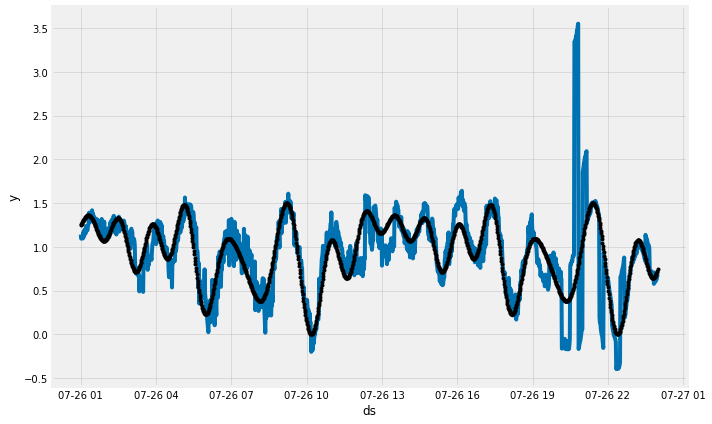

In [19]:
total_forecast3 = total_forecast2.copy()
total_forecast3['yhat'] = 0
total_forecast3 = total_forecast3.fillna(value=0)
for j in range(1, one_step_len+1):
    total_forecast3['yhat'] =  total_forecast3['yhat'] + total_forecast3['yhat' + str(j)]
total_forecast3 = total_forecast3[['ds', 'y' , 'yhat']]
total_forecast3.rename(columns = {'yhat':'yhat1'}, inplace = True)

total_forecast3 = total_forecast3.reset_index()
p = m.plot(total_forecast3)

In [20]:
total_forecast3

index                  ds         y     yhat1
0         0 2021-07-26 01:00:00  1.246153  1.141326
1         1 2021-07-26 01:01:00  1.255786  1.093481
2         2 2021-07-26 01:02:00  1.265448  1.108397
3         3 2021-07-26 01:03:00  1.275053  1.106785
4         4 2021-07-26 01:04:00  1.284515  1.097648
...     ...                 ...       ...       ...
1375   1375 2021-07-26 23:55:00  0.684520  0.613766
1376   1376 2021-07-26 23:56:00  0.697308  0.623374
1377   1377 2021-07-26 23:57:00  0.711640  0.636961
1378   1378 2021-07-26 23:58:00  0.727450  0.665710
1379   1379 2021-07-26 23:59:00  0.744666  0.688171

[1380 rows x 4 columns]